In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import sys
import os
import logging
import galsim
import random
import cmath as cm
import math
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, Flatten,  Reshape, UpSampling2D, Cropping2D, Conv2DTranspose, PReLU, Concatenate, Lambda, BatchNormalization, concatenate
from tensorflow.keras.models import Model, Sequential
import scipy.stats as stats
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline

import tensorflow as tf

Using TensorFlow backend.


In [2]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
from tools_for_VAE import vae_functions, model, utils

from tools_for_VAE.model import build_encoder, build_decoder
from tools_for_VAE.utils import load_deblender, load_alpha, denorm, delta_min, norm
from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, createCircularMask, mean_var, plot_corner_latent


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
import generator_deblender

In [4]:
from generator_deblender import BatchGenerator_test, BatchGenerator

In [5]:
from importlib import reload

In [6]:
reload(generator_deblender)

<module 'generator_deblender' from '/pbs/throng/lsst/users/barcelin/Deblender_VAE/notebooks/Deblender/generator_deblender.py'>

In [7]:
reload(utils)

<module 'tools_for_VAE.utils' from '../../scripts/tools_for_VAE/tools_for_VAE/utils.py'>

In [8]:
from generator_deblender import BatchGenerator_test, BatchGenerator

# Function to import dense VAE

In [9]:
# Parameters
batch_size = 100
original_dim = 64*64*6

In [10]:
alpha = K.variable(1e-4)
deblender, encoder, Dkl = load_deblender('/sps/lsst/users/barcelin/weights/LSST/deblender/noisy/v4+uni11/', '/sps/lsst/users/barcelin/weights/LSST/VAE/noisy/v8/mse/', 6, folder = True)
# '/sps/lsst/users/barcelin/weights/LSST/deblender/noisy/v4/'
K.set_value(alpha, load_alpha('/sps/lsst/users/barcelin/weights/LSST/deblender/noisy/v4/'))

def deblender_loss(x, x_decoded_mean):
    xent_loss = K.mean(K.sum(K.binary_crossentropy(x, x_decoded_mean), axis=[1,2,3]))#original_dim*
    kl_loss = K.get_value(alpha) * Dkl
    return xent_loss + K.mean(kl_loss)

deblender.compile('adam', loss=deblender_loss, metrics=['mse'])

Instructions for updating:
Colocations handled automatically by placer.


## Stamp size for plots

In [11]:
phys_stamp_size = 6.4 # arcsec
pixel_scale_euclid_vis = 0.1 # arcsec/pixel

stamp_size = int(phys_stamp_size/pixel_scale_euclid_vis)

# Load test list

In [23]:
r= np.load('/sps/lsst/users/barcelin/data/blended/COSMOS/uni25/galaxies_COSMOS_test_redshift_v5.npy')

In [22]:
mag = np.load('/sps/lsst/users/barcelin/data/blended/COSMOS/uni25/galaxies_COSMOS_test_magnitude_v5.npy')

# Function to compute the delta_r for each blended image

In [14]:
def delta_r_min(shift_path):
    shift =np.load(shift_path)
    
    #Reshape the list of shifts so that it is easily usable
    shifts = np.zeros((len(shift),4,2))
    for i in range (len(shift)):
        for j in range (len(shift[i])):
            shifts[i][j] = shift[i][j]
    #print(shifts)    
    # set lists
    deltas_r= np.zeros((len(shift),4))
    delta_r= np.zeros((len(shift)))
    
    # compute the delta r for each couple of galaxies
    for i in range (4):
        deltas_r[:,i] = np.sqrt(np.square(shifts[:,i,0])+np.square(shifts[:,i,1]))

    # Take the min of the non zero delta r
    for j in range (len(shifts)):
        # If all the deta_r are equals to 0 (there is only on galaxy on the image) then write 0
        if (deltas_r[j,:].any() == 0):
            delta_r[j] = 0
        else:
            x = np.where(deltas_r[j] == 0)[0]
            deltas = np.delete(deltas_r[j],x)
            delta_r[j] = np.min(deltas)
    
    return delta_r

In [24]:
shift = np.load('/sps/lsst/users/barcelin/data/blended/COSMOS/uni25/galaxies_COSMOS_test_shift_v5.npy')

In [136]:
delta_r = delta_r_min('/sps/lsst/users/barcelin/data/blended/COSMOS/galaxies_COSMOS_test_shift_v5.npy')

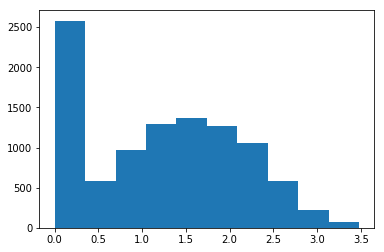

In [16]:
_ = plt.hist(delta_r)

In [20]:
mag.shape, mag[0], mag[2]

((10000,),
 [28.17391899792117,
  26.30882282294304,
  26.994678008413267,
  27.341759298060033],
 [27.642601104746188, 26.523780351467927, 28.225218817596094])

In [34]:
for i in range (20):
    print(mag[i])

[26.86235248636027]
[29.46929983406686, 26.853952761768706]
[26.451210934857542]
[26.17212952653915, 26.996009960302455, 28.40811503278026, 22.486276118273437]
[27.921785029907713, 25.891599211863806, 27.830088248830357, 27.45482407108213]
[25.05721864654823]
[27.401023712313897, 27.999226590968995, 26.574241195727204]
[25.905064868502777, 27.920750650140523, 24.448080803067718]
[26.12325266422262, 24.520647435904095]
[23.520920147736625, 25.027966963761894, 27.52233606627347]
[27.616134231206587]
[27.96065017382977, 26.550931486806256]
[25.363465415789165, 28.031378544592446, 27.70946531066444, 27.157557593862833]
[28.525969056228277, 28.24438714425273, 26.394978556958627]
[27.785910570583564, 26.94012212969869]
[22.57046555002716]
[26.994335462113916, 29.33574740442492, 28.511801894045135]
[25.32277277700458, 26.648062214535457, 27.322300484775667]
[26.77432894968299, 27.558666582412815]
[27.38339818320135, 24.42807216411059]


In [31]:
mag.shape, len(mag[0]), shift.shape, len(shift[0])

((10000,), 4, (10000,), 3)

In [68]:
#Reshape the list of shifts so that it is easily usable
shifts = np.zeros((len(shift),3,2))
mags = np.zeros((len(mag),4))
mags_new = np.zeros((len(mag),3))

# Create an array of minimum magnitude for each image
mag_min = np.zeros(len(mag))
for k in range (len(mag)):
    mag_min[k] = np.min(mag[k])

# set lists
deltas_r= np.zeros((len(shift),3))
delta_r= np.zeros((len(shift)))
delta_mag = np.zeros((len(shift)))
deltas_mag= np.zeros((len(shift),4))

for i in range (len(shift)):
    for j in range (len(shift[i])):
        deltas_r[i][j] = np.sqrt(np.square(shift[i][j][0])+np.square(shift[i][j][1]))
    for j in range (len(mag[i])):
        deltas_mag [i][j] = mag[i][j] - mag_min[i]
        #print(deltas_mag.shape)
        
# Create a deltas_mag liste without all zeros: place of the centered galaxy when generated
deltas_mag_3= np.zeros((len(deltas_mag),3))
counter = 0
for k in range (len(deltas_mag)):
    No_zero = True
    for l in range (len(deltas_mag[k])):
        if deltas_mag[k][l] == 0 and No_zero:
            counter +=1
            No_zero = False
        elif No_zero == False:
            deltas_mag_3[k][l-1] = deltas_mag[k][l]
        else:
            deltas_mag_3[k][l] = deltas_mag[k][l]
                
print(counter, deltas_mag_3)
# Take the min of the non zero delta r
c = 0
for j in range (len(shifts)):
    print('image : '+str(j))
    # If all the deta_r are equals to 0 (there is only on galaxy on the image) then write 0
    if (deltas_r[j,:].any() == 0):
        delta_r[j] = 0
        delta_mag[j] = 0
        c+=1
    else:
        x = np.where(deltas_r[j] == 0)[0]
        deltas = np.delete(deltas_r[j],x)
        delta_r[j] = np.min(deltas)
        y = np.where(deltas == np.min(deltas))[0]
        print(np.min(deltas), deltas)
        delta_mag[j] = deltas_mag_3[j,y]
        print(y, deltas_mag_3[j,y], deltas_mag_3[j])

10000 [[1.86509617 0.68585519 1.03293648]
 [1.23999    1.63393949 1.45006398]
 [1.11882075 1.70143847 0.        ]
 ...
 [0.38250373 0.29480849 0.45828811]
 [2.08866525 0.09366452 0.        ]
 [2.61880822 0.09046548 0.        ]]
image : 0
1.5455573553144586 [2.01533873 1.54555736 2.69790255]
[1] [0.68585519] [1.86509617 0.68585519 1.03293648]
image : 1
2.095941884696766 [2.51794832 2.47641545 2.09594188]
[2] [1.45006398] [1.23999    1.63393949 1.45006398]
image : 2
2.2008802339828653 [2.64705327 2.20088023]
[1] [1.70143847] [1.11882075 1.70143847 0.        ]
image : 3
1.7803105750551262 [1.78031058 2.32129635]
[0] [0.79163615] [0.79163615 1.65374073 0.        ]
image : 4
1.7660790191804219 [1.78566997 2.89784296 1.76607902]
[2] [1.84590641] [1.19512756 3.34530881 1.84590641]
image : 5
0.38673618694975237 [1.77472066 0.38673619 1.48172126]
[1] [4.20073433] [2.19801403 4.20073433 2.95933453]
image : 6
2.2802874253847834 [2.28028743]
[0] [2.69915288] [2.69915288 0.         0.        ]
imag

[0] [0.89438548] [0.89438548 0.         0.        ]
image : 219
1.432522363166651 [1.43252236]
[0] [0.66796185] [0.66796185 0.         0.        ]
image : 220
par ici
image : 221
2.4573252228007387 [2.45732522]
[0] [1.56058337] [1.56058337 0.         0.        ]
image : 222
0.6837886757688356 [0.68378868 1.69490474]
[0] [0.89271187] [0.89271187 0.5647417  0.        ]
image : 223
1.0457971092309528 [1.04579711 2.43359361]
[0] [1.49332079] [1.49332079 1.77416315 0.        ]
image : 224
2.4741126924175068 [2.47411269]
[0] [1.17939763] [1.17939763 0.         0.        ]
image : 225
2.0165543687196346 [2.61230143 2.16962382 2.01655437]
[2] [3.16466914] [2.87737245 1.39563219 3.16466914]
image : 226
2.058981654305786 [2.56877223 2.05898165 2.85074197]
[1] [0.45098562] [2.10772046 0.45098562 0.18717045]
image : 227
par ici
image : 228
1.9902823141604222 [1.99028231 2.68752592]
[0] [1.72900542] [1.72900542 2.92074741 0.        ]
image : 229
par ici
image : 230
2.1381161022087207 [3.42326984 2.

[2] [1.28269733] [3.27608404 1.31723851 1.28269733]
image : 394
1.3697064768812108 [1.36970648 2.57672147]
[0] [1.42653112] [1.42653112 1.19838298 0.        ]
image : 395
2.691520593363157 [2.69152059]
[0] [3.17766126] [3.17766126 0.         0.        ]
image : 396
par ici
image : 397
2.118007625963157 [2.78805144 2.11800763 2.17191551]
[1] [2.59159072] [6.2767783  2.59159072 3.26685659]
image : 398
0.4932519255686059 [0.49325193 1.64565923 2.29548605]
[0] [1.0214553] [1.0214553  4.17289853 2.73843236]
image : 399
2.091855233483728 [2.09185523]
[0] [0.99685312] [0.99685312 0.         0.        ]
image : 400
2.414219062167905 [2.41421906]
[0] [0.4117078] [0.4117078 0.        0.       ]
image : 401
0.8732741341231184 [2.53396353 0.87327413 2.74359079]
[1] [0.09640399] [0.35625154 0.09640399 0.25065619]
image : 402
par ici
image : 403
1.59597212649128 [1.59597213 1.85529879 3.05411896]
[0] [3.76006188] [3.76006188 2.1737899  3.97549997]
image : 404
1.551004626204994 [1.55100463 2.18295942

[2] [2.16367643] [0.96077488 0.06326215 2.16367643]
image : 587
2.2345855219256 [2.23458552]
[0] [0.02899476] [0.02899476 0.         0.        ]
image : 588
1.4082414343275378 [2.88711964 1.40824143]
[1] [1.00914594] [2.51264842 1.00914594 0.        ]
image : 589
0.9464958871238199 [0.94649589 1.40797978]
[0] [1.53840495] [1.53840495 0.93353174 0.        ]
image : 590
2.191011032964226 [2.19101103]
[0] [2.29106152] [2.29106152 0.         0.        ]
image : 591
2.4494288613742454 [2.44942886]
[0] [0.81682163] [0.81682163 0.         0.        ]
image : 592
par ici
image : 593
par ici
image : 594
2.007028314714147 [2.16992662 2.00702831 3.4188374 ]
[1] [3.26677789] [4.26793257 3.26677789 3.03120796]
image : 595
2.1141379379063783 [2.32720233 2.51921    2.11413794]
[2] [0.95097566] [0.80332202 0.21243355 0.95097566]
image : 596
0.09516221861960596 [2.07093242 0.09516222]
[1] [4.02502863] [5.11562964 4.02502863 0.        ]
image : 597
par ici
image : 598
0.27966055605464857 [1.14189268 1.5

image : 815
2.442441611525948 [2.44244161]
[0] [0.28192199] [0.28192199 0.         0.        ]
image : 816
1.7013174885977205 [2.53450795 1.70131749 2.29797698]
[1] [1.33275896] [1.23717775 1.33275896 1.06351413]
image : 817
0.8027392639721282 [2.30088419 3.23784991 0.80273926]
[2] [3.01351369] [2.68612447 1.09489196 3.01351369]
image : 818
2.370257038765762 [2.96037203 2.37025704]
[1] [2.97677931] [2.86863049 2.97677931 0.        ]
image : 819
1.6411411541333931 [1.64114115]
[0] [6.03063895] [6.03063895 0.         0.        ]
image : 820
0.4539468392450027 [0.45394684]
[0] [1.54853243] [1.54853243 0.         0.        ]
image : 821
2.2739019160192298 [2.98955172 2.27390192]
[1] [0.88412984] [0.97942868 0.88412984 0.        ]
image : 822
1.3936179716875987 [2.33590494 1.39361797]
[1] [1.23536683] [1.73912635 1.23536683 0.        ]
image : 823
par ici
image : 824
2.7668899523773876 [2.76688995]
[0] [4.2259272] [4.2259272 0.        0.       ]
image : 825
1.0888387268116828 [1.63627985 1.

[2] [4.35601285] [3.72578288 3.95640481 4.35601285]
image : 1068
2.2071692722400553 [2.42182526 2.20716927 2.40549705]
[1] [2.40965991] [2.25166553 2.40965991 1.56940377]
image : 1069
1.616452889546074 [1.61645289 2.40224778]
[0] [1.09290576] [1.09290576 2.0892646  0.        ]
image : 1070
1.9264903525778683 [3.34343713 1.92649035 2.61778195]
[1] [2.74738429] [3.05854379 2.74738429 3.00918744]
image : 1071
par ici
image : 1072
par ici
image : 1073
0.8774193946192319 [0.87741939 1.87607946 1.91576198]
[0] [1.9072254] [1.9072254  0.18286462 2.35969261]
image : 1074
par ici
image : 1075
0.6205148674449784 [0.62051487 2.45332444]
[0] [1.49959585] [1.49959585 0.68770404 0.        ]
image : 1076
0.4564027466065443 [0.45640275 1.23715419 1.40078155]
[0] [2.06550845] [2.06550845 0.7028053  1.19206391]
image : 1077
2.4784241841341785 [3.13126982 2.90704219 2.47842418]
[2] [0.35760439] [0.0919529  0.71959418 0.35760439]
image : 1078
2.27430843459666 [2.27430843]
[0] [1.36063413] [1.36063413 0.  

[0] [1.79872304] [1.79872304 3.26924984 0.        ]
image : 1280
1.9248363446699943 [2.05823214 1.92483634]
[1] [1.49894578] [0.49102378 1.49894578 0.        ]
image : 1281
3.010001778086129 [3.01000178]
[0] [1.61929446] [1.61929446 0.         0.        ]
image : 1282
0.5045161203603429 [1.88958191 0.50451612]
[1] [1.60486113] [0.82151391 1.60486113 0.        ]
image : 1283
2.3742902143603346 [2.4322523  2.37429021 3.11850591]
[1] [0.35186633] [0.58899757 0.35186633 1.13384464]
image : 1284
0.7470681610152584 [0.74706816 1.76668218]
[0] [0.45537853] [0.45537853 1.1093008  0.        ]
image : 1285
0.4202463056520888 [0.42024631 1.56442991 2.98568705]
[0] [1.15219195] [1.15219195 1.29904206 1.85136434]
image : 1286
par ici
image : 1287
1.4009130962752232 [1.4009131  1.62149309]
[0] [0.67709963] [0.67709963 0.82142028 0.        ]
image : 1288
par ici
image : 1289
1.3160388458933945 [1.31603885 1.41626953 2.42874148]
[0] [0.7907618] [0.7907618  1.02262996 0.29137848]
image : 1290
1.1836765

[0] [3.78058217] [3.78058217 0.         0.        ]
image : 1551
1.1854302912988435 [1.51312791 1.18543029]
[1] [3.49491726] [2.76906582 3.49491726 0.        ]
image : 1552
0.8447321826972055 [0.84473218 2.05622128]
[0] [0.87009451] [0.87009451 0.22652122 0.        ]
image : 1553
par ici
image : 1554
par ici
image : 1555
1.8372073625201795 [1.99910587 1.83720736 2.98550269]
[1] [3.88068723] [3.1377817  3.88068723 3.44171828]
image : 1556
par ici
image : 1557
par ici
image : 1558
1.3422065252562556 [1.44950362 1.34220653]
[1] [1.34045787] [0.83038268 1.34045787 0.        ]
image : 1559
1.9562109177693958 [1.95621092]
[0] [1.74270006] [1.74270006 0.         0.        ]
image : 1560
par ici
image : 1561
1.1625376556099554 [1.16253766 2.46544837]
[0] [2.02587838] [2.02587838 0.66186556 0.        ]
image : 1562
2.520334897989759 [2.5203349]
[0] [0.94772201] [0.94772201 0.         0.        ]
image : 1563
1.8546623263957318 [2.44997888 1.85466233]
[1] [3.19860929] [3.68434591 3.19860929 0.  

[2] [0.43412494] [0.73666632 1.23285117 0.43412494]
image : 1837
par ici
image : 1838
0.365584423281886 [0.36558442 0.71873328 2.34633874]
[0] [0.55580066] [0.55580066 1.4634661  1.06560368]
image : 1839
1.901458457568929 [2.13030072 1.90145846 2.09321128]
[1] [0.64004532] [2.96279088 0.64004532 2.30817895]
image : 1840
par ici
image : 1841
par ici
image : 1842
0.9458530394410666 [2.06338506 1.46194469 0.94585304]
[2] [2.73027075] [2.56244973 1.23679732 2.73027075]
image : 1843
1.292675175653112 [3.30518463 1.29267518 2.63317398]
[1] [1.90744983] [2.13098397 1.90744983 1.07592367]
image : 1844
1.9220886193468414 [2.46559841 1.92208862 2.00453811]
[1] [3.49384434] [4.3104681  3.49384434 3.76668967]
image : 1845
1.443817905644942 [1.50427999 1.44381791]
[1] [1.0324139] [1.07120383 1.0324139  0.        ]
image : 1846
1.5037668612831965 [1.50376686]
[0] [1.74165074] [1.74165074 0.         0.        ]
image : 1847
2.172053902343838 [2.1720539]
[0] [2.65564455] [2.65564455 0.         0.     

0.41477295373532475 [3.05012895 0.41477295 1.93918202]
[1] [2.28220885] [1.36451179 2.28220885 1.69943822]
image : 2096
2.0380906644416137 [3.27631297 2.03809066 3.0455847 ]
[1] [1.43853287] [2.05061568 1.43853287 0.7758004 ]
image : 2097
par ici
image : 2098
1.2860741648816878 [1.32485614 1.28607416]
[1] [1.96228216] [1.12099617 1.96228216 0.        ]
image : 2099
1.7882248112841386 [1.79421724 1.78822481]
[1] [1.94388726] [2.23262685 1.94388726 0.        ]
image : 2100
par ici
image : 2101
1.2060575723862557 [1.65209061 2.51211913 1.20605757]
[2] [2.8834173] [0.92397668 1.9205735  2.8834173 ]
image : 2102
2.4297365059374 [2.42973651 2.5961538 ]
[0] [0.52355883] [0.52355883 0.19917748 0.        ]
image : 2103
par ici
image : 2104
1.478739380067557 [2.47547011 1.47873938]
[1] [2.85434249] [3.65589378 2.85434249 0.        ]
image : 2105
1.193582654102208 [1.19358265 1.34541749 1.89328423]
[0] [2.11471837] [2.11471837 2.303704   2.3011645 ]
image : 2106
2.8785343222043838 [2.87853432]
[0

[1] [2.31848989] [1.74647898 2.31848989 2.02575584]
image : 2380
1.440235648045613 [2.23633458 1.44023565]
[1] [1.59798081] [1.98117359 1.59798081 0.        ]
image : 2381
1.2768300707040225 [2.37501021 1.27683007]
[1] [1.18016549] [1.16787414 1.18016549 0.        ]
image : 2382
0.7908833254325216 [0.79088333 2.46676589]
[0] [4.73951943] [4.73951943 1.52850749 0.        ]
image : 2383
par ici
image : 2384
par ici
image : 2385
1.1415625787633654 [1.14156258]
[0] [1.7754238] [1.7754238 0.        0.       ]
image : 2386
2.33868754923547 [2.50776174 2.33868755]
[1] [1.53017866] [1.56032933 1.53017866 0.        ]
image : 2387
1.6033970271721587 [2.68188319 1.60339703]
[1] [2.62983934] [2.49393121 2.62983934 0.        ]
image : 2388
par ici
image : 2389
1.5984102978903971 [1.5984103  1.93631574]
[0] [0.48999331] [0.48999331 0.60834259 0.        ]
image : 2390
par ici
image : 2391
1.6795287758561004 [2.66499669 1.67952878]
[1] [1.17250517] [0.8135531  1.17250517 0.        ]
image : 2392
2.349

[2] [3.69979535] [1.22439534 1.86545133 3.69979535]
image : 2691
1.8075185066858268 [2.28040506 1.80751851]
[1] [2.11573902] [1.79774711 2.11573902 0.        ]
image : 2692
par ici
image : 2693
par ici
image : 2694
1.944478968243899 [1.94447897 2.47942523 2.21183994]
[0] [0.47464533] [0.47464533 3.804808   2.60166262]
image : 2695
1.5127303883536567 [2.749026   1.98346499 1.51273039]
[2] [1.06886826] [0.12005421 1.09570868 1.06886826]
image : 2696
1.5001731685223887 [1.83725032 2.3887505  1.50017317]
[2] [0.19066327] [1.41093148 1.49394924 0.19066327]
image : 2697
1.4911017331480787 [2.37376408 1.49110173]
[1] [2.79045999] [1.39336208 2.79045999 0.        ]
image : 2698
par ici
image : 2699
1.1917977816314245 [2.90737843 1.19179778]
[1] [2.13760317] [1.10497346 2.13760317 0.        ]
image : 2700
1.2324754999085596 [1.2324755  1.84314862 2.39172984]
[0] [0.30844006] [0.30844006 0.33080601 0.6299503 ]
image : 2701
1.5720758888720296 [2.72864594 1.57207589]
[1] [2.35061058] [2.54093769 2

[0] [1.79400215] [1.79400215 1.42972981 1.57742823]
image : 3066
0.46607093016477463 [0.46607093 2.76418428]
[0] [4.19553557] [4.19553557 3.87613573 0.        ]
image : 3067
1.708412645732833 [2.57543399 1.70841265]
[1] [5.19107157] [6.28196204 5.19107157 0.        ]
image : 3068
2.048885347415071 [2.36301829 2.04888535 2.667432  ]
[1] [0.54053212] [2.06194838 0.54053212 0.21372431]
image : 3069
par ici
image : 3070
par ici
image : 3071
2.171284546124863 [2.17128455]
[0] [0.74995422] [0.74995422 0.         0.        ]
image : 3072
0.5867696620212162 [0.58676966 2.99094886 2.091155  ]
[0] [3.75119804] [3.75119804 5.3493321  3.82341354]
image : 3073
1.729071818047116 [1.72907182 2.04445619 2.56025369]
[0] [0.67193443] [0.67193443 2.5581909  2.93546913]
image : 3074
par ici
image : 3075
1.414178355895912 [1.41417836 1.4287475 ]
[0] [4.39875632] [4.39875632 4.02443504 0.        ]
image : 3076
2.070383586476781 [2.07038359]
[0] [0.37437155] [0.37437155 0.         0.        ]
image : 3077
0.

1.7716746250612465 [1.77167463 2.25557822]
[0] [0.0524346] [0.0524346  0.16273803 0.        ]
image : 3387
2.0193746584596037 [2.01937466 2.79236131]
[0] [6.5510275] [6.5510275  5.94018612 0.        ]
image : 3388
2.2592748159040013 [2.25927482]
[0] [0.85310505] [0.85310505 0.         0.        ]
image : 3389
2.5966155008196243 [2.79440815 2.5966155 ]
[1] [1.24622368] [0.97083553 1.24622368 0.        ]
image : 3390
1.6532609912244483 [1.65326099 2.09861864 2.8397876 ]
[0] [3.73497615] [3.73497615 0.89135144 2.30182634]
image : 3391
1.915657920323675 [1.91565792]
[0] [1.34731787] [1.34731787 0.         0.        ]
image : 3392
par ici
image : 3393
1.4375309809943253 [1.43753098 3.04997071 1.58792352]
[0] [2.0998005] [2.0998005  2.10428578 0.73864249]
image : 3394
1.0182338231473371 [2.21766304 1.01823382 1.24098694]
[1] [4.99702206] [4.53946474 4.99702206 5.33991057]
image : 3395
par ici
image : 3396
par ici
image : 3397
1.2998868494254399 [1.89655127 1.59017144 1.29988685]
[2] [0.84673

1.478123747092427 [2.06230873 1.47812375]
[1] [0.50579721] [0.50551474 0.50579721 0.        ]
image : 3680
1.4949380842833837 [1.49493808 2.67256017]
[0] [0.53564271] [0.53564271 0.12288744 0.        ]
image : 3681
1.5310978872503058 [1.53109789 1.65652099]
[0] [0.56305405] [0.56305405 0.17434776 0.        ]
image : 3682
0.268239843045899 [2.58725663 0.26823984]
[1] [1.4826831] [1.53562871 1.4826831  0.        ]
image : 3683
0.9715838712062073 [0.97158387 2.1873514 ]
[0] [1.26604113] [1.26604113 0.25711358 0.        ]
image : 3684
par ici
image : 3685
1.1258133504641161 [1.12581335 2.39995654 2.16773549]
[0] [3.18791916] [3.18791916 2.3618977  1.32477767]
image : 3686
1.1740761617328666 [1.17407616 2.26424765 2.09147952]
[0] [0.86445296] [0.86445296 0.93368732 0.42693979]
image : 3687
par ici
image : 3688
0.9532975990402107 [3.40002774 3.4113685  0.9532976 ]
[2] [0.79016728] [2.02105505 1.51353064 0.79016728]
image : 3689
2.3626078797510446 [2.36260788 2.5590566 ]
[0] [2.24128486] [2.2

1.4740280351678114 [2.26959905 3.15773835 1.47402804]
[2] [0.58155224] [2.7125873  2.0282947  0.58155224]
image : 3926
1.9866820476297222 [1.98668205]
[0] [1.13622621] [1.13622621 0.         0.        ]
image : 3927
1.8662863053645813 [2.32942108 2.23940348 1.86628631]
[2] [2.3453373] [2.1276717  2.55403023 2.3453373 ]
image : 3928
2.075373977510343 [2.07537398]
[0] [1.24239039] [1.24239039 0.         0.        ]
image : 3929
2.0567436481995434 [2.05674365]
[0] [0.5203336] [0.5203336 0.        0.       ]
image : 3930
2.01362579657803 [2.17384641 2.0136258  2.27879062]
[1] [0.43856387] [0.33733894 0.43856387 0.43048575]
image : 3931
2.226746559821757 [2.22674656]
[0] [0.7761809] [0.7761809 0.        0.       ]
image : 3932
0.3500663214454423 [0.35006632 1.68014251]
[0] [0.61787629] [0.61787629 0.073419   0.        ]
image : 3933
1.4921774579905465 [3.03704986 1.49217746]
[1] [0.19583927] [0.87290803 0.19583927 0.        ]
image : 3934
1.5842436855437099 [2.8586741  1.58424369 1.92748011

[0] [3.06951476] [3.06951476 2.5248187  1.9078    ]
image : 4197
1.209293086699696 [1.52320237 1.20929309 2.36569904]
[1] [4.17700022] [2.92041286 4.17700022 1.96001842]
image : 4198
0.6125160191261666 [2.61074112 0.61251602]
[1] [1.81785355] [0.96746282 1.81785355 0.        ]
image : 4199
1.2810290457335582 [2.80853072 1.73392301 1.28102905]
[2] [2.55226091] [1.7135619  0.78044859 2.55226091]
image : 4200
2.472234766526322 [2.47223477 2.72659898]
[0] [0.95899646] [0.95899646 0.79095274 0.        ]
image : 4201
1.802535205873931 [1.80253521]
[0] [1.75302747] [1.75302747 0.         0.        ]
image : 4202
1.9844690215662162 [2.28567073 1.98446902]
[1] [0.09000926] [0.25864327 0.09000926 0.        ]
image : 4203
0.6817410438195464 [0.68174104 2.25384413 1.62260419]
[0] [4.43113859] [4.43113859 4.57432809 3.37710352]
image : 4204
2.122459921835039 [2.19729018 2.12245992]
[1] [2.53871115] [0.86240709 2.53871115 0.        ]
image : 4205
par ici
image : 4206
2.5884288212640643 [2.58842882]


[0] [0.82392425] [0.82392425 1.57619413 0.        ]
image : 4499
par ici
image : 4500
par ici
image : 4501
0.7613524105247413 [1.55595556 2.53486394 0.76135241]
[2] [0.79577135] [0.90806664 1.48328732 0.79577135]
image : 4502
2.0444393752317196 [2.04443938]
[0] [1.07914158] [1.07914158 0.         0.        ]
image : 4503
1.6066716955913067 [1.6066717]
[0] [2.14231232] [2.14231232 0.         0.        ]
image : 4504
1.7558249862718391 [1.75582499 3.04839354]
[0] [3.59892588] [3.59892588 3.71034685 0.        ]
image : 4505
1.6669870520420458 [3.198791   1.66698705]
[1] [1.88298118] [1.1940366  1.88298118 0.        ]
image : 4506
1.7333006711584769 [1.73330067 2.4933997  3.21072031]
[0] [1.06986185] [1.06986185 0.50649663 0.66180318]
image : 4507
0.8350785516085265 [1.6754101  0.83507855]
[1] [1.33695323] [0.58595609 1.33695323 0.        ]
image : 4508
par ici
image : 4509
par ici
image : 4510
2.3129760621244073 [2.31297606]
[0] [2.04027265] [2.04027265 0.         0.        ]
image : 4511

1.8487883495967512 [1.84878835]
[0] [0.80080114] [0.80080114 0.         0.        ]
image : 4793
2.996652968867657 [2.99665297]
[0] [1.30370133] [1.30370133 0.         0.        ]
image : 4794
0.5780149003470741 [0.8130843  3.18399477 0.5780149 ]
[2] [2.74018021] [3.2524707  1.48994504 2.74018021]
image : 4795
2.0901325391022496 [2.37270152 2.09013254]
[1] [0.32319214] [1.13523444 0.32319214 0.        ]
image : 4796
2.2362605188980704 [2.23626052]
[0] [1.36384905] [1.36384905 0.         0.        ]
image : 4797
1.1809049556244635 [1.18090496 2.37115491 1.33406724]
[0] [0.25837096] [0.25837096 2.13482803 1.74930342]
image : 4798
1.8218212773900766 [1.98567221 2.64778047 1.82182128]
[2] [3.0568747] [2.97648408 2.17219675 3.0568747 ]
image : 4799
1.4806595894239625 [1.48065959]
[0] [0.90199681] [0.90199681 0.         0.        ]
image : 4800
1.1821101922235142 [1.34489444 2.4913363  1.18211019]
[2] [0.78665279] [0.28837993 0.02823453 0.78665279]
image : 4801
2.4715524270298963 [2.8575758 

1.5936898590600164 [2.96014777 1.59368986]
[1] [1.09169853] [0.98756296 1.09169853 0.        ]
image : 5006
2.4149972455019375 [2.41499725]
[0] [2.23708761] [2.23708761 0.         0.        ]
image : 5007
1.714726240835133 [2.14486932 1.71472624]
[1] [1.27179118] [0.61849047 1.27179118 0.        ]
image : 5008
2.151104690926048 [2.48929673 2.15110469 2.79587196]
[1] [2.57166551] [2.78683213 2.57166551 1.50632028]
image : 5009
0.5491026094360226 [0.54910261]
[0] [1.24415019] [1.24415019 0.         0.        ]
image : 5010
par ici
image : 5011
2.217456845140806 [2.40781345 2.21745685]
[1] [0.13731876] [0.45958508 0.13731876 0.        ]
image : 5012
0.08324430614338003 [0.08324431 2.21747459]
[0] [1.89995162] [1.89995162 2.06900206 0.        ]
image : 5013
2.4357039272206205 [2.43570393]
[0] [3.9903708] [3.9903708 0.        0.       ]
image : 5014
1.4788233823469623 [1.47882338 2.1730432 ]
[0] [0.76130555] [0.76130555 0.52882065 0.        ]
image : 5015
2.0033133403409975 [2.11927331 2.00

2.0485871954449197 [2.45942704 2.0485872 ]
[1] [3.18288717] [1.41510236 3.18288717 0.        ]
image : 5157
0.801621793714444 [2.15697818 0.80162179 1.83732643]
[1] [2.91302551] [1.38432578 2.91302551 2.80183266]
image : 5158
2.5858425508772047 [2.58584255]
[0] [1.53158757] [1.53158757 0.         0.        ]
image : 5159
2.5506542910401877 [2.7617291  2.67307584 2.55065429]
[2] [0.76185016] [0.53863483 0.35080134 0.76185016]
image : 5160
1.9378406553636747 [2.47218948 1.93784066]
[1] [0.77364376] [1.28871964 0.77364376 0.        ]
image : 5161
par ici
image : 5162
par ici
image : 5163
par ici
image : 5164
0.37935014883901347 [0.37935015 1.64141134 2.12628235]
[0] [1.31346648] [1.31346648 2.51558561 1.3876991 ]
image : 5165
1.357802557335945 [1.35780256]
[0] [3.46630389] [3.46630389 0.         0.        ]
image : 5166
2.297428974315521 [2.6017992  2.29742897]
[1] [0.00335864] [0.37680098 0.00335864 0.        ]
image : 5167
par ici
image : 5168
0.8340924609811762 [3.30979227 0.83409246]


2.0465158330895963 [2.04651583]
[0] [1.56730634] [1.56730634 0.         0.        ]
image : 5399
0.3670158977642942 [2.38249766 1.24130616 0.3670159 ]
[2] [6.35307833] [6.23264592 7.05452419 6.35307833]
image : 5400
1.2386937006082916 [3.10716338 2.3642797  1.2386937 ]
[2] [1.18571289] [1.79045511 1.35053736 1.18571289]
image : 5401
par ici
image : 5402
0.7514997695250186 [0.75149977]
[0] [0.50818828] [0.50818828 0.         0.        ]
image : 5403
par ici
image : 5404
1.9811420224601493 [1.98114202]
[0] [0.31230109] [0.31230109 0.         0.        ]
image : 5405
1.037422571606384 [1.72953183 1.03742257]
[1] [0.17322838] [0.82889506 0.17322838 0.        ]
image : 5406
1.4273999898981231 [1.42739999 2.16039821 3.26349011]
[0] [3.36880074] [3.36880074 2.03406577 1.64803749]
image : 5407
1.3885404871164417 [1.38854049 2.1146035 ]
[0] [2.44156382] [2.44156382 1.50258649 0.        ]
image : 5408
1.7676985017433113 [2.27362882 1.7676985 ]
[1] [0.56894696] [2.48423056 0.56894696 0.        ]


[2] [2.38752755] [1.28184612 0.2222883  2.38752755]
image : 5689
1.5968850199118538 [1.59688502 1.65176861]
[0] [1.42769111] [1.42769111 1.13864792 0.        ]
image : 5690
1.0982135536014626 [1.09821355]
[0] [1.79198046] [1.79198046 0.         0.        ]
image : 5691
0.7697876050278729 [0.76978761 2.67481294 2.49532213]
[0] [5.6575442] [5.6575442  4.17674365 3.25465563]
image : 5692
1.457736886230018 [1.45773689]
[0] [0.28496796] [0.28496796 0.         0.        ]
image : 5693
1.8178505922474741 [2.04976705 2.6960316  1.81785059]
[2] [0.73686326] [1.04921974 1.40167645 0.73686326]
image : 5694
par ici
image : 5695
1.8155111531501935 [2.55753104 1.81551115]
[1] [4.93579505] [6.38757412 4.93579505 0.        ]
image : 5696
par ici
image : 5697
par ici
image : 5698
par ici
image : 5699
par ici
image : 5700
par ici
image : 5701
1.6832184285170129 [1.71594201 1.68321843]
[1] [2.37592581] [1.40620723 2.37592581 0.        ]
image : 5702
par ici
image : 5703
1.6116139516943404 [1.61161395]
[0

image : 5894
par ici
image : 5895
1.4207238804004663 [2.99091467 1.79576152 1.42072388]
[2] [0.53399101] [0.59651598 0.03837514 0.53399101]
image : 5896
0.3495349411761811 [0.34953494]
[0] [0.84064795] [0.84064795 0.         0.        ]
image : 5897
1.7116590574710988 [1.71165906 2.66856846]
[0] [2.49461789] [2.49461789 2.47910157 0.        ]
image : 5898
2.189034021280185 [2.21640303 2.18903402]
[1] [2.89025287] [2.49634626 2.89025287 0.        ]
image : 5899
par ici
image : 5900
par ici
image : 5901
1.2756471290122677 [2.47360122 1.27564713]
[1] [1.24949359] [0.52779521 1.24949359 0.        ]
image : 5902
0.9791938354315759 [1.59859592 1.4340169  0.97919384]
[2] [2.15869533] [2.75327482 1.46345069 2.15869533]
image : 5903
2.252503705804363 [2.43148822 2.25250371]
[1] [0.53523557] [0.54472243 0.53523557 0.        ]
image : 5904
1.2974589358770188 [2.20400977 1.29745894]
[1] [3.24111944] [3.27781851 3.24111944 0.        ]
image : 5905
1.4488004041894167 [2.21796342 2.14174403 1.4488004

image : 6180
0.5601494231717938 [1.64620677 0.56014942]
[1] [0.98278001] [0.78904483 0.98278001 0.        ]
image : 6181
0.8073686232825998 [2.30310771 0.80736862]
[1] [0.05916126] [0.39237186 0.05916126 0.        ]
image : 6182
1.434333541793098 [1.43433354 2.68701009]
[0] [3.11018464] [3.11018464 1.35222882 0.        ]
image : 6183
1.2419390937711476 [1.24193909 2.57171879]
[0] [0.41102526] [0.41102526 1.16073608 0.        ]
image : 6184
1.1425146920570837 [1.7572695  2.44898079 1.14251469]
[2] [3.06976684] [0.37408815 0.70874394 3.06976684]
image : 6185
2.047364890954406 [2.04736489 2.66831809]
[0] [1.50172624] [1.50172624 1.19124145 0.        ]
image : 6186
par ici
image : 6187
par ici
image : 6188
par ici
image : 6189
par ici
image : 6190
2.833893567822368 [2.83389357]
[0] [1.13747813] [1.13747813 0.         0.        ]
image : 6191
0.8140652709249687 [2.5249152  0.81406527]
[1] [1.3311515] [5.02590208 1.3311515  0.        ]
image : 6192
1.9099960462280807 [1.90999605]
[0] [1.6678

[1] [1.1294714] [0.75077712 1.1294714  0.        ]
image : 6390
1.0531498090297013 [1.05314981 1.83641819]
[0] [4.03360312] [4.03360312 4.20363559 0.        ]
image : 6391
par ici
image : 6392
par ici
image : 6393
1.294268323665999 [1.29426832]
[0] [2.35611533] [2.35611533 0.         0.        ]
image : 6394
par ici
image : 6395
par ici
image : 6396
par ici
image : 6397
1.9489437025425176 [2.83043443 1.9489437 ]
[1] [0.58779179] [0.70385099 0.58779179 0.        ]
image : 6398
1.9946303948865303 [1.99463039]
[0] [1.42967925] [1.42967925 0.         0.        ]
image : 6399
2.6693366445000133 [2.81652484 2.66933664]
[1] [1.65908292] [1.52624662 1.65908292 0.        ]
image : 6400
par ici
image : 6401
2.1924421451979277 [2.19244215 2.36627598]
[0] [0.87633331] [0.87633331 0.67255455 0.        ]
image : 6402
1.3554772516225788 [1.35547725 2.50569136]
[0] [1.84298485] [1.84298485 0.39195711 0.        ]
image : 6403
2.5214840808633383 [2.73025614 2.52148408]
[1] [3.77783341] [3.91577646 3.777

[2] [5.12477534] [4.37629105 4.77061313 5.12477534]
image : 6696
1.300109066331085 [1.30010907]
[0] [1.36985631] [1.36985631 0.         0.        ]
image : 6697
0.9146040180411245 [0.91460402 2.17486798]
[0] [4.54540681] [4.54540681 1.63721814 0.        ]
image : 6698
0.6443192611809443 [0.64431926]
[0] [0.19612486] [0.19612486 0.         0.        ]
image : 6699
2.048999500639213 [2.0489995 3.0100887]
[0] [0.30676687] [0.30676687 0.69684642 0.        ]
image : 6700
2.2754179444686295 [2.27541794]
[0] [1.60601232] [1.60601232 0.         0.        ]
image : 6701
2.8716304997348656 [2.8716305]
[0] [4.72264928] [4.72264928 0.         0.        ]
image : 6702
1.0797452302070665 [3.12800328 1.07974523]
[1] [0.9008342] [0.34653725 0.9008342  0.        ]
image : 6703
1.1832707709900006 [1.34203208 1.69743129 1.18327077]
[2] [1.49995702] [1.6493787  1.10918179 1.49995702]
image : 6704
1.1013860605598793 [1.10138606 1.93126322 3.0161596 ]
[0] [0.29349181] [0.29349181 1.59988995 2.440978  ]
imag

1.8236085807349576 [3.08796933 1.82360858 2.03528492]
[1] [0.11236489] [2.26859954 0.11236489 2.23640157]
image : 6899
par ici
image : 6900
1.0848963333927142 [2.45907716 1.08489633 1.23838794]
[1] [2.67778628] [1.3129718  2.67778628 1.53007444]
image : 6901
par ici
image : 6902
1.8506162779922923 [1.85061628 2.19266635]
[0] [1.98591665] [1.98591665 1.29488191 0.        ]
image : 6903
2.8263419941912793 [2.82634199]
[0] [0.50834213] [0.50834213 0.         0.        ]
image : 6904
1.4922278909654525 [1.49222789]
[0] [0.58196135] [0.58196135 0.         0.        ]
image : 6905
0.8161857615877046 [0.81618576]
[0] [1.42726422] [1.42726422 0.         0.        ]
image : 6906
0.6525711212421883 [0.65257112 1.87555312 2.04447944]
[0] [3.3542459] [3.3542459  2.36388886 1.36676391]
image : 6907
0.6938809524889513 [2.48425391 2.30544179 0.69388095]
[2] [1.74459674] [0.65741552 1.07540104 1.74459674]
image : 6908
0.8426717712670531 [0.84267177 1.64499022 1.2316011 ]
[0] [1.73612191] [1.73612191 0

[1] [1.49004136] [1.30262951 1.49004136 0.65950197]
image : 7162
0.5310895929259135 [0.53108959]
[0] [1.2270998] [1.2270998 0.        0.       ]
image : 7163
0.8546686736155265 [1.05013885 0.85466867 2.55767582]
[1] [1.45132902] [0.98265807 1.45132902 1.73295414]
image : 7164
1.5018394616637238 [1.50183946]
[0] [0.5424241] [0.5424241 0.        0.       ]
image : 7165
1.8336838082635658 [1.83368381]
[0] [0.13062755] [0.13062755 0.         0.        ]
image : 7166
0.4618656514928203 [0.46186565]
[0] [1.71274937] [1.71274937 0.         0.        ]
image : 7167
2.4651201652989756 [2.46512017]
[0] [0.74332355] [0.74332355 0.         0.        ]
image : 7168
par ici
image : 7169
par ici
image : 7170
par ici
image : 7171
1.192570255322297 [1.19257026 1.987643   2.30625243]
[0] [0.52300695] [0.52300695 0.4617194  0.54163014]
image : 7172
2.1714320882321676 [2.3536063  2.17143209 2.17685376]
[1] [1.89417513] [1.02547782 1.89417513 0.41154978]
image : 7173
1.7193435964933614 [1.7193436  3.124294

[0] [1.97649358] [1.97649358 0.03303497 1.52155678]
image : 7340
par ici
image : 7341
1.0401098614784903 [1.87175137 1.95477447 1.04010986]
[2] [1.00507952] [0.7877704  1.91835615 1.00507952]
image : 7342
1.6063745642968221 [1.60637456 1.85763523 2.22963385]
[0] [2.052458] [2.052458   2.03094575 1.8502542 ]
image : 7343
2.338558797082068 [2.3385588  2.95746933]
[0] [0.723036] [0.723036   1.78220814 0.        ]
image : 7344
1.4347731190682371 [1.43477312]
[0] [0.27238995] [0.27238995 0.         0.        ]
image : 7345
2.3654726535056865 [2.36547265]
[0] [1.76288779] [1.76288779 0.         0.        ]
image : 7346
2.4661287604162534 [2.5929903  2.46612876]
[1] [0.67490675] [0.70078787 0.67490675 0.        ]
image : 7347
1.806651273020971 [2.55600615 1.80665127]
[1] [2.82243968] [1.86857368 2.82243968 0.        ]
image : 7348
1.4517962064514485 [1.45179621]
[0] [0.49421949] [0.49421949 0.         0.        ]
image : 7349
1.7779228916389354 [1.77792289 2.60205704]
[0] [2.17623195] [2.1762

[0] [1.65209347] [1.65209347 2.22087024 1.80814166]
image : 7593
1.7817027100798257 [2.12071555 2.36855226 1.78170271]
[2] [1.41417834] [3.91992585 2.63996205 1.41417834]
image : 7594
1.3878379535599488 [1.38783795]
[0] [0.35553779] [0.35553779 0.         0.        ]
image : 7595
0.8125776537767372 [2.23953405 0.81257765 3.16284965]
[1] [2.27295107] [4.48397984 2.27295107 2.22023758]
image : 7596
2.49649767279777 [2.49649767]
[0] [1.64874061] [1.64874061 0.         0.        ]
image : 7597
2.511813603419384 [2.5118136]
[0] [0.69220427] [0.69220427 0.         0.        ]
image : 7598
1.6800884639501525 [2.67163449 1.68008846 2.41683233]
[1] [0.99003014] [2.63766005 0.99003014 2.03139497]
image : 7599
par ici
image : 7600
par ici
image : 7601
2.02600766922619 [2.29546029 2.02600767 2.95743806]
[1] [5.49051735] [6.4347768  5.49051735 2.65720956]
image : 7602
1.161171632400052 [1.16117163 1.96960571]
[0] [2.01311993] [2.01311993 3.07271945 0.        ]
image : 7603
1.9600923896050684 [1.960

1.6452943869489929 [1.64529439]
[0] [0.60135368] [0.60135368 0.         0.        ]
image : 7820
1.82002431545495 [1.82002432]
[0] [0.74495944] [0.74495944 0.         0.        ]
image : 7821
2.1614044300198914 [2.45137481 2.86590095 2.16140443]
[2] [3.2357577] [0.06974288 1.03443782 3.2357577 ]
image : 7822
0.9187235545749551 [0.91872355 1.81148171]
[0] [1.88411209] [1.88411209 3.04450681 0.        ]
image : 7823
1.5213994661219714 [3.10728436 1.52139947 1.77974546]
[1] [0.07091392] [1.33464728 0.07091392 0.99460915]
image : 7824
0.49671887358662015 [3.24563071 0.49671887]
[1] [2.73272307] [2.44689144 2.73272307 0.        ]
image : 7825
0.2972710799464086 [1.90594801 1.76831866 0.29727108]
[2] [3.09816954] [0.95223169 4.2760631  3.09816954]
image : 7826
1.1149572506164502 [2.36387371 1.11495725 2.85654074]
[1] [4.56613076] [5.9503689  4.56613076 7.01276369]
image : 7827
1.8677161916008427 [1.86771619]
[0] [0.6339108] [0.6339108 0.        0.       ]
image : 7828
0.9426047220576171 [1.8

[2] [0.9470193] [1.46635682 2.20107888 0.9470193 ]
image : 8041
1.0866829256572685 [2.13514765 1.08668293 2.39198406]
[1] [1.69229414] [2.59852528 1.69229414 0.34405027]
image : 8042
2.257638579529422 [2.32930741 2.50550125 2.25763858]
[2] [4.26778993] [2.50472029 0.57879925 4.26778993]
image : 8043
2.1941767976687547 [2.1941768]
[0] [3.53667132] [3.53667132 0.         0.        ]
image : 8044
0.5685776792288864 [0.56857768 2.84169302 1.10597343]
[0] [1.33151836] [1.33151836 1.38492931 1.60230648]
image : 8045
1.1497754441517767 [1.14977544]
[0] [0.99297849] [0.99297849 0.         0.        ]
image : 8046
1.3626647982541553 [1.3626648  2.47560121 2.8964381 ]
[0] [0.04868625] [0.04868625 0.71037644 0.31135593]
image : 8047
2.0265681004384035 [2.0265681  2.03897427]
[0] [4.02300511] [4.02300511 4.68269896 0.        ]
image : 8048
0.8806457921857577 [0.88064579]
[0] [1.21464659] [1.21464659 0.         0.        ]
image : 8049
2.3945694719478654 [2.39456947 2.7515317 ]
[0] [1.14125237] [1.

1.6421654696881032 [1.64216547]
[0] [0.84180624] [0.84180624 0.         0.        ]
image : 8366
0.9244369391683318 [0.92443694 1.93890861 1.15308733]
[0] [1.8937422] [1.8937422  2.82706689 0.75197969]
image : 8367
0.9759012633379344 [0.97590126]
[0] [1.38775499] [1.38775499 0.         0.        ]
image : 8368
1.5901222806522757 [1.59012228]
[0] [0.50948538] [0.50948538 0.         0.        ]
image : 8369
1.96803510987787 [1.96803511]
[0] [0.19633195] [0.19633195 0.         0.        ]
image : 8370
par ici
image : 8371
par ici
image : 8372
1.6824522562885198 [2.60248384 1.68245226]
[1] [0.40748755] [0.75683267 0.40748755 0.        ]
image : 8373
1.5632883801983584 [1.56328838 2.44674276]
[0] [2.67145696] [2.67145696 0.72907654 0.        ]
image : 8374
2.0849377228570405 [2.08493772]
[0] [0.12157761] [0.12157761 0.         0.        ]
image : 8375
par ici
image : 8376
1.0667544535318727 [1.06675445 2.79225456 2.63495841]
[0] [1.65469826] [1.65469826 0.94809825 1.59243859]
image : 8377
1

[0] [0.72078312] [0.72078312 2.34300711 0.        ]
image : 8600
2.359183503791702 [2.3591835  2.85906857]
[0] [1.52837278] [1.52837278 0.92031629 0.        ]
image : 8601
2.1422851745045746 [2.14228517]
[0] [0.27211487] [0.27211487 0.         0.        ]
image : 8602
2.265107005725415 [2.53050392 2.26510701]
[1] [0.61869455] [1.77016184 0.61869455 0.        ]
image : 8603
par ici
image : 8604
2.450473507201343 [2.45047351 3.00162903]
[0] [2.2419664] [2.2419664  0.63097597 0.        ]
image : 8605
2.135460509176154 [2.13546051]
[0] [1.20964475] [1.20964475 0.         0.        ]
image : 8606
1.592536598470115 [1.5925366  1.98722923 2.21899284]
[0] [2.55887792] [2.55887792 1.16679484 1.56056669]
image : 8607
1.8799212410005055 [1.87992124 2.99827839]
[0] [1.50005101] [1.50005101 0.54132264 0.        ]
image : 8608
par ici
image : 8609
0.38943192905276275 [0.38943193]
[0] [3.8789659] [3.8789659 0.        0.       ]
image : 8610
par ici
image : 8611
1.3038620658063238 [2.37850393 1.303862

[0] [1.66725946] [1.66725946 2.40018355 0.        ]
image : 8868
1.789824596459195 [1.7898246]
[0] [1.18765291] [1.18765291 0.         0.        ]
image : 8869
1.088479469211217 [2.09079116 1.08847947]
[1] [0.94337668] [1.31434082 0.94337668 0.        ]
image : 8870
1.6057167581726581 [2.43648881 1.60571676 1.91870282]
[1] [1.80707178] [2.06244018 1.80707178 1.77535231]
image : 8871
par ici
image : 8872
0.5377170936315485 [1.7525483  1.50888941 0.53771709]
[2] [2.1767832] [1.97133807 1.26993045 2.1767832 ]
image : 8873
par ici
image : 8874
1.9030109344999526 [1.90301093]
[0] [0.26869122] [0.26869122 0.         0.        ]
image : 8875
0.939155892814939 [0.96799428 0.93915589]
[1] [0.53193729] [0.34338628 0.53193729 0.        ]
image : 8876
1.6115961232833163 [1.61159612]
[0] [2.85060386] [2.85060386 0.         0.        ]
image : 8877
1.3079733001906708 [1.42319704 1.3079733  2.79693882]
[1] [1.06321441] [2.73024127 1.06321441 1.46387454]
image : 8878
2.660544144746802 [2.66054414 3.36

[0] [1.65320556] [1.65320556 0.         0.        ]
image : 9028
1.2039231736165303 [1.20392317 3.23045677]
[0] [1.31276912] [1.31276912 1.9834554  0.        ]
image : 9029
2.587816435535699 [2.58781644]
[0] [7.6823849] [7.6823849 0.        0.       ]
image : 9030
1.0019500873527856 [1.00195009 1.819615  ]
[0] [4.07038622] [4.07038622 4.90159323 0.        ]
image : 9031
1.3086793713978981 [1.30867937]
[0] [0.32926358] [0.32926358 0.         0.        ]
image : 9032
1.9341236823298373 [2.28420947 1.93412368 2.32902322]
[1] [1.55559467] [2.22940126 1.55559467 3.30312416]
image : 9033
2.185055163731646 [2.43027615 2.18505516 2.45859971]
[1] [0.8693631] [2.51188961 0.8693631  1.00531324]
image : 9034
1.666318660713668 [1.66631866 2.91877505]
[0] [1.81292937] [1.81292937 0.36381081 0.        ]
image : 9035
par ici
image : 9036
1.1959434593702316 [1.19594346 2.42738177 2.95561044]
[0] [6.9342718] [6.9342718  7.26688898 8.24501543]
image : 9037
par ici
image : 9038
1.8432056111619886 [1.84320

[0] [0.64636712] [0.64636712 0.50931672 0.0942559 ]
image : 9210
2.055240370538617 [2.05524037 2.98839462 2.09951861]
[0] [0.27274989] [0.27274989 0.75463242 0.37787374]
image : 9211
par ici
image : 9212
2.6492063322215 [2.64920633]
[0] [1.6497767] [1.6497767 0.        0.       ]
image : 9213
2.1820686358478243 [2.18206864 2.59327618]
[0] [1.18915468] [1.18915468 0.59131343 0.        ]
image : 9214
1.4980251170457721 [2.05252953 1.49802512]
[1] [0.52257132] [0.3000253  0.52257132 0.        ]
image : 9215
1.9052983332704696 [1.90529833]
[0] [0.61573031] [0.61573031 0.         0.        ]
image : 9216
0.6797982738526628 [0.67979827 2.81985689]
[0] [1.46613881] [1.46613881 1.02683678 0.        ]
image : 9217
par ici
image : 9218
2.033610288306857 [2.03361029]
[0] [1.81438286] [1.81438286 0.         0.        ]
image : 9219
par ici
image : 9220
par ici
image : 9221
par ici
image : 9222
1.0999705363898078 [1.77350305 1.09997054]
[1] [1.54076614] [3.67089134 1.54076614 0.        ]
image : 92

par ici
image : 9463
2.4987245886774803 [2.49872459 2.99537131]
[0] [2.97620056] [2.97620056 2.26500506 0.        ]
image : 9464
3.2440529352238214 [3.24405294]
[0] [2.14409608] [2.14409608 0.         0.        ]
image : 9465
1.3023650310864978 [1.30236503]
[0] [0.48901966] [0.48901966 0.         0.        ]
image : 9466
par ici
image : 9467
0.9148416929109798 [1.19274802 0.91484169]
[1] [2.46948824] [1.65073743 2.46948824 0.        ]
image : 9468
2.023377331850146 [2.37123498 2.02337733 2.0912266 ]
[1] [1.0623698] [0.39168559 1.0623698  0.39047426]
image : 9469
1.1160576178551904 [1.11605762]
[0] [0.65604002] [0.65604002 0.         0.        ]
image : 9470
2.4053739775808736 [2.40537398]
[0] [0.14569701] [0.14569701 0.         0.        ]
image : 9471
0.9951896005904625 [1.16242315 0.9951896  2.2734097 ]
[1] [0.65410493] [3.10327521 0.65410493 1.28535019]
image : 9472
1.5821116514606253 [1.89394812 1.58211165]
[1] [0.38794955] [1.96912898 0.38794955 0.        ]
image : 9473
2.20401745

[2] [0.67034271] [1.53577285 2.89468112 0.67034271]
image : 9657
0.7534267277184243 [0.75342673]
[0] [0.97924006] [0.97924006 0.         0.        ]
image : 9658
1.4703429040262423 [2.81585153 1.4703429 ]
[1] [0.82853793] [0.8653489  0.82853793 0.        ]
image : 9659
1.585455290435878 [1.71660843 1.58545529]
[1] [5.95314799] [3.83786865 5.95314799 0.        ]
image : 9660
1.542811775719083 [1.54281178]
[0] [0.22255264] [0.22255264 0.         0.        ]
image : 9661
2.6198386378853233 [3.22741235 2.61983864 2.74443215]
[1] [0.12510848] [0.13274379 0.12510848 0.92900285]
image : 9662
par ici
image : 9663
par ici
image : 9664
1.036529101864771 [1.62411327 1.0365291  2.91312349]
[1] [2.13152568] [0.75892787 2.13152568 1.08716109]
image : 9665
1.8803378402202264 [2.01371123 1.88033784 2.59062239]
[1] [0.54006896] [1.88758335 0.54006896 1.34720706]
image : 9666
1.9326098391553121 [2.16674932 3.11952159 1.93260984]
[2] [2.04442383] [1.35515354 2.23399448 2.04442383]
image : 9667
1.58977811

image : 9856
1.9291020358020374 [2.61665687 2.06824816 1.92910204]
[2] [3.13241676] [1.60134832 0.95315672 3.13241676]
image : 9857
2.4707365269027797 [2.47073653]
[0] [4.70444247] [4.70444247 0.         0.        ]
image : 9858
2.400548491403324 [2.40054849]
[0] [0.41781359] [0.41781359 0.         0.        ]
image : 9859
0.8050716688453378 [0.80507167]
[0] [2.18165994] [2.18165994 0.         0.        ]
image : 9860
1.7398266967716731 [1.7398267]
[0] [0.29850105] [0.29850105 0.         0.        ]
image : 9861
2.9617053530046027 [2.96170535]
[0] [1.26249871] [1.26249871 0.         0.        ]
image : 9862
par ici
image : 9863
1.9344596445306708 [1.93445964]
[0] [0.4473988] [0.4473988 0.        0.       ]
image : 9864
par ici
image : 9865
2.4517237574298014 [2.84169128 2.45172376]
[1] [3.03071135] [1.78290531 3.03071135 0.        ]
image : 9866
1.899718332639034 [3.01630453 2.45195315 1.89971833]
[2] [2.68008865] [2.48046632 3.2893484  2.68008865]
image : 9867
par ici
image : 9868
1.7

In [69]:
c

2422

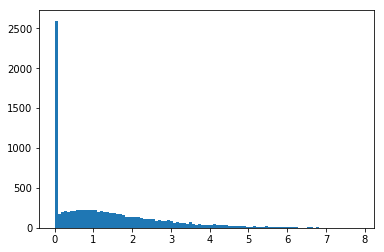

In [70]:
_= plt.hist(delta_mag, bins = 100)

In [71]:
len(np.where(delta_mag == 0)[0])

2422

In [72]:
len(delta_mag)

10000

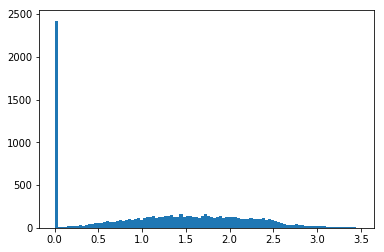

In [73]:
_= plt.hist(delta_r, bins = 100)

In [57]:
len(np.where(delta_r == 0)[0])

2422

In [ ]:
def delta_min(shift,mag):#(shift_path, mag_path):
    #mag =np.load(mag_path)
    #shift =np.load(shift_path)
    
    #Reshape the list of shifts so that it is easily usable
    shifts = np.zeros((len(shift),3,2))
    mags = np.zeros((len(shift),4))

    for i in range (len(shift)):
        for j in range (len(shift[i])):
            shifts[i][j] = shift[i][j]
        for j in range (len(mag[i])):
            mags[i][j] = mag[i][j]

    # set lists
    deltas_r= np.zeros((len(shift),3))
    delta_r= np.zeros((len(shift)))

    deltas_mag= np.zeros((len(shift),3))
    delta_mag = np.zeros((len(shift)))

    # compute the delta r for each couple of galaxies
    for i in range (3):
        deltas_r[:,i] = np.sqrt(np.square(shifts[:,i,0])+np.square(shifts[:,i,1]))
        deltas_mag[:,i] = mags[:,i+1] - mags[:,0]

    # Take the min of the non zero delta r
    for j in range (len(shifts)):
        # If all the deta_r are equals to 0 (there is only on galaxy on the image) then write 0
        if (deltas_r[j,:].any() == 0):
            delta_r[j] = 0
            delta_mag[j] = 0
        else:
            x = np.where(deltas_r[j] == 0)[0]
            deltas = np.delete(deltas_r[j],x)
            delta_r[j] = np.min(deltas)
            y = np.where(deltas == np.min(deltas))[0]
            delta_mag[j] = deltas_mag[j,y]  
        
    
    return delta_r, delta_mag

In [16]:
def delta_min(shift_path, mag_path):
    mag =np.load(mag_path)
    shift =np.load(shift_path)
    
    #Reshape the list of shifts so that it is easily usable
    shifts = np.zeros((len(shift),3,2))
    mags = np.zeros((len(shift),4))

    for i in range (len(shift)):
        for j in range (len(shift[i])):
            shifts[i][j] = shift[i][j]
        for j in range (len(mag[i])):
            mags[i][j] = mag[i][j]

    # set lists
    deltas_r= np.zeros((len(shift),3))
    delta_r= np.zeros((len(shift)))

    deltas_mag= np.zeros((len(shift),3))
    delta_mag = np.zeros((len(shift)))

    # compute the delta r for each couple of galaxies
    mag_min = np.min(mags)
    for i in range (3):
        mag_min = np.min(mags)
        deltas_r[:,i] = np.sqrt(np.square(shifts[:,i,0])+np.square(shifts[:,i,1]))
        deltas_mag[:,i] = mags[:,i+1] - mags[:,0]

    # Take the min of the non zero delta r
    for j in range (len(shifts)):
        # If all the deta_r are equals to 0 (there is only on galaxy on the image) then write 0
        if (deltas_r[j,:].any() == 0):
            delta_r[j] = 0
            delta_mag[j] = 0
        else:
            x = np.where(deltas_r[j] == 0)[0]
            deltas = np.delete(deltas_r[j],x)
            delta_r[j] = np.min(deltas)
            y = np.where(deltas == np.min(deltas))[0]
            delta_mag[j] = deltas_mag[j,y]  
            
    return delta_r, delta_mag

# Batch generation

In [23]:
list_of_samples = ['/sps/lsst/users/barcelin/data/blended/COSMOS/uni25/galaxies_COSMOS_test_2_v5.npy']#/sps/lsst/users/barcelin/data/blended/COSMOS/galaxies_COSMOS_test_2_v4.npy

In [24]:
list_of_shifts = ['/sps/lsst/users/barcelin/data/blended/COSMOS/uni25/galaxies_COSMOS_test_shift_v5.npy']

In [25]:
bands = [4,5,6,7,8,9]

In [26]:
batch_gen = BatchGenerator_test(bands, list_of_samples,total_sample_size=10000, batch_size= 100, magnitude = mag, shift = shift, training_or_validation = 'validation', noisy = True)#_lsst_process

### test reproduction de deblending

In [152]:
test = np.load('/sps/lsst/users/barcelin/data/blended/COSMOS/galaxies_COSMOS_test_2_v5.npy', mmap_mode = "c")

In [153]:
test.shape

(10000, 2, 10, 64, 64)

In [154]:
input_noiseless = np.transpose(test[:100,0,4:], axes = (0,2,3,1))
input_noisy = np.transpose(utils.norm(test[:100,1,4:],bands), axes = (0,2,3,1))

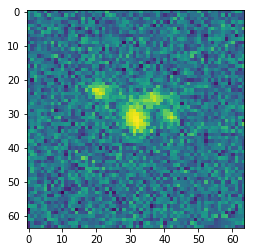

In [155]:
plt.imshow(input_noisy[0][:,:,2])

In [156]:
output_deblender_lsst = deblender.predict(input_noisy, batch_size = 100)
output_deblender_lsst_denorm = utils.denorm(output_deblender_lsst, bands, channel_last = True)

In [157]:
input_noisy_denorm = utils.denorm(input_noisy, bands, channel_last = True)

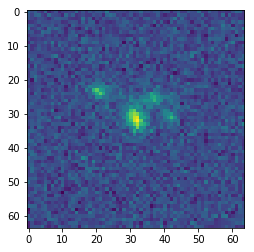

In [158]:
plt.imshow(input_noisy_denorm[0][:,:,2])

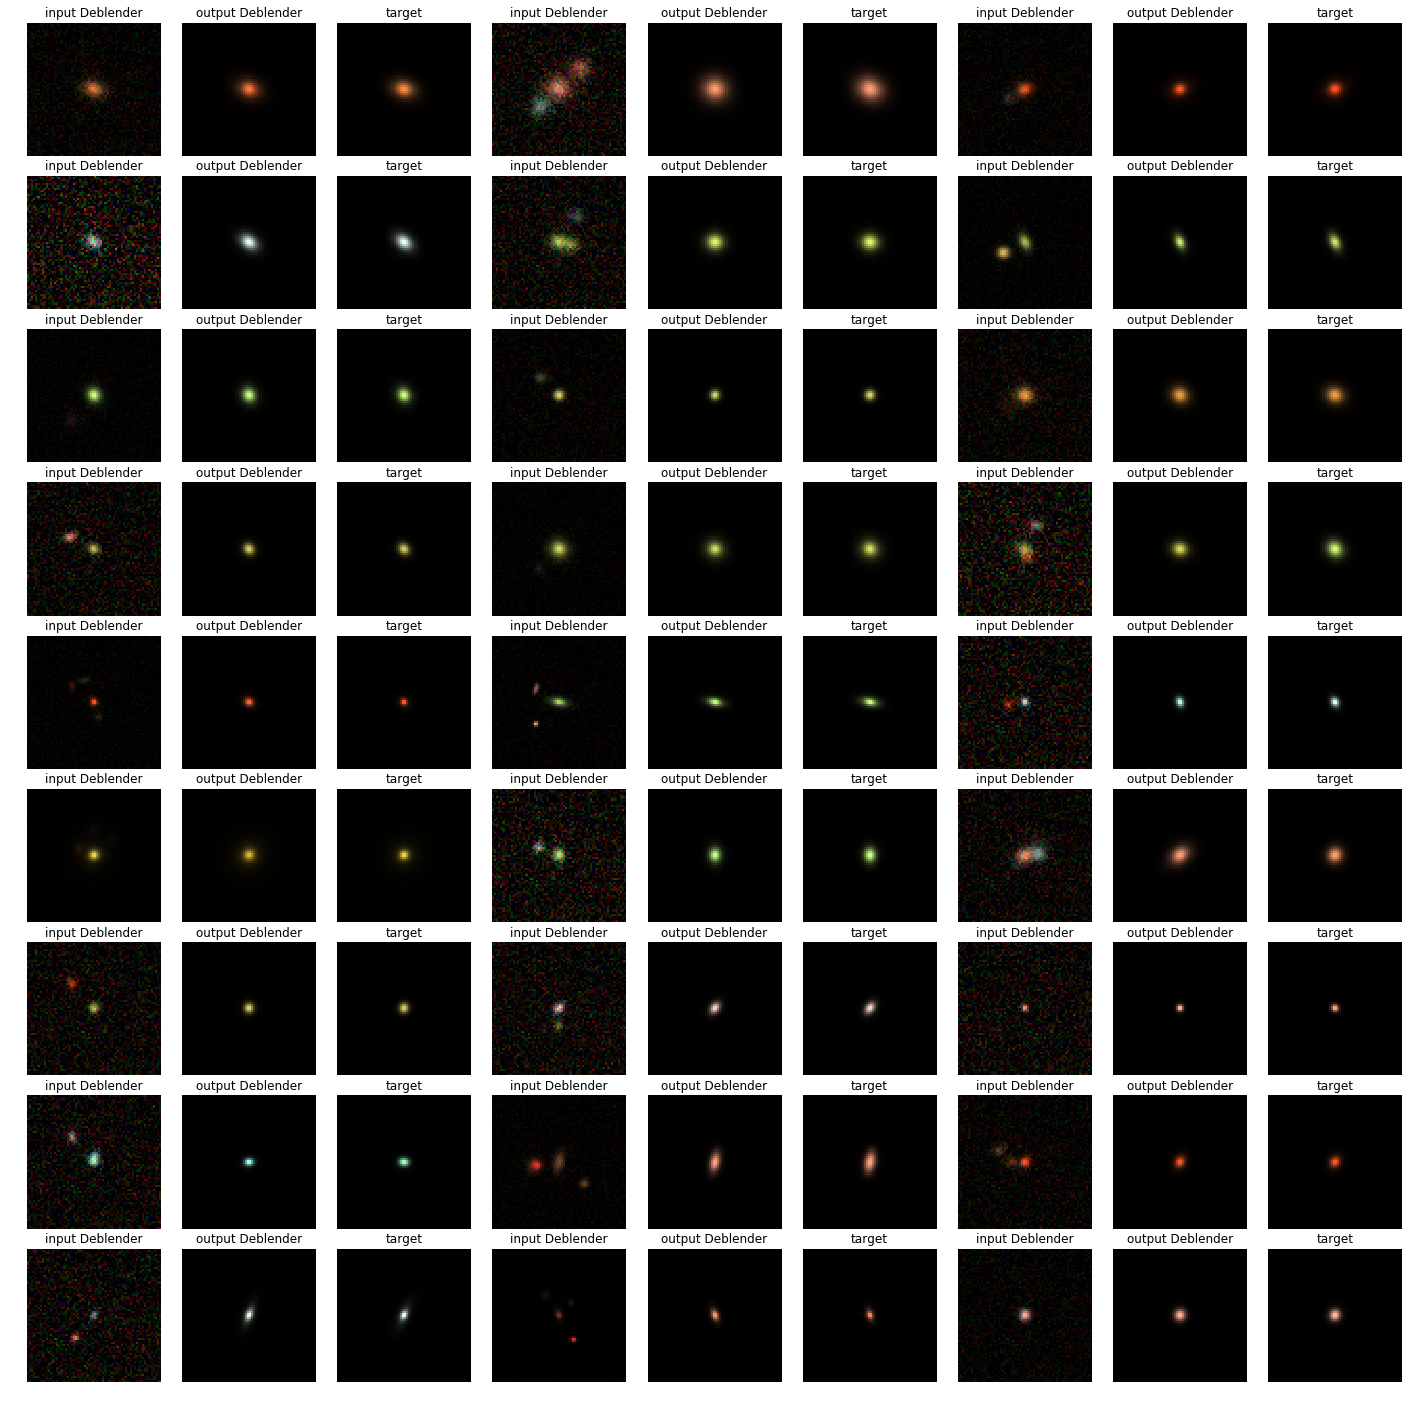

In [159]:
N_plot = 9
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)


for i in range(N_plot):
    for j in range(0,N_plot,3):
        plot_rgb_lsst(input_noisy_denorm[indices[i*N_plot+j]],stamp_size, axes[i,j])
        plot_rgb_lsst(output_deblender_lsst_denorm[indices[i*N_plot+j]],stamp_size, axes[i,j+1])
        plot_rgb_lsst(input_noiseless[indices[i*N_plot+j]],stamp_size, axes[i,j+2])

        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

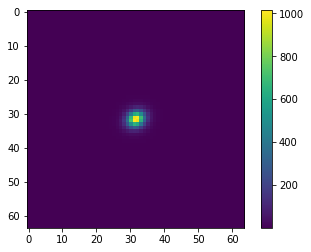

In [177]:
plt.imshow(output_deblender_lsst[10][:,:,2])
plt.colorbar()

In [178]:
#input_noisy = np.transpose(utils.norm(test[:100,1,4:],bands), axes = (0,2,3,1))
output_deblender_lsst_2 = deblender.predict(norm(input_noisy,bands,channel_last =True), batch_size = 100)

output_deblender_lsst_2 = denorm(output_deblender_lsst_2, bands, channel_last = True)

input_noisy = utils.denorm(input_noisy, bands, channel_last = True)

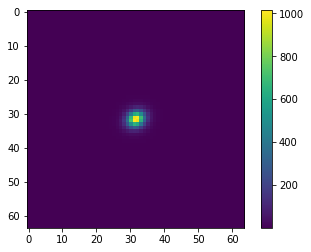

In [179]:
plt.imshow(output_deblender_lsst_2[10][:,:,2])
plt.colorbar()

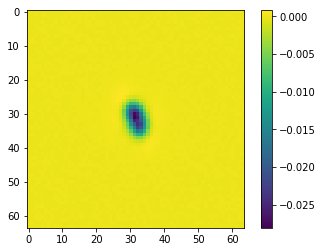

In [180]:
plt.imshow(output_deblender_lsst_2[0][:,:,2]-output_deblender_lsst[0][:,:,2])
plt.colorbar()

## LSST only

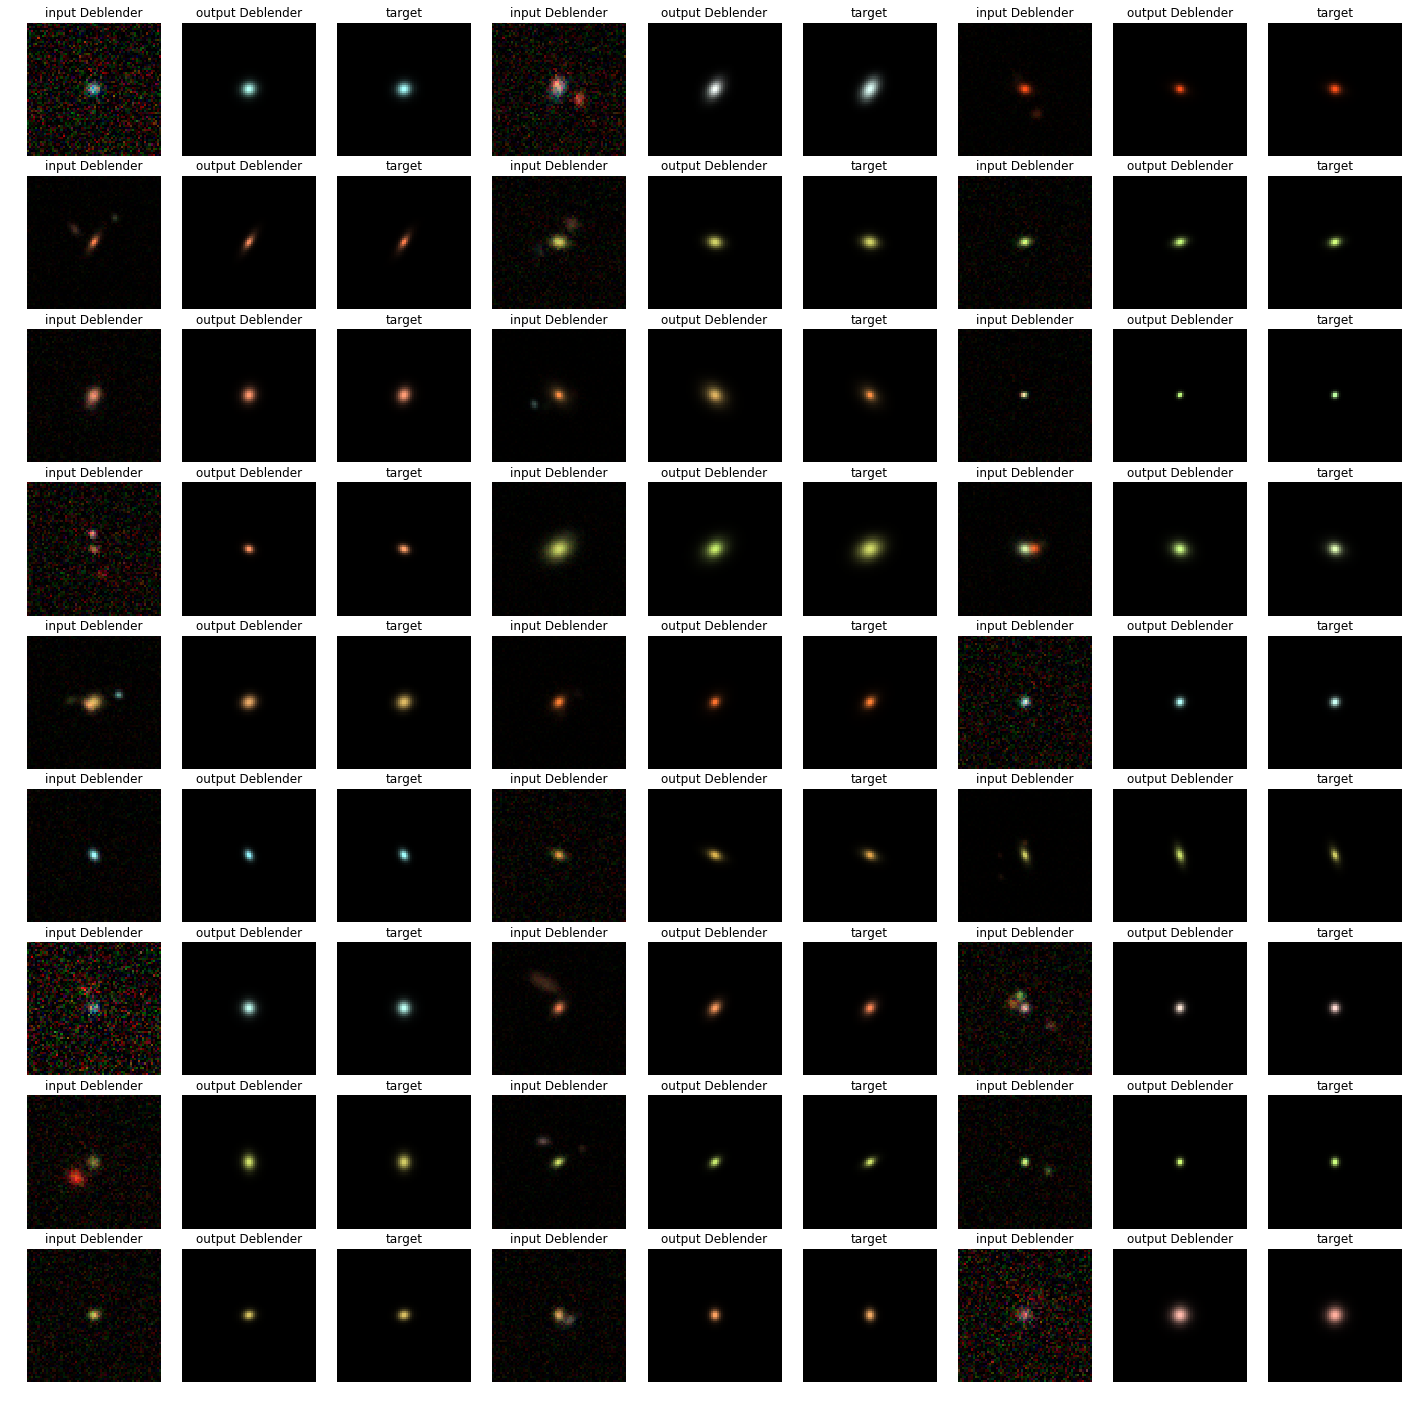

In [26]:
N_plot = 9
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_lsst = batch_gen.__getitem__(2)
input_noisy = input_lsst[0]
input_noiseless = input_lsst[1]

output_deblender_lsst = deblender.predict(input_lsst[0], batch_size = 100)

output_deblender_lsst = denorm(output_deblender_lsst, bands, channel_last = True)
input_noisy = denorm(input_noisy, bands, channel_last = True)
input_noiseless = denorm(input_noiseless, bands, channel_last = True)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        plot_rgb_lsst(input_noisy[indices[i*N_plot+j]],stamp_size, axes[i,j])#input_vae
        plot_rgb_lsst(output_deblender_lsst[indices[i*N_plot+j]],stamp_size, axes[i,j+1])#output_vae
        plot_rgb_lsst(input_noiseless[indices[i*N_plot+j]],stamp_size, axes[i,j+2])#output_vae

        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

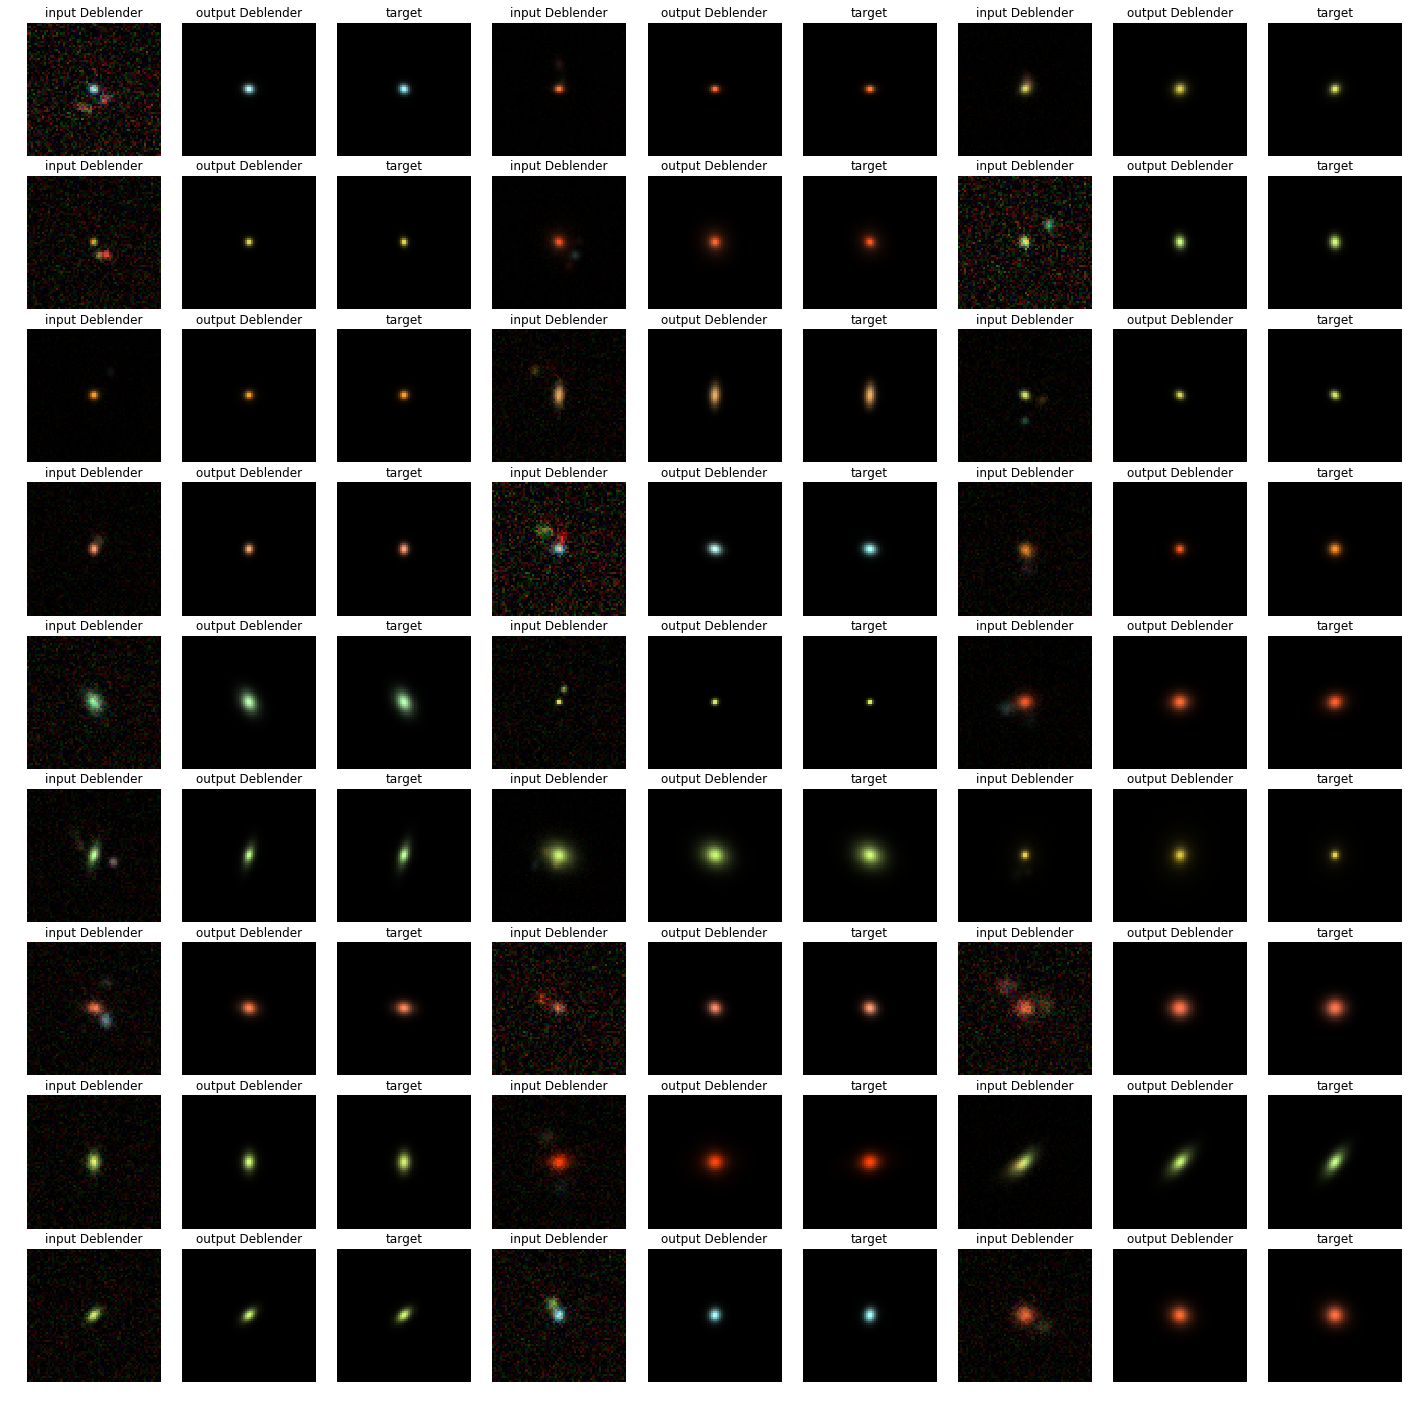

In [56]:
N_plot = 9
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_lsst = batch_gen.__getitem__(2)
input_noisy = input_lsst[0]
input_noiseless = input_lsst[1]

output_deblender_lsst = deblender.predict(input_lsst[0], batch_size = 100)

output_deblender_lsst = denorm(output_deblender_lsst, bands, channel_last = True)
input_noisy = denorm(input_noisy, bands, channel_last = True)
input_noiseless = denorm(input_noiseless, bands, channel_last = True)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        plot_rgb_lsst(input_noisy[indices[i*N_plot+j]],stamp_size, axes[i,j])#input_vae
        plot_rgb_lsst(output_deblender_lsst[indices[i*N_plot+j]],stamp_size, axes[i,j+1])#output_vae
        plot_rgb_lsst(input_noiseless[indices[i*N_plot+j]],stamp_size, axes[i,j+2])#output_vae

        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

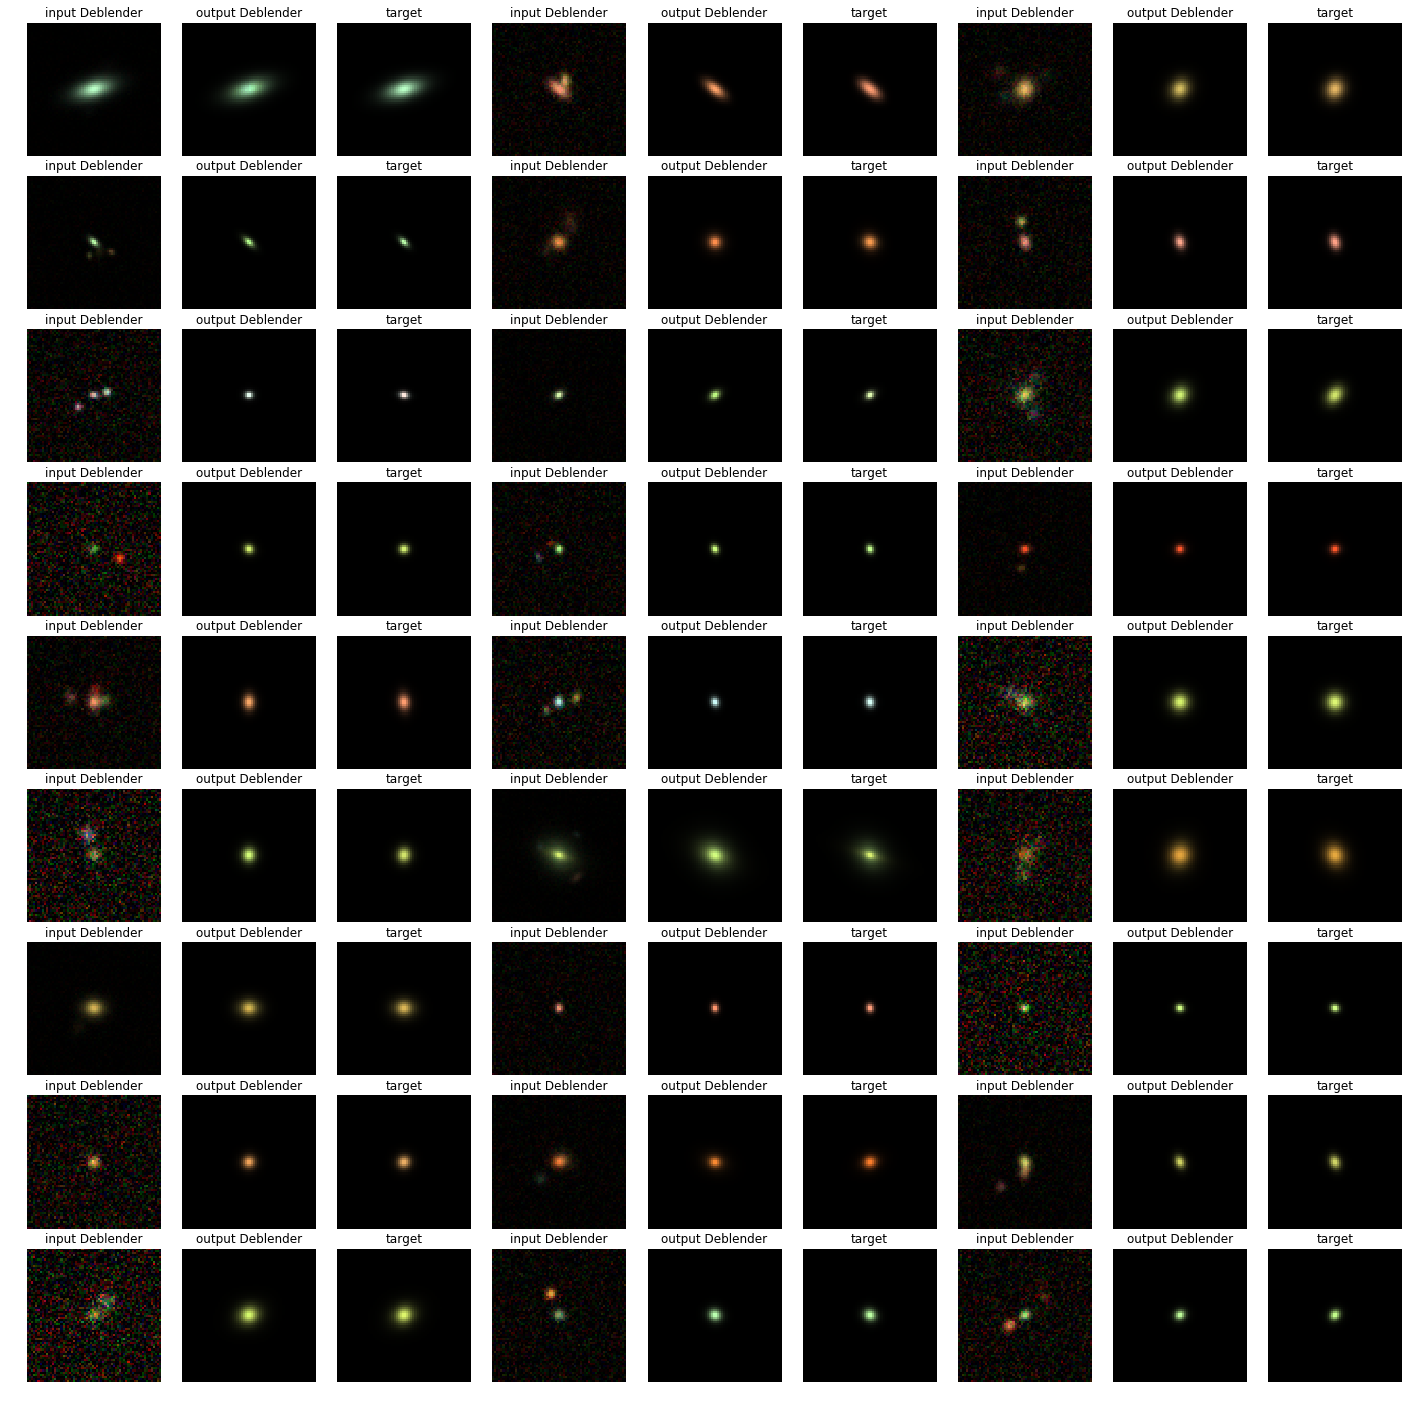

In [28]:
N_plot = 9
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_lsst = batch_gen.__getitem__(2)
input_noisy = input_lsst[0]
input_noiseless = input_lsst[1]

output_deblender_lsst = deblender.predict(input_lsst[0], batch_size = 100)

output_deblender_lsst = denorm(output_deblender_lsst, bands, channel_last = True)
input_noisy = denorm(input_noisy, bands, channel_last = True)
input_noiseless = denorm(input_noiseless, bands, channel_last = True)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        plot_rgb_lsst(input_noisy[indices[i*N_plot+j]],stamp_size, axes[i,j])#input_vae
        plot_rgb_lsst(output_deblender_lsst[indices[i*N_plot+j]],stamp_size, axes[i,j+1])#output_vae
        plot_rgb_lsst(input_noiseless[indices[i*N_plot+j]],stamp_size, axes[i,j+2])#output_vae

        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

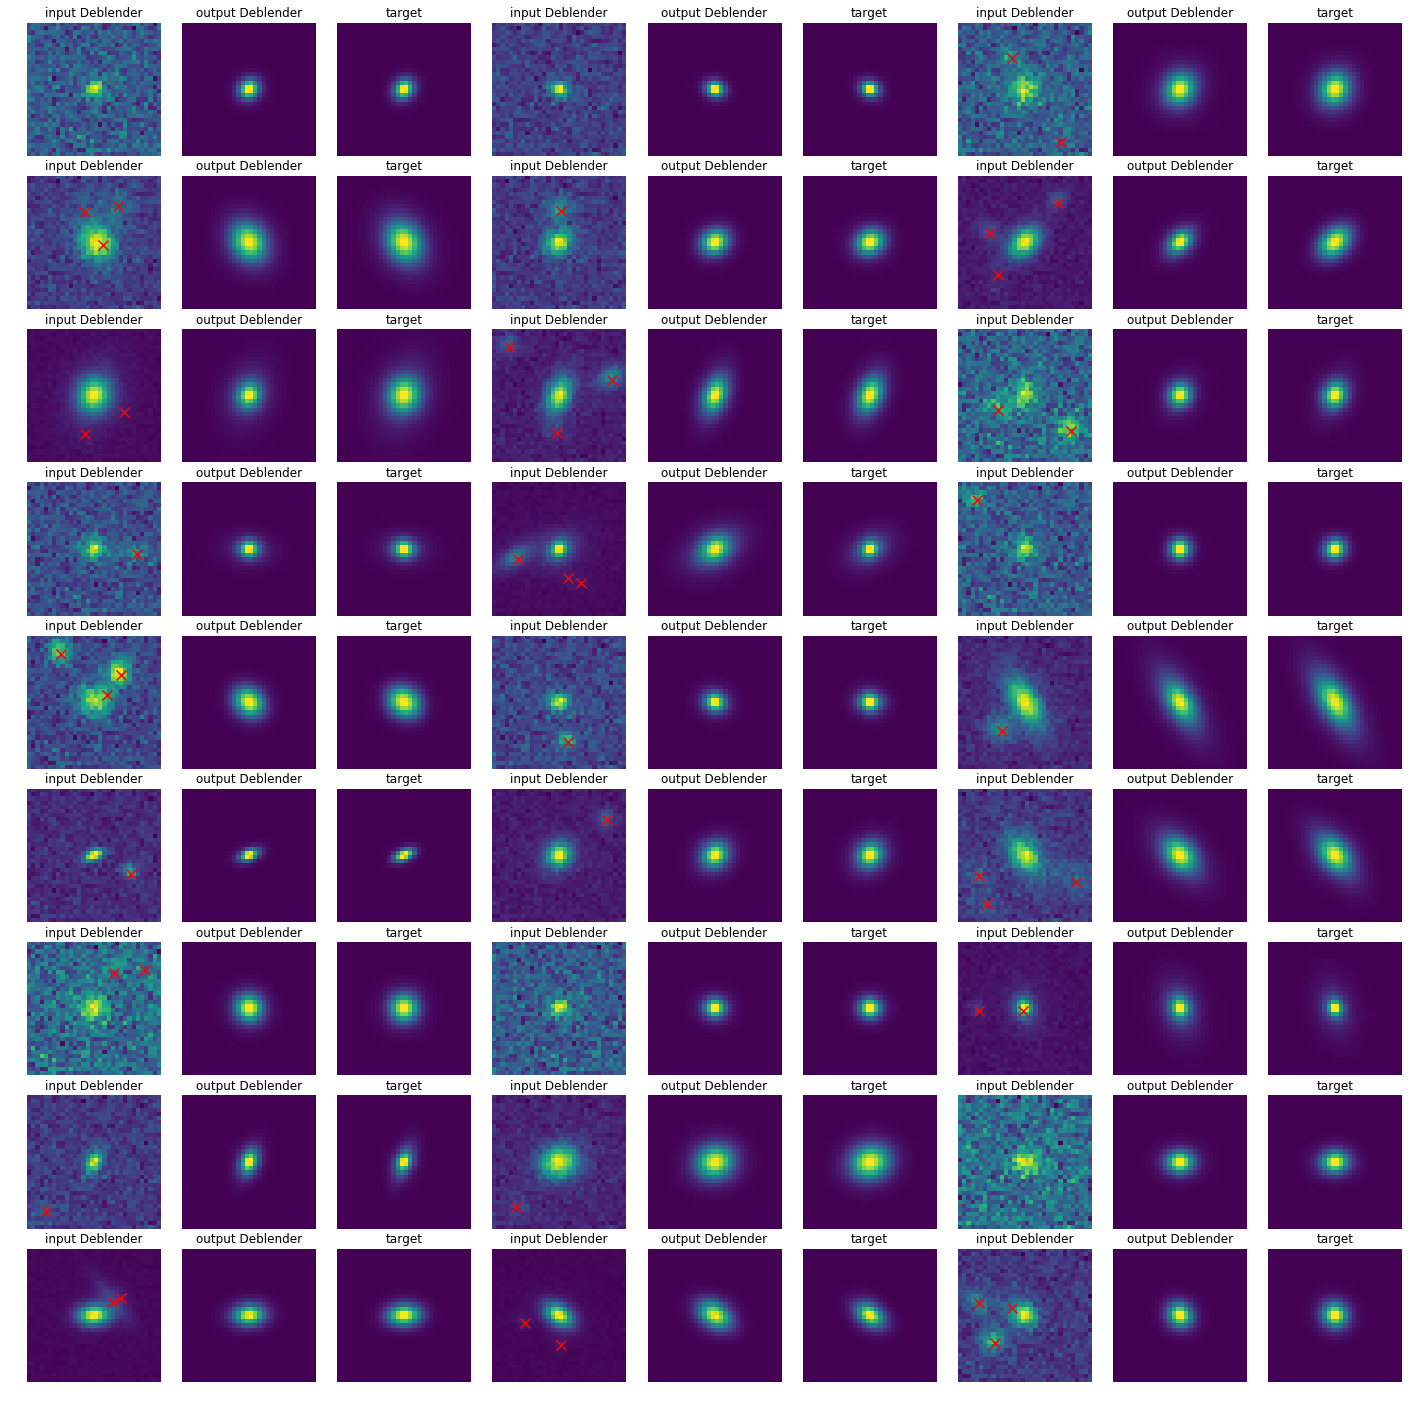

In [20]:
N_plot = 9
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_lsst = batch_gen.__getitem__(2)
input_noisy = input_lsst[0]
input_noiseless = input_lsst[1]

output_deblender_lsst = deblender.predict(input_lsst[0], batch_size = 100)

output_deblender_lsst = denorm(output_deblender_lsst, bands, channel_last = True)
input_noisy = denorm(input_noisy, bands, channel_last = True)
input_noiseless = denorm(input_noiseless, bands, channel_last = True)

mag = input_lsst[2]
shift = input_lsst[3]

for i in range(N_plot):
    for j in range(0,N_plot,3):
        axes[i,j].imshow(input_noisy[indices[i*N_plot+j]][16:48,16:48,2])
        
        for k in range (len(shift[indices[i*N_plot+j]])):
            axes[i,j].scatter(16+shift[indices[i*N_plot+j]][k][0]/0.2, 16+shift[indices[i*N_plot+j]][k][1]/0.2,s = 100,c='red', marker='x')

        axes[i,j+1].imshow(output_deblender_lsst[indices[i*N_plot+j]][16:48,16:48,2])
        axes[i,j+2].imshow(input_noiseless[indices[i*N_plot+j]][16:48,16:48,2])
        
        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')
        
        

# Shape reproduction

In [19]:
im_size = 64

batch_size =100
# see LSST Science Book
pix_scale = 0.2 #arcseconds
PSF_fwhm = 0.1
PSF_beta = 2.5

psf = galsim.Moffat(fwhm=PSF_fwhm, beta=PSF_beta)
psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

band = 'i'

ellipticities = []
magnitudes = []
deltas_r = []
deltas_m = []

for j in range(100):
    a = batch_gen.__getitem__(2)
    output_vae = deblender.predict(a[0], batch_size = batch_size)
    output_vae = denorm(output_vae, bands, channel_last = True)
    input_noiseless = denorm(a[1], bands, channel_last = True)

    for i in range (len(a[0])):#a[0] test
        try: 
            gal_image = galsim.Image(input_noiseless[i][:,:,2])
            gal_image.scale = pix_scale

            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_in = [res.corrected_e1, res.corrected_e2]

            gal_image = galsim.Image(output_vae[i][:,:,2])
            gal_image.scale = pix_scale

            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_out = [res.corrected_e1, res.corrected_e2]

            ellipticities.append([e_in, e_out])

            magnitudes.append(a[2])
            
        except :
            print('error for galaxy '+str(j*100+i))
            pass
        continue
          
    delta_r = a[4] 
    delta_mag = a[5]
    deltas_r.append(delta_r)
    deltas_m.append(delta_mag)

ellipticities_r_band = np.array(ellipticities)
magnitudes = np.array(magnitudes)
delta_r_arr = np.array(deltas_r)
delta_mag_arr = np.array(deltas_m)

100 [[0.         0.         0.        ]
 [3.57769512 4.24227361 4.72708167]
 [0.21870372 0.94583777 0.        ]
 [0.705543   0.57646592 0.        ]
 [0.         0.         0.        ]
 [1.57817429 3.463218   3.21841085]
 [0.         0.         0.        ]
 [1.45250126 1.80981547 0.        ]
 [0.76669054 2.08493574 0.        ]
 [2.40538452 1.95400738 0.        ]
 [2.52201891 0.         0.        ]
 [1.31434082 0.94337668 0.        ]
 [1.80838501 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [1.30345947 1.97353218 0.10378943]
 [0.57932002 0.         0.        ]
 [0.30359053 0.97352824 0.        ]
 [0.14079569 1.59140783 1.52154166]
 [1.14674098 0.         0.        ]
 [0.0372623  0.         0.        ]
 [0.83631617 1.02039748 0.87253182]
 [2.69952939 2.23386936 0.        ]
 [1.20964475 0.         0.        ]
 [0.         0.         0.        ]
 [0.24271191 0.41682543 0.48601054]
 [1.87807434 1.72421221 0.        ]
 [0.         0.         

100 [[0.         0.         0.        ]
 [1.85844147 0.1654368  0.        ]
 [1.45438437 0.         0.        ]
 [5.68372225 5.35424537 4.10510667]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.43416483 1.86095191 0.        ]
 [0.87290803 0.19583927 0.        ]
 [2.50916244 1.38926853 1.9619028 ]
 [1.80857123 0.         0.        ]
 [0.60277925 0.         0.        ]
 [1.30710971 2.15501709 0.44096432]
 [0.41558402 0.97565183 0.        ]
 [1.27112286 4.22822285 0.        ]
 [0.41445954 0.         0.        ]
 [0.         0.         0.        ]
 [1.10744913 0.40675749 0.76835279]
 [1.02685244 0.         0.        ]
 [0.97585074 0.64078974 2.26331524]
 [0.         0.         0.        ]
 [0.27742016 0.50055074 0.        ]
 [0.98434335 0.         0.        ]
 [1.51648591 0.38660628 1.0243272 ]
 [2.69720415 2.7467605  2.58502227]
 [2.28896154 2.19335775 3.01161933]
 [0.8899736  0.31416538 0.        ]
 [0.         0.         

100 [[1.91452455 1.93329073 2.36833449]
 [0.         0.         0.        ]
 [1.46672674 0.93564782 0.        ]
 [1.19990021 1.28297295 0.        ]
 [2.68555625 0.         0.        ]
 [2.13972018 3.58667139 0.        ]
 [3.12912134 5.45875107 1.51480451]
 [1.09707783 2.76681225 1.25492963]
 [0.38987553 0.         0.        ]
 [0.         0.         0.        ]
 [4.71287404 3.68354671 2.21474873]
 [2.01989979 0.67255178 0.        ]
 [0.         0.         0.        ]
 [1.61529781 0.         0.        ]
 [0.82410112 0.         0.        ]
 [0.57994924 0.25069533 0.213095  ]
 [1.97924141 1.68194379 1.42048466]
 [0.         0.         0.        ]
 [1.53240876 0.48708946 0.        ]
 [1.70919889 1.23430389 1.78708697]
 [1.35819519 0.         0.        ]
 [1.20249274 0.         0.        ]
 [0.31213505 0.         0.        ]
 [0.         0.         0.        ]
 [3.82726797 3.23632053 0.65491452]
 [0.         0.         0.        ]
 [0.95899646 0.79095274 0.        ]
 [2.21022348 0.26853084 

100 [[2.43296353 1.64915832 2.34443452]
 [0.         0.         0.        ]
 [1.17257395 0.75977172 0.89293653]
 [3.10783671 0.52464374 3.48993593]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.39713776 0.         0.        ]
 [2.09975037 1.05965951 0.        ]
 [0.28806663 0.         0.        ]
 [0.         0.         0.        ]
 [1.60503974 1.15412632 0.        ]
 [1.74149373 0.         0.        ]
 [4.48397984 2.27295107 2.22023758]
 [2.54306144 1.39882418 0.        ]
 [0.95096517 0.         0.        ]
 [0.143801   0.51325278 1.83653399]
 [1.75894442 3.03737354 0.        ]
 [0.31384673 0.2406051  0.        ]
 [0.04202949 2.42888504 0.        ]
 [0.02853721 0.92881684 1.53892742]
 [1.80940409 0.23481807 3.36460923]
 [1.82655626 2.92015238 0.        ]
 [0.         0.         0.        ]
 [0.45330957 2.21325158 0.        ]
 [5.61594755 0.         0.        ]
 [0.76651596 0.98148764 0.93281322]
 [0.30204037 0.         0.        ]
 [1.28902812 0.6539984  

100 [[0.         0.         0.        ]
 [2.00941973 3.14879413 2.39052857]
 [0.38181544 0.         0.        ]
 [0.10051462 0.         0.        ]
 [0.         0.         0.        ]
 [2.4214754  2.74308577 0.        ]
 [0.90921734 0.54842049 0.        ]
 [2.19749504 0.         0.        ]
 [1.56976266 0.39642392 0.505103  ]
 [0.03975702 0.         0.        ]
 [1.61529781 0.         0.        ]
 [4.9680311  3.00606862 0.        ]
 [0.79840708 0.35537165 0.        ]
 [1.18378122 1.64181627 0.        ]
 [0.99726703 0.         0.        ]
 [0.67006976 0.         0.        ]
 [2.84920348 2.24095898 2.69978393]
 [0.28157586 0.23554023 0.        ]
 [5.6575442  4.17674365 3.25465563]
 [0.         0.         0.        ]
 [0.59464066 1.81548805 0.        ]
 [0.82846627 1.49604239 1.06617296]
 [0.38740527 0.         0.        ]
 [1.0103318  0.         0.        ]
 [4.12495873 0.         0.        ]
 [0.64323184 0.67507423 0.        ]
 [1.4714152  0.24389488 0.        ]
 [2.79914078 2.59735808 

100 [[1.03781569 0.         0.        ]
 [1.5140449  1.05457492 0.        ]
 [1.58860445 0.         0.        ]
 [0.70813817 0.         0.        ]
 [2.72896771 0.         0.        ]
 [2.12499056 0.         0.        ]
 [5.04748175 5.31061466 0.        ]
 [0.         0.         0.        ]
 [3.53990988 4.10771875 4.11074265]
 [2.41736646 0.         0.        ]
 [0.23767445 0.57218715 0.        ]
 [3.23703172 2.63189099 1.26415248]
 [0.         0.         0.        ]
 [0.34210996 0.         0.        ]
 [0.10947689 0.         0.        ]
 [0.32811168 0.3460462  0.        ]
 [0.55872957 1.90875671 0.50334074]
 [2.57656622 0.         0.        ]
 [4.54512021 3.35065765 2.25977702]
 [0.95654012 0.         0.        ]
 [0.12297348 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.28852584 0.         0.        ]
 [3.88385981 3.52424166 3.72826811]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.4638304  0.81111131 

100 [[6.26339517 3.70033919 4.94065683]
 [0.02075114 0.         0.        ]
 [0.         0.         0.        ]
 [0.74406301 0.         0.        ]
 [0.         0.         0.        ]
 [0.6645599  0.33466044 0.        ]
 [0.81099606 0.         0.        ]
 [3.22017932 2.99040402 2.31362086]
 [1.64731441 0.         0.        ]
 [0.32366409 4.82417341 3.1397178 ]
 [3.73561343 3.38781268 1.98610555]
 [2.7222769  0.         0.        ]
 [0.         0.         0.        ]
 [3.75984494 3.28254162 0.        ]
 [0.65284324 0.82708826 0.        ]
 [1.26191067 0.53953552 0.        ]
 [2.71587422 4.22177931 0.        ]
 [2.74938266 2.44833718 1.80560515]
 [1.49719916 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.90219562 0.         0.        ]
 [0.         0.         0.        ]
 [1.23717775 1.33275896 1.06351413]
 [1.14526244 0.         0.        ]
 [0.2964188  0.         

100 [[1.67751787 2.7355402  0.        ]
 [0.60207711 0.         0.        ]
 [3.37452649 2.8528158  4.57882177]
 [0.60947908 2.26332002 0.        ]
 [0.95108031 0.83300524 0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [2.26099322 2.72522036 1.78183914]
 [0.11789538 0.         0.        ]
 [0.60530391 0.         0.        ]
 [2.76707682 5.12834309 3.87120326]
 [4.08865767 5.07296253 0.        ]
 [0.93516468 1.0247303  0.64782555]
 [2.10687806 2.19036244 1.42484657]
 [2.01278042 4.31815948 3.58016749]
 [2.37113593 2.79373131 3.97953841]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [1.51005901 1.83940999 1.72355472]
 [3.56008627 0.         0.        ]
 [2.28969676 2.67901686 3.64169405]
 [0.         0.         0.        ]
 [0.48146352 0.45817036 0.        ]
 [0.         0.         0.        ]
 [2.89302533 3.5182298  2.23862315]
 [0.43879019 1.3135113  0.        ]
 [0.         0.         0.        ]
 [1.51648591 0.38660628 

100 [[0.86517977 0.71967158 0.89286968]
 [2.36216895 2.21868694 0.        ]
 [0.         0.         0.        ]
 [1.57176108 1.58204453 0.        ]
 [1.14655677 0.         0.        ]
 [0.67304456 0.         0.        ]
 [3.0015329  0.         0.        ]
 [1.00947864 0.         0.        ]
 [0.67883325 0.21626023 1.26935644]
 [0.         0.         0.        ]
 [1.15842258 0.         0.        ]
 [2.1314343  0.         0.        ]
 [2.9309264  3.21757977 3.02807578]
 [1.44167368 0.         0.        ]
 [0.01438002 0.         0.        ]
 [0.         0.         0.        ]
 [0.21958286 0.         0.        ]
 [1.09993521 0.12907725 0.51334973]
 [0.81655902 0.         0.        ]
 [2.06801591 2.84300981 0.        ]
 [4.00510754 3.88165044 4.29838094]
 [0.32459204 0.32936481 0.        ]
 [2.14389377 1.68565102 5.54535065]
 [0.         0.         0.        ]
 [1.74270006 0.         0.        ]
 [2.96122624 0.         0.        ]
 [0.995228   0.         0.        ]
 [2.20426464 0.         

100 [[1.08621232 1.45129485 1.83906708]
 [4.51959849 3.56071395 0.        ]
 [1.39826164 0.         0.        ]
 [2.04844767 0.95783017 0.        ]
 [4.1440926  1.69158744 4.02217297]
 [1.37016971 0.92484045 0.        ]
 [0.         0.         0.        ]
 [0.63924017 1.61441703 0.0749256 ]
 [0.84762316 0.         0.        ]
 [1.65164261 0.         0.        ]
 [2.77207184 1.57122837 3.03698979]
 [1.33421101 2.04759499 1.31478137]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [1.18443987 0.         0.        ]
 [0.38071651 0.17732129 0.        ]
 [0.30359053 0.97352824 0.        ]
 [2.76707682 5.12834309 3.87120326]
 [0.         0.         0.        ]
 [1.74198783 2.15177514 0.51087033]
 [0.48699497 0.         0.        ]
 [2.93942764 1.99240851 3.12331013]
 [6.49249929 0.         0.        ]
 [5.42787978 6.1090904  0.        ]
 [2.1247198  0.         0.        ]
 [0.26456386 1.19490046 0.89929013]
 [5.55903656 5.17511326 0.        ]
 [0.3704463  0.56725319 

100 [[2.26859954 0.11236489 2.23640157]
 [1.78460114 1.95383932 0.        ]
 [0.         0.         0.        ]
 [0.48173585 1.12176724 0.        ]
 [1.47373305 0.39106178 0.        ]
 [2.04364509 2.50576661 3.3378155 ]
 [0.1976275  0.         0.        ]
 [1.01035994 0.         0.        ]
 [2.1276717  2.55403023 2.3453373 ]
 [5.88500162 2.59369182 0.        ]
 [1.48536695 0.59373746 1.54271476]
 [4.70763161 0.         0.        ]
 [0.8525178  0.2460472  0.        ]
 [0.         0.         0.        ]
 [4.09960167 4.4551003  0.        ]
 [0.         0.         0.        ]
 [1.30791484 0.         0.        ]
 [0.82608401 0.         0.        ]
 [0.6316411  0.         0.        ]
 [0.85372443 1.87643691 0.        ]
 [0.5893636  0.         0.        ]
 [3.580449   2.11295927 3.12721006]
 [0.70644878 0.31960662 0.        ]
 [0.1299074  1.10998951 0.        ]
 [1.04699582 0.         0.        ]
 [0.53153785 0.         0.        ]
 [0.83853278 0.         0.        ]
 [0.45150493 0.65106151 

100 [[1.43494375 0.1912887  0.        ]
 [7.29748819 5.90087243 0.        ]
 [2.82116913 4.06884995 0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [2.79914078 2.59735808 3.21457891]
 [1.80508979 2.83590207 1.27372925]
 [0.38696074 0.52171958 0.48587735]
 [3.25816768 2.34863033 3.64348928]
 [1.36445986 2.80039793 1.11508801]
 [0.55908157 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [2.35081048 0.         0.        ]
 [0.72078312 2.34300711 0.        ]
 [1.18354286 0.79583896 0.        ]
 [0.         0.         0.        ]
 [5.15637897 3.84830952 4.0838864 ]
 [0.         0.         0.        ]
 [0.84502634 2.28901052 0.        ]
 [2.24912388 1.42632634 0.        ]
 [3.72717114 0.         0.        ]
 [0.         0.         0.        ]
 [0.52485828 0.40614707 1.12768828]
 [1.58401194 0.         0.        ]
 [5.5917832  3.87007264 

100 [[0.52686098 0.88583334 0.91011662]
 [0.         0.         0.        ]
 [1.31764263 1.1572892  0.        ]
 [1.23717775 1.33275896 1.06351413]
 [2.01311993 3.07271945 0.        ]
 [1.74487192 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [3.17751609 2.17165764 0.        ]
 [2.43338932 0.8139594  2.62130666]
 [0.29467934 0.48434456 0.        ]
 [0.         0.         0.        ]
 [1.53283263 0.         0.        ]
 [0.         0.         0.        ]
 [2.02387997 2.89067272 3.37911113]
 [0.77190966 1.69157508 1.03611623]
 [0.         0.         0.        ]
 [0.02683962 0.         0.        ]
 [2.3608697  1.83622024 0.3183473 ]
 [2.99441181 2.57519895 1.98919264]
 [3.04411776 0.         0.        ]
 [1.00168859 0.84809464 0.        ]
 [0.         0.         0.        ]
 [3.80535467 0.         0.        ]
 [0.7657004  0.         0.        ]
 [1.38225318 0.25767104 0.        ]
 [0.81880634 0.82986237 0.        ]
 [0.84240728 0.02832821 

100 [[8.62407094e-01 2.53871115e+00 0.00000000e+00]
 [1.46385700e+00 2.83142873e-01 1.37444609e+00]
 [4.40167512e-01 1.39181828e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.41640059e+00 4.53465328e-01 0.00000000e+00]
 [3.96721938e+00 4.43495043e+00 0.00000000e+00]
 [3.58090717e+00 1.66455955e+00 1.05961528e+00]
 [1.24897168e+00 1.95943149e+00 3.82252269e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.20195374e+00 3.41123398e+00 3.85677277e+00]
 [1.64025763e+00 1.97611784e+00 0.00000000e+00]
 [3.22735595e+00 1.72779467e+00 2.95581705e+00]
 [9.16554670e-01 1.40691782e-01 0.00000000e+00]
 [2.42668655e+00 0.00000000e+00 0.00000000e+00]
 [3.80850740e-02 6.81257854e-01 8.75811192e-01]
 [2.47339405e+00 4.11441679e-01 8.94320343e-01]
 [1.91047996e+00 4.55118093e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.64823501e+00 8.59077135e-01 1.71231630e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.70279588e-01 1.39732264e+00 0.00

100 [[2.34274697 1.88048384 2.14328653]
 [0.72076868 0.87373812 0.82978317]
 [0.         0.         0.        ]
 [1.00267587 0.11197282 0.        ]
 [2.06244018 1.80707178 1.77535231]
 [2.33661095 3.61777141 3.76682193]
 [1.5217836  0.77839657 0.        ]
 [0.53007618 0.         0.        ]
 [0.         0.         0.        ]
 [2.00464577 1.24633074 3.90465326]
 [2.45607582 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.59464066 1.81548805 0.        ]
 [1.98651339 2.57427731 1.96493844]
 [0.         0.         0.        ]
 [0.90105258 2.70563787 2.00936246]
 [3.80146925 1.52255735 0.        ]
 [1.5491718  0.         0.        ]
 [2.94564269 1.0360715  1.82692512]
 [1.31727654 1.64161565 0.        ]
 [1.05266707 0.         0.        ]
 [3.02348713 0.         0.        ]
 [1.50774371 1.66766449 0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         

100 [[0.         0.         0.        ]
 [3.03850458 0.         0.        ]
 [0.52757634 0.63848949 0.70371237]
 [0.32366409 4.82417341 3.1397178 ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [1.43994969 0.         0.        ]
 [0.02784808 0.         0.        ]
 [0.68684513 1.01716016 0.        ]
 [1.90461297 0.         0.        ]
 [1.46578299 0.         0.        ]
 [0.         0.         0.        ]
 [0.41380709 0.20884325 0.5035738 ]
 [6.39807395 4.99621105 6.41512454]
 [1.31903407 0.33828194 1.65077867]
 [2.39028351 2.8794543  1.9627705 ]
 [0.         0.         0.        ]
 [2.28929186 0.8970985  1.21847544]
 [1.80838501 0.         0.        ]
 [0.         0.         0.        ]
 [1.32509823 0.36804511 0.        ]
 [0.         0.         0.        ]
 [1.72933843 1.44335399 0.        ]
 [0.         0.         0.        ]
 [1.84370199 2.95678175 0.        ]
 [2.29876428 0.75260134 2.39430717]
 [1.28973307 0.         0.        ]
 [0.93557918 1.25120582 

100 [[3.35612176 0.         0.        ]
 [0.73884587 1.43956593 0.90345969]
 [0.07701105 0.         0.        ]
 [4.04437504 4.70738655 3.27143349]
 [7.08222934 3.46710601 4.17186609]
 [0.91217169 0.88285115 1.80472735]
 [6.4347768  5.49051735 2.65720956]
 [2.01278042 4.31815948 3.58016749]
 [0.         0.         0.        ]
 [2.68144354 3.83017986 3.23403094]
 [0.40991313 0.         0.        ]
 [2.05970956 1.49510636 1.51239912]
 [0.79252187 1.45117841 0.58706434]
 [0.3214861  0.31971908 0.94730972]
 [1.13479608 2.97792132 1.83945365]
 [2.12751956 2.59515538 0.        ]
 [0.6743151  1.08096776 1.13731379]
 [1.11852349 0.59004169 0.61269461]
 [0.         0.         0.        ]
 [3.5881227  2.9401953  0.        ]
 [0.27305691 0.16819931 0.        ]
 [0.58680393 0.         0.        ]
 [1.39324361 1.40059169 2.28588633]
 [1.89530442 0.         0.        ]
 [0.88618943 1.48593155 1.47963806]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         

100 [[0.69065504 1.99095154 0.        ]
 [0.         0.         0.        ]
 [1.30871423 0.         0.        ]
 [0.39815359 0.         0.        ]
 [1.60741782 0.         0.        ]
 [0.53419029 1.07033165 0.        ]
 [0.         0.         0.        ]
 [2.58889022 0.         0.        ]
 [4.51893879 3.2858307  0.        ]
 [0.         0.         0.        ]
 [2.57243221 0.         0.        ]
 [0.         0.         0.        ]
 [0.33886399 1.42908957 0.        ]
 [1.02666244 2.26113778 1.42232247]
 [2.09427545 3.03030697 0.        ]
 [1.28871964 0.77364376 0.        ]
 [0.80153519 0.         0.        ]
 [0.66455678 2.02601385 0.        ]
 [0.17050773 0.56915426 0.52691914]
 [3.56167052 4.57173963 0.        ]
 [3.63054947 2.72613584 2.88544624]
 [4.80925429 0.         0.        ]
 [0.03245822 0.         0.        ]
 [0.63649577 0.55691035 0.        ]
 [0.81816034 1.03494973 0.        ]
 [2.78940459 0.         0.        ]
 [0.         0.         0.        ]
 [0.76385201 0.         

100 [[0.96616424 0.         0.        ]
 [0.91679239 0.         0.        ]
 [0.30359053 0.97352824 0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.92992735 1.32247887 1.88048065]
 [4.26445471 0.         0.        ]
 [0.20297179 0.         0.        ]
 [0.57125154 0.         0.        ]
 [0.2950761  0.         0.        ]
 [0.59753857 0.47514242 0.        ]
 [0.         0.         0.        ]
 [1.56713395 0.         0.        ]
 [1.19209013 0.99290375 0.        ]
 [5.12383942 2.63643928 4.03438066]
 [1.12970881 0.27863299 0.17569641]
 [1.3980282  0.92718323 0.10984025]
 [2.80531981 0.         0.        ]
 [1.55597079 2.19970471 0.        ]
 [1.15836049 0.         0.        ]
 [2.69952939 2.23386936 0.        ]
 [0.87510645 0.5778     0.        ]
 [2.72332768 0.         0.        ]
 [2.26622196 1.12698494 0.        ]
 [2.17928035 0.64897915 0.        ]
 [1.00177984 1.65062976 0.        ]
 [2.16825525 0.         0.        ]
 [0.76147323 2.20553865 

100 [[0.         0.         0.        ]
 [0.         0.         0.        ]
 [2.25023963 2.18077883 2.79729061]
 [2.12181744 0.         0.        ]
 [1.51890861 0.         0.        ]
 [3.9317608  4.16470155 0.        ]
 [0.34822405 2.25204037 0.        ]
 [2.76429078 2.15491878 1.75163537]
 [2.16917446 3.48917938 0.        ]
 [0.         0.         0.        ]
 [0.32801389 1.4880793  0.        ]
 [1.36078906 1.26022999 0.95109061]
 [0.67296469 0.60319066 0.        ]
 [0.         0.         0.        ]
 [0.40318393 0.         0.        ]
 [0.         0.         0.        ]
 [1.65658756 0.88089216 0.        ]
 [2.26099322 2.72522036 1.78183914]
 [0.2167384  1.46489215 0.        ]
 [0.         0.         0.        ]
 [2.78683213 2.57166551 1.50632028]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.41265042 0.         0.        ]
 [0.         0.         0.        ]
 [2.23149867 1.18882079 0.88151655]
 [2.24561976 0.         0.        ]
 [0.         0.         

100 [[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.17098902 0.         0.        ]
 [0.8612215  1.10144336 0.        ]
 [0.         0.         0.        ]
 [0.8839981  0.         0.        ]
 [3.8251458  0.         0.        ]
 [0.69658    0.         0.        ]
 [1.80516244 0.         0.        ]
 [1.46186787 1.17829623 0.        ]
 [0.         0.         0.        ]
 [0.82698932 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [1.76361287 0.         0.        ]
 [1.7836547  2.08981839 0.        ]
 [0.33676769 1.12804808 0.        ]
 [0.         0.         0.        ]
 [0.98657143 0.36591622 0.16431167]
 [0.1534452  0.2267576  0.        ]
 [0.60137138 1.33588832 0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.41167632 0.91926705 0.97949777]
 [0.56377499 0.         0.        ]
 [3.23951316 3.20434164 0.        ]
 [0.         0.         

100 [[2.2172201  1.10421175 0.        ]
 [0.90131417 1.2359901  0.73751189]
 [0.16838153 0.         0.        ]
 [2.49634626 2.89025287 0.        ]
 [1.04915113 2.56812238 0.38332555]
 [0.         0.         0.        ]
 [0.13417891 0.         0.        ]
 [2.26660083 0.         0.        ]
 [0.         0.         0.        ]
 [2.46036326 4.49973832 4.03999478]
 [2.56083708 3.24331427 0.        ]
 [5.13346325 4.9108942  4.60350303]
 [1.70259793 1.99249349 0.        ]
 [1.9410883  1.15734383 0.        ]
 [0.0940333  0.29769451 0.        ]
 [0.0919529  0.71959418 0.35760439]
 [0.30414867 0.         0.        ]
 [0.61828701 0.47560309 0.        ]
 [2.28278706 0.         0.        ]
 [0.         0.         0.        ]
 [1.54459449 2.24653614 0.        ]
 [3.1525506  3.27102053 3.66335885]
 [2.97359441 0.         0.        ]
 [0.         0.         0.        ]
 [3.18791916 2.3618977  1.32477767]
 [0.10249789 0.47450123 3.4072806 ]
 [0.06919257 1.06400272 0.        ]
 [0.         0.         

100 [[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.45141693 0.71082903 0.44650254]
 [2.78099382 4.52895383 0.        ]
 [2.16285143 0.         0.        ]
 [2.86354013 2.0162111  1.97893782]
 [3.39807613 0.         0.        ]
 [2.57717161 1.2099159  0.        ]
 [0.5831726  0.78323916 0.84673228]
 [0.         0.         0.        ]
 [1.69641899 2.57803005 0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.18606024 0.21778506 0.88615078]
 [0.         0.         0.        ]
 [0.1398765  0.         0.        ]
 [0.         0.         0.        ]
 [1.23322545 0.         0.        ]
 [1.47239348 0.2131526  0.        ]
 [2.27982591 0.         0.        ]
 [0.         0.         0.        ]
 [1.61085963 0.         0.        ]
 [3.03205486 1.1620161  0.        ]
 [1.52837278 0.92031629 0.        ]
 [0.         0.         0.        ]
 [1.98451952 0.         

100 [[0.         0.         0.        ]
 [1.09458729 1.19240299 0.        ]
 [0.13530442 0.75863292 0.12452288]
 [3.03978423 3.09101367 0.        ]
 [3.72480017 0.         0.        ]
 [0.         0.         0.        ]
 [0.49971654 0.         0.        ]
 [3.32697001 2.88911713 3.67135842]
 [0.         0.         0.        ]
 [4.15186903 4.03241726 0.        ]
 [2.92041286 4.17700022 1.96001842]
 [2.26660083 0.         0.        ]
 [0.19684481 0.15888729 0.86704728]
 [1.75722913 1.78897792 4.25899675]
 [0.63916005 0.3490108  0.        ]
 [0.65630341 0.         0.        ]
 [0.03921003 0.         0.        ]
 [1.88506187 0.         0.        ]
 [1.19270708 2.82894145 0.        ]
 [0.         0.         0.        ]
 [2.27219381 2.6345686  0.        ]
 [0.34653725 0.9008342  0.        ]
 [0.4060469  0.0773043  0.        ]
 [1.06397777 3.65655576 2.39741885]
 [0.29444067 0.         0.        ]
 [2.44375577 1.59870077 2.97602876]
 [0.         0.         0.        ]
 [0.         0.         

100 [[0.67328464 2.22662705 0.        ]
 [2.58575471 1.47324356 1.02365298]
 [0.39551598 0.         0.        ]
 [5.66875997 2.90680338 0.        ]
 [0.44119193 0.         0.        ]
 [0.         0.         0.        ]
 [2.44689144 2.73272307 0.        ]
 [2.80035661 0.36829603 2.32120768]
 [0.61254545 0.         0.        ]
 [0.02784808 0.         0.        ]
 [3.33742534 2.94148791 0.23295848]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.19231655 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.85956818 0.         0.        ]
 [0.         0.         0.        ]
 [0.52206555 0.71277829 1.88405941]
 [3.03037371 0.60873614 0.        ]
 [2.06578339 0.         0.        ]
 [1.44684321 0.         0.        ]
 [3.50576807 3.28809929 0.        ]
 [1.25160374 1.30642413 0.        ]
 [0.         0.         0.        ]
 [1.53553096 1.06027532 0.49916161]
 [2.1488246  4.47590349 

100 [[3.27158006 0.         0.        ]
 [0.         0.         0.        ]
 [1.19652761 0.97505594 1.81577834]
 [1.74237654 0.         0.        ]
 [0.16190147 0.         0.        ]
 [0.46388461 0.         0.        ]
 [0.56408421 1.45674643 1.07126894]
 [2.5605993  0.98360904 1.34321352]
 [1.07578923 1.2308534  0.        ]
 [0.33261378 0.74209724 1.48895535]
 [1.07623344 1.5006804  1.11597919]
 [1.97233132 2.20503538 1.36858431]
 [0.11055674 0.         0.        ]
 [0.62260784 1.33927903 1.60663973]
 [3.16639959 3.83666359 5.05550512]
 [0.86154996 0.         0.        ]
 [1.19657608 0.48360605 0.        ]
 [2.72319143 1.93924614 2.2809748 ]
 [0.         0.         0.        ]
 [2.96483439 1.64735286 2.87872365]
 [0.46563385 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.36028433 0.         0.        ]
 [0.         0.         0.        ]
 [3.61942659 0.         0.        ]
 [0.         0.         

100 [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.81906133e+00 2.60247572e+00 3.70833436e+00]
 [1.25190615e+00 7.31751273e-01 1.31482350e+00]
 [1.53239232e-01 8.71998334e-01 5.31516921e-01]
 [5.36928201e-02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [6.92216434e-01 2.23533842e+00 1.69521068e+00]
 [6.64363217e-01 0.00000000e+00 0.00000000e+00]
 [1.38762512e+00 1.19270604e+00 0.00000000e+00]
 [6.55005251e-01 3.30220909e-01 0.00000000e+00]
 [8.86524039e-01 7.17619945e-01 3.62609434e+00]
 [5.01446628e-02 1.60472437e-01 0.00000000e+00]
 [5.50472681e-01 2.62841846e-01 6.50021386e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.54306144e+00 1.39882418e+00 0.00000000e+00]
 [1.48547581e+00 2.73921079e+00 2.59875691e+00]
 [2.73865924e+00 1.75915508e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.01967313e+00 5.55578100e-01 6.05520555e-01]
 [2.16814389e+00 2.45520772e+00 0.00

100 [[0.         0.         0.        ]
 [0.57076696 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.92100961 1.34303681 0.        ]
 [0.         0.         0.        ]
 [0.60195481 0.27102062 0.        ]
 [1.92320971 1.92482716 1.53374318]
 [7.3096922  0.         0.        ]
 [4.84714448 4.89736498 0.        ]
 [0.         0.         0.        ]
 [0.29323449 0.         0.        ]
 [0.99489827 0.94623322 1.35769557]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [1.15836049 0.         0.        ]
 [1.46783178 0.         0.        ]
 [0.90535926 0.         0.        ]
 [0.9470963  0.46380667 0.        ]
 [3.9317608  4.16470155 0.        ]
 [1.28370987 0.         0.        ]
 [1.02685244 0.         0.        ]
 [0.         0.         0.        ]
 [2.40078068 2.26238734 4.51971823]
 [0.52686098 0.88583334 0.91011662]
 [0.         0.         0.        ]
 [2.30081317 1.9911435  

100 [[0.80564614 0.80675162 0.        ]
 [0.6895027  1.8929371  0.        ]
 [0.44259052 0.34120051 1.08691368]
 [0.         0.         0.        ]
 [1.38590846 1.2852773  0.68356276]
 [0.85980165 0.35961593 0.38912485]
 [0.74495944 0.         0.        ]
 [1.81292937 0.36381081 0.        ]
 [0.8612215  1.10144336 0.        ]
 [2.052458   2.03094575 1.8502542 ]
 [0.         0.         0.        ]
 [1.69888802 2.5878641  0.        ]
 [0.99242249 0.         0.        ]
 [0.         0.         0.        ]
 [1.49647248 0.         0.        ]
 [0.         0.         0.        ]
 [0.33858002 0.         0.        ]
 [1.09493673 3.70555105 0.        ]
 [0.         0.         0.        ]
 [0.06347099 1.58134657 0.        ]
 [0.         0.         0.        ]
 [2.05153564 0.         0.        ]
 [0.         0.         0.        ]
 [4.38981389 1.42028988 0.        ]
 [0.         0.         0.        ]
 [1.32932545 0.         0.        ]
 [1.39826164 0.         0.        ]
 [0.48395253 0.76659632 

100 [[7.05791923e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [9.96853116e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.36817412e+00 7.60840475e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [7.41107675e-03 2.23422298e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.20239181e+00 5.80728733e+00 3.04286523e+00]
 [5.24730286e-01 3.45786676e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.10246227e+00 2.89381063e+00 0.00000000e+00]
 [2.31033061e+00 0.00000000e+00 0.00000000e+00]
 [3.40405953e-01 0.00000000e+00 0.00000000e+00]
 [1.55167785e-01 7.84561932e-01 9.70431933e-02]
 [1.36171683e-01 0.00000000e+00 0.00000000e+00]
 [3.36994281e+00 5.48745795e-01 1.18813459e+00]
 [1.16623921e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.79846883e+00 0.00000000e+00 0.00

100 [[0.20767067 0.         0.        ]
 [0.73030745 0.         0.        ]
 [2.91978536 0.         0.        ]
 [1.28852147 3.21709296 4.10216746]
 [4.17220507 3.87185854 0.        ]
 [1.68663539 1.2124519  0.        ]
 [0.75742583 0.         0.        ]
 [0.93453048 0.         0.        ]
 [5.14361203 5.18849256 0.        ]
 [0.         0.         0.        ]
 [0.25057731 2.35481097 0.        ]
 [0.         0.         0.        ]
 [1.30370133 0.         0.        ]
 [1.66474677 0.         0.        ]
 [0.72207055 0.0298334  0.        ]
 [0.58461468 0.         0.        ]
 [1.89510284 3.60973866 2.96851373]
 [0.         0.         0.        ]
 [0.79400903 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [1.45517256 3.5786139  0.        ]
 [0.         0.         0.        ]
 [0.93557918 1.25120582 0.        ]
 [1.58864064 2.91917554 4.27302044]
 [0.         0.         0.        ]
 [4.14948071 4.73691195 

100 [[3.05935522 2.20362924 4.02021357]
 [0.         0.         0.        ]
 [2.8449289  0.62042146 0.        ]
 [1.20295785 0.         0.        ]
 [0.         0.         0.        ]
 [0.45110918 0.77187797 0.42449686]
 [1.96912898 0.38794955 0.        ]
 [4.61467975 5.25086446 0.        ]
 [0.         0.         0.        ]
 [0.17859584 0.64929044 0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [2.91452965 1.35054993 0.        ]
 [0.         0.         0.        ]
 [3.27763628 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.78496963 0.         0.        ]
 [1.69194608 1.78759065 0.        ]
 [4.58304575 3.79130271 1.60259647]
 [0.97403919 0.         0.        ]
 [0.07567581 0.47733433 0.        ]
 [0.65500525 0.33022091 0.        ]
 [4.41863794 0.97469022 0.69057712]
 [0.38643621 1.07290228 1.36453169]
 [1.29039573 0.0966002  0.        ]
 [4.03143128 5.32473886 4.38297775]
 [0.29349181 1.59988995 

100 [[2.08546362 1.01092565 1.84725895]
 [0.         0.         0.        ]
 [3.84589169 2.93163645 3.90123544]
 [1.23047497 0.11979462 0.        ]
 [0.         0.         0.        ]
 [0.36516025 0.         0.        ]
 [0.24065746 1.2111029  0.        ]
 [1.72727264 0.         0.        ]
 [0.72760038 0.44061528 1.69618914]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [3.73037348 0.40383704 2.82256091]
 [2.96279088 0.64004532 2.30817895]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [2.82751093 4.04895315 4.35488201]
 [0.78893686 0.46658919 0.32672741]
 [0.10352999 1.04401376 0.87666624]
 [0.65277179 2.3054795  0.        ]
 [2.42668655 0.         0.        ]
 [0.90806664 1.48328732 0.79577135]
 [3.09614876 0.58243011 0.        ]
 [0.         0.         0.        ]
 [0.6877064  0.56090839 0.39830092]
 [2.21155999 0.         0.        ]
 [4.20195374 3.41123398 3.85677277]
 [0.41781359 0.         0.        ]
 [2.68404229 0.         

100 [[2.84876161 0.         0.        ]
 [0.8839981  0.         0.        ]
 [2.72140287 3.35857464 3.06496898]
 [1.63024428 3.01295103 4.42522086]
 [1.77016184 0.61869455 0.        ]
 [1.0403424  1.71884608 0.        ]
 [2.46056743 2.46944773 0.        ]
 [0.28529443 0.95241854 0.2797621 ]
 [0.         0.         0.        ]
 [1.36985631 0.         0.        ]
 [2.97968194 0.         0.        ]
 [2.35958976 2.06322856 0.        ]
 [2.60014173 2.61359229 0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [2.71934264 2.0800467  2.57318771]
 [1.53286634 0.         0.        ]
 [3.35884429 2.10511265 0.        ]
 [0.         0.         0.        ]
 [0.27305691 0.16819931 0.        ]
 [1.99405488 0.25741736 1.03605675]
 [0.         0.         0.        ]
 [1.30370133 0.         0.        ]
 [1.64004349 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [2.01436742 1.66858701 

100 [[1.08778179 0.         0.        ]
 [0.50046465 0.57208217 0.        ]
 [0.         0.         0.        ]
 [1.07668235 0.         0.        ]
 [0.03535788 0.47597291 0.        ]
 [1.54685232 0.         0.        ]
 [0.         0.         0.        ]
 [1.78937614 1.7431924  0.        ]
 [0.72115093 0.         0.        ]
 [0.         0.         0.        ]
 [0.52988493 0.         0.        ]
 [1.9072254  0.18286462 2.35969261]
 [0.29823681 0.         0.        ]
 [0.         0.         0.        ]
 [2.4500021  2.78244148 0.        ]
 [1.4870807  0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.27240478 0.         0.        ]
 [0.75641675 0.99201572 0.        ]
 [0.         0.         0.        ]
 [0.46162598 3.59927481 2.67115508]
 [0.         0.         0.        ]
 [1.80297339 1.10927165 1.13474545]
 [1.25891992 0.46870625 0.        ]
 [0.         0.         0.        ]
 [0.26456386 1.19490046 0.89929013]
 [0.         0.         

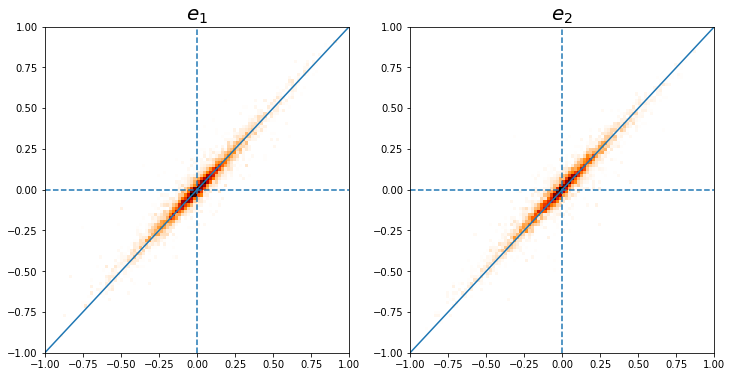

In [20]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(12,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_r_band[:,0,i], ellipticities_r_band[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=20)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'
    

In [21]:
import seaborn as sns

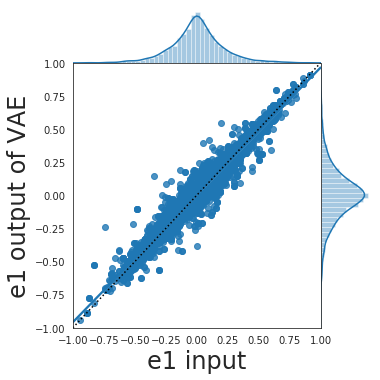

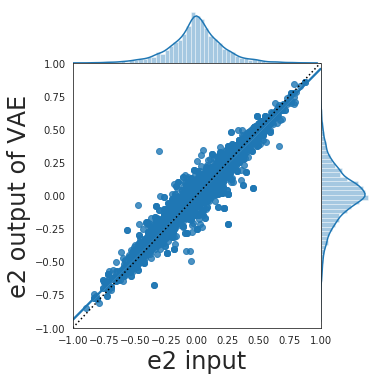

In [22]:
with sns.axes_style('white'):
            g = sns.jointplot(ellipticities_r_band[:,0,0], ellipticities_r_band[:,1,0], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e1 input', 'e1 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

            g = sns.jointplot(ellipticities_r_band[:,0,1], ellipticities_r_band[:,1,1], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e2 input', 'e2 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

In [23]:
delta_e1 = ellipticities_r_band[:,0,0]-ellipticities_r_band[:,1,0]
delta_e2 = ellipticities_r_band[:,0,1]-ellipticities_r_band[:,1,1]

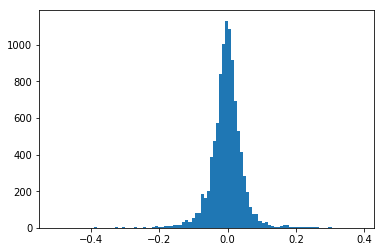

In [42]:
_ = plt.hist(delta_e1, bins = 100)

In [24]:
delta_mag_arr.shape

(100, 100)

In [25]:
test = np.where(delta_mag_arr ==0)
len(test[0])

2499

In [26]:
test = np.where(delta_r_arr ==0)
len(test[0])

2499

In [27]:
delta_mag_arr_test = np.concatenate(delta_mag_arr, axis = 0)

In [28]:
delta_mag_arr_test.shape

(10000,)

In [29]:
test = np.where(delta_mag_arr_test ==0)
len(test[0])

2499

In [30]:
delta_mag_arr = np.concatenate(delta_mag_arr, axis = 0)

In [31]:
delta_r_arr = np.concatenate(delta_r_arr, axis = 0)

In [32]:
delta_mag_arr.shape

(10000,)

In [33]:
test = np.where(delta_r_arr ==0)

In [34]:
test[0], test[0].shape

(array([   0,    4,    6, ..., 9990, 9992, 9998]), (2499,))

In [35]:
delta_test = np.delete(delta_e1, test[0], axis = 0)

In [36]:
delta_test.shape

(7501,)

In [37]:
delta_mag_test = np.delete(delta_mag_arr, test[0], axis = 0)
delta_r_test = np.delete(delta_r_arr, test[0], axis = 0)

In [38]:
delta_mag_test.shape, delta_r_test.shape

((7501,), (7501,))

(0, 10)

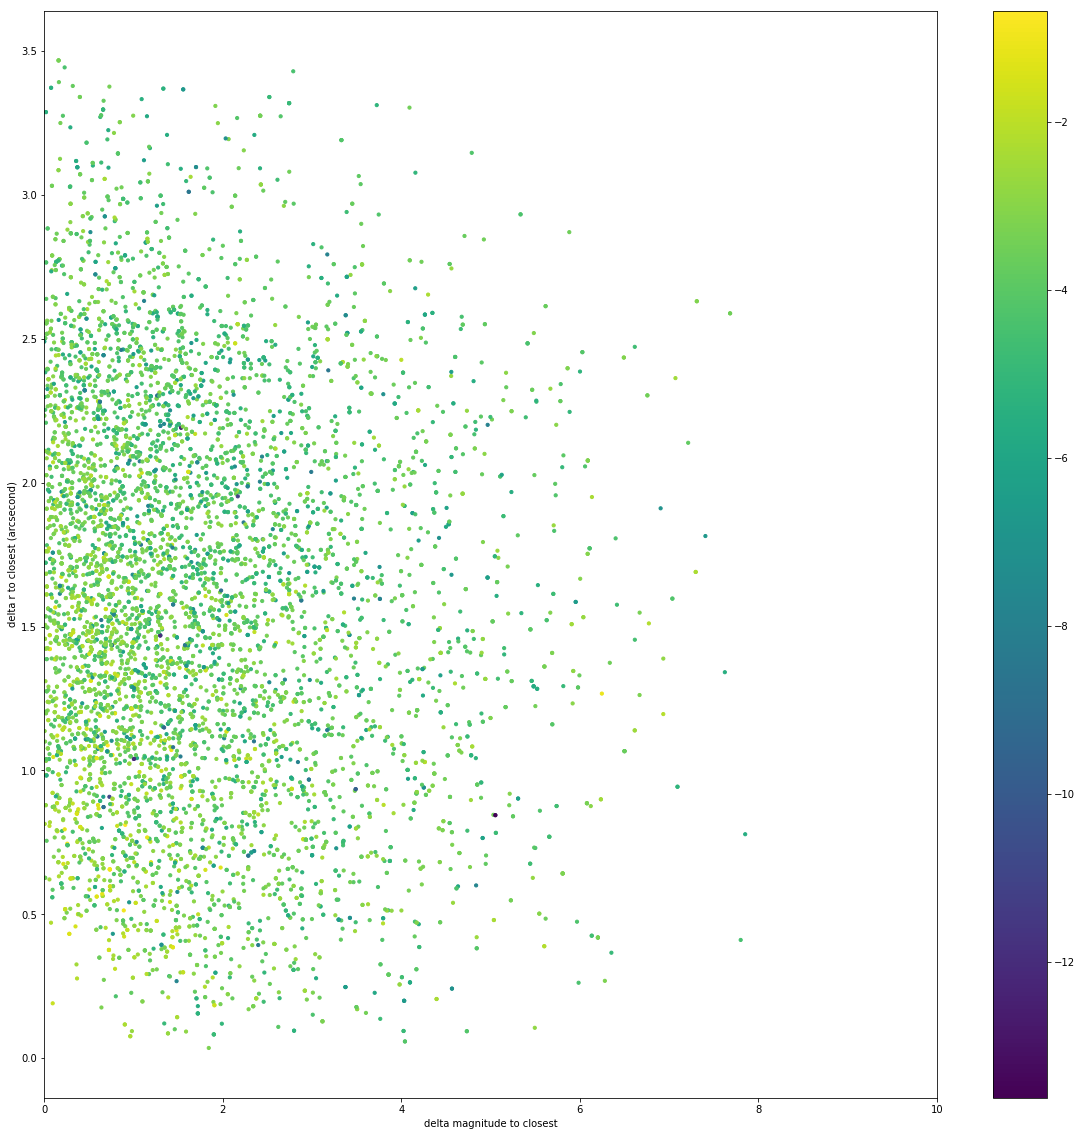

In [44]:
import matplotlib as mpl
fig, axes = plt.subplots(1, figsize=(20,20))

plt.scatter(delta_mag_test, delta_r_test,  c = np.log(np.abs(delta_test)), s=10)#, cmap=mpl.cm.gist_heat_r)#c = delta_e1,
plt.xlabel("delta magnitude to closest")
plt.ylabel("delta r to closest (arcsecond)")
plt.colorbar()
#plt.xscale('log')
plt.xlim(0,10)

In [17]:
batch_size = 100

In [18]:
a = batch_gen.__getitem__(2)
output_enc = encoder.predict(a[0], batch_size = batch_size)

In [19]:
latent_dim =32
epsilon_std = 1.0

In [20]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = np.random.normal( 0.,
                              epsilon_std,(batch_size, latent_dim))
    return z_mean + np.exp(z_log_var / 2) * epsilon


z = []
for i in range (100):
    a = batch_gen.__getitem__(2)
    output_enc = encoder.predict(a[0], batch_size = batch_size)
    z.append(sampling(output_enc))

In [21]:
z = np.concatenate(z, axis = 0)

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


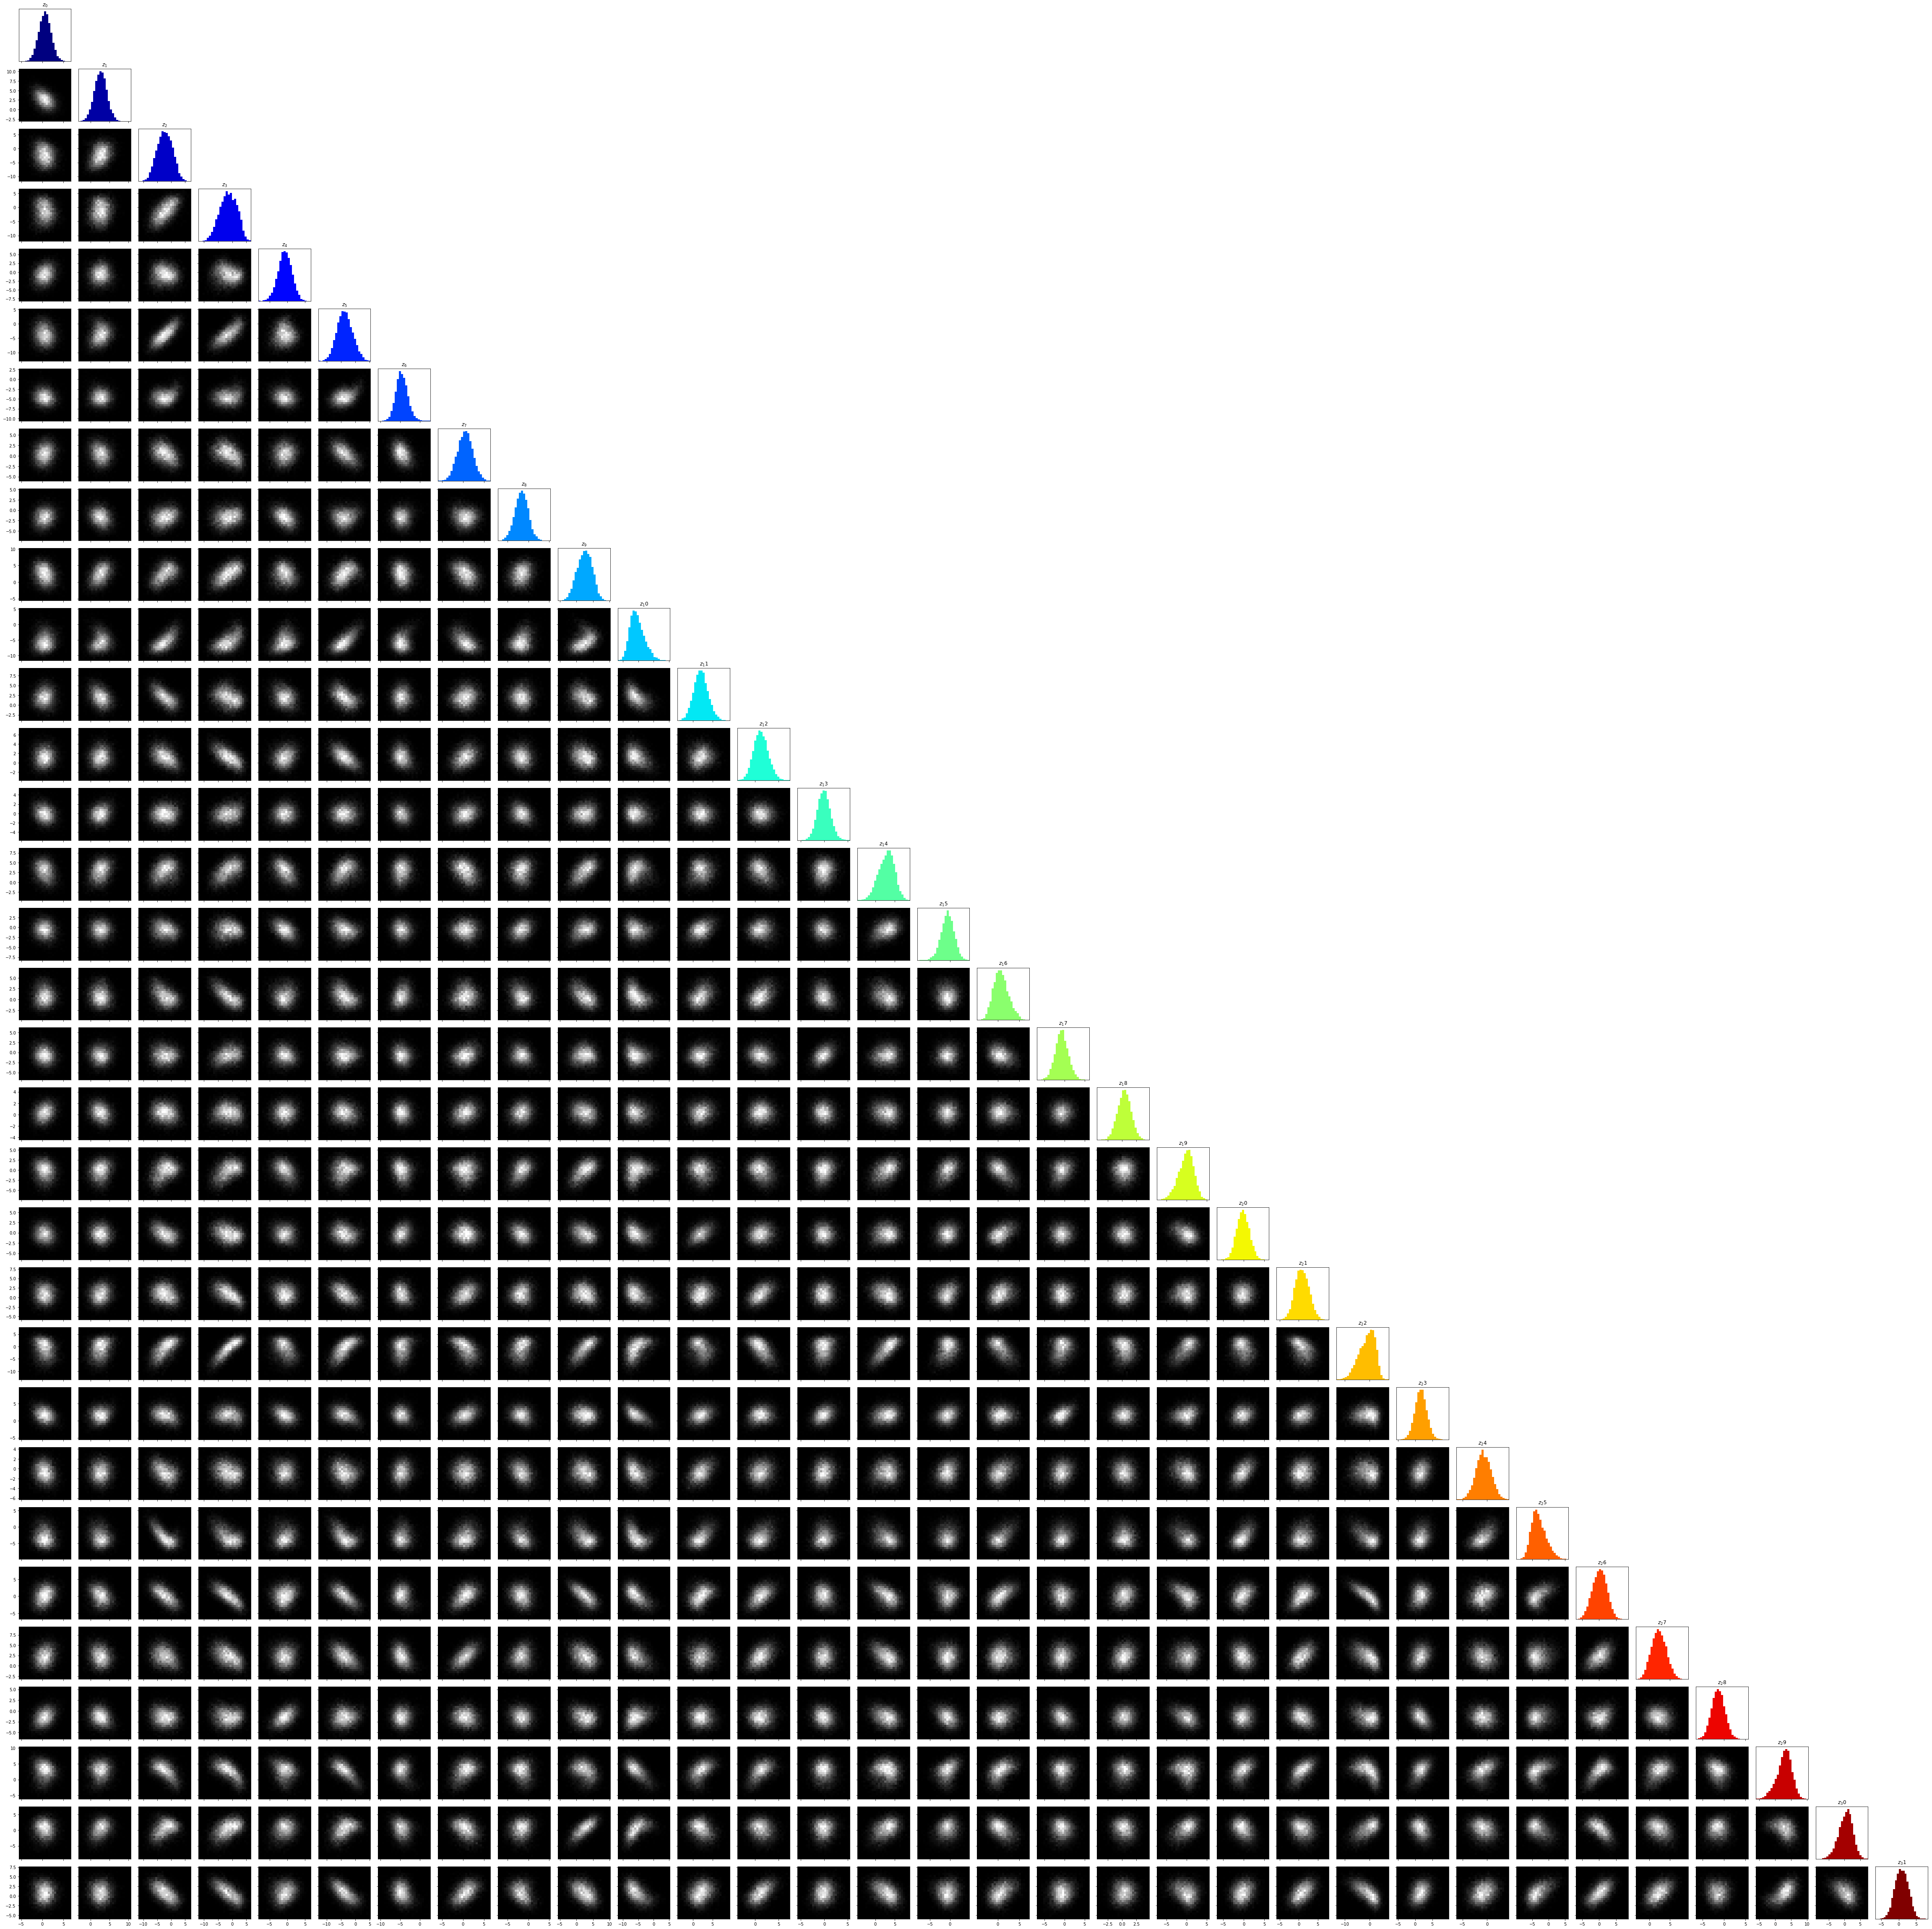

In [22]:
plot_corner_latent(z)

#### Small test on uniform distribution of neighbour galaxies (-1,1): 4 galaxies in each image

In [12]:
import blended_images
from tools_for_VAE import plot, utils
from blended_images import blend_generator

# Parameters
phys_stamp_size = 6.4 # arcsec
pixel_scale_euclid_vis = 0.1 # arcsec/pixel

stamp_size = int(phys_stamp_size/pixel_scale_euclid_vis)

cosmos_cat = galsim.COSMOSCatalog('real_galaxy_catalog_25.2.fits', dir='/sps/lsst/users/barcelin/COSMOS_25.2_training_sample')

In [13]:
bands = [4,5,6,7,8,9]
N_plot = 10
print(len(bands))

6


In [14]:
N = 500

blendedness_euclid = np.zeros((N,3))
max_blendedness_euclid = np.zeros((N))
blendedness_lsst = np.zeros((N,3))
max_blendedness_lsst = np.zeros((N))
shift = np.zeros((N,3,2))

scale_radius = np.zeros((N,4))
mag = np.zeros((N,4))
galaxy_noiseless= np.zeros((N,10,64,64))

blend_noiseless = np.zeros((N,10,64,64))
blend_noisy = np.zeros((N,10,64,64))

In [15]:
for i in range (N):
    print(i)
    galaxy_noiseless[i], galaxy_noisy, blend_noiseless[i], blend_noisy[i],redshift, shift[i], mag[i], blendedness_euclid[i], blendedness_lsst[i], scale_radius[i] = blend_generator(cosmos_cat, 4, 'test')
    max_blendedness_euclid[i] = np.max(blendedness_euclid[i])
    max_blendedness_lsst[i] = np.max(blendedness_lsst[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [32]:
galaxy_noiseless.shape, blend_noisy.shape

((100, 10, 64, 64), (100, 10, 64, 64))

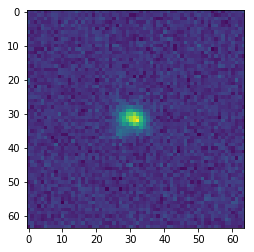

In [33]:
plt.imshow(blend_noisy[0][6])

In [16]:
input_noisy = np.transpose(blend_noisy,axes = (0,2,3,1))[:,:,:,4:]
print(input_noisy.shape)
input_noisy_norm = norm(input_noisy, bands, channel_last = True)
print(input_noisy.shape)

input_noiseless = np.transpose(galaxy_noiseless, axes = (0,2,3,1))[:,:,:,4:]
print(input_noiseless.shape)

(500, 64, 64, 6)
(500, 64, 64, 6)
(500, 64, 64, 6)


In [17]:
output_deblender_lsst = deblender.predict(input_noisy_norm, batch_size = 100)

output_deblender_lsst_plot = denorm(output_deblender_lsst, bands, channel_last = True)
input_noisy_plot = denorm(input_noisy_norm, bands, channel_last = True)

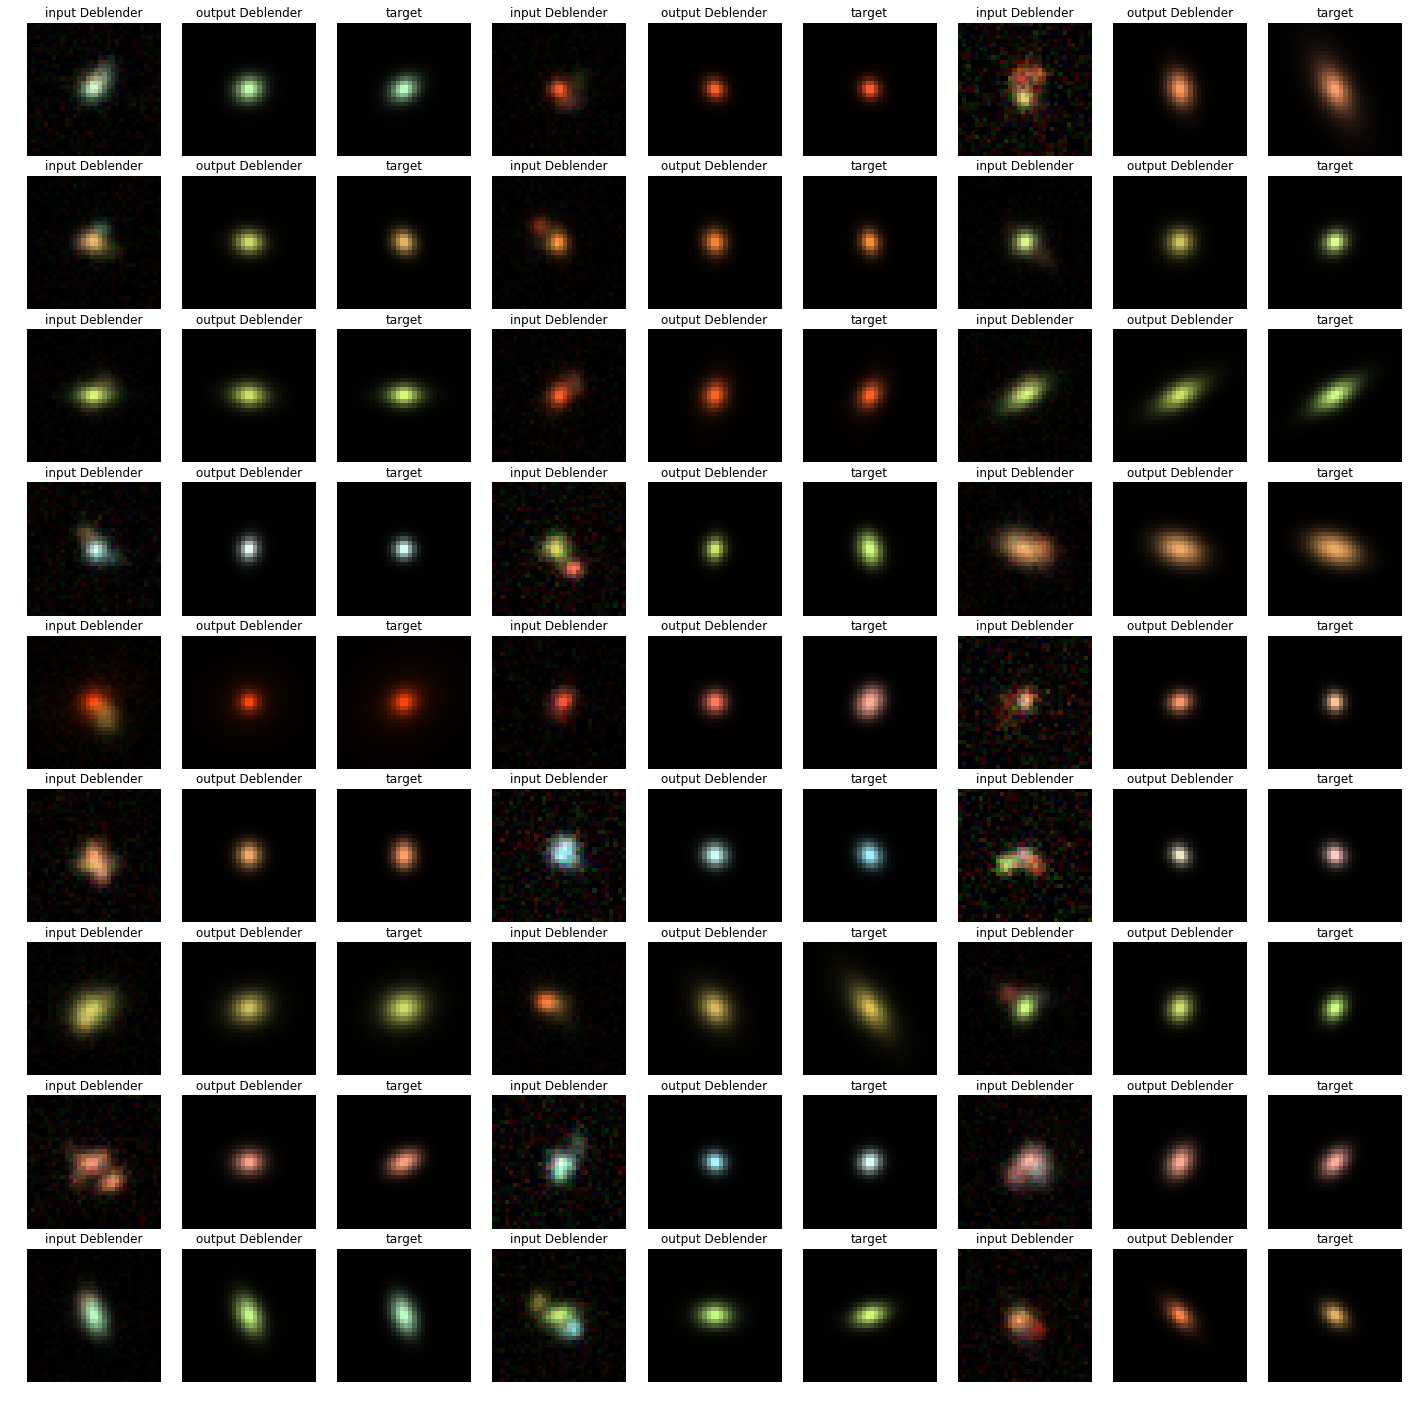

In [65]:
N_plot = 9
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        plot_rgb_lsst(input_noisy_plot[indices[i*N_plot+j]][16:48,16:48],int(stamp_size/2), axes[i,j])#input_vae
        plot_rgb_lsst(output_deblender_lsst_plot[indices[i*N_plot+j]][16:48,16:48],int(stamp_size/2), axes[i,j+1])#output_vae
        plot_rgb_lsst(input_noiseless[indices[i*N_plot+j]][16:48,16:48],int(stamp_size/2), axes[i,j+2])#output_vae

        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

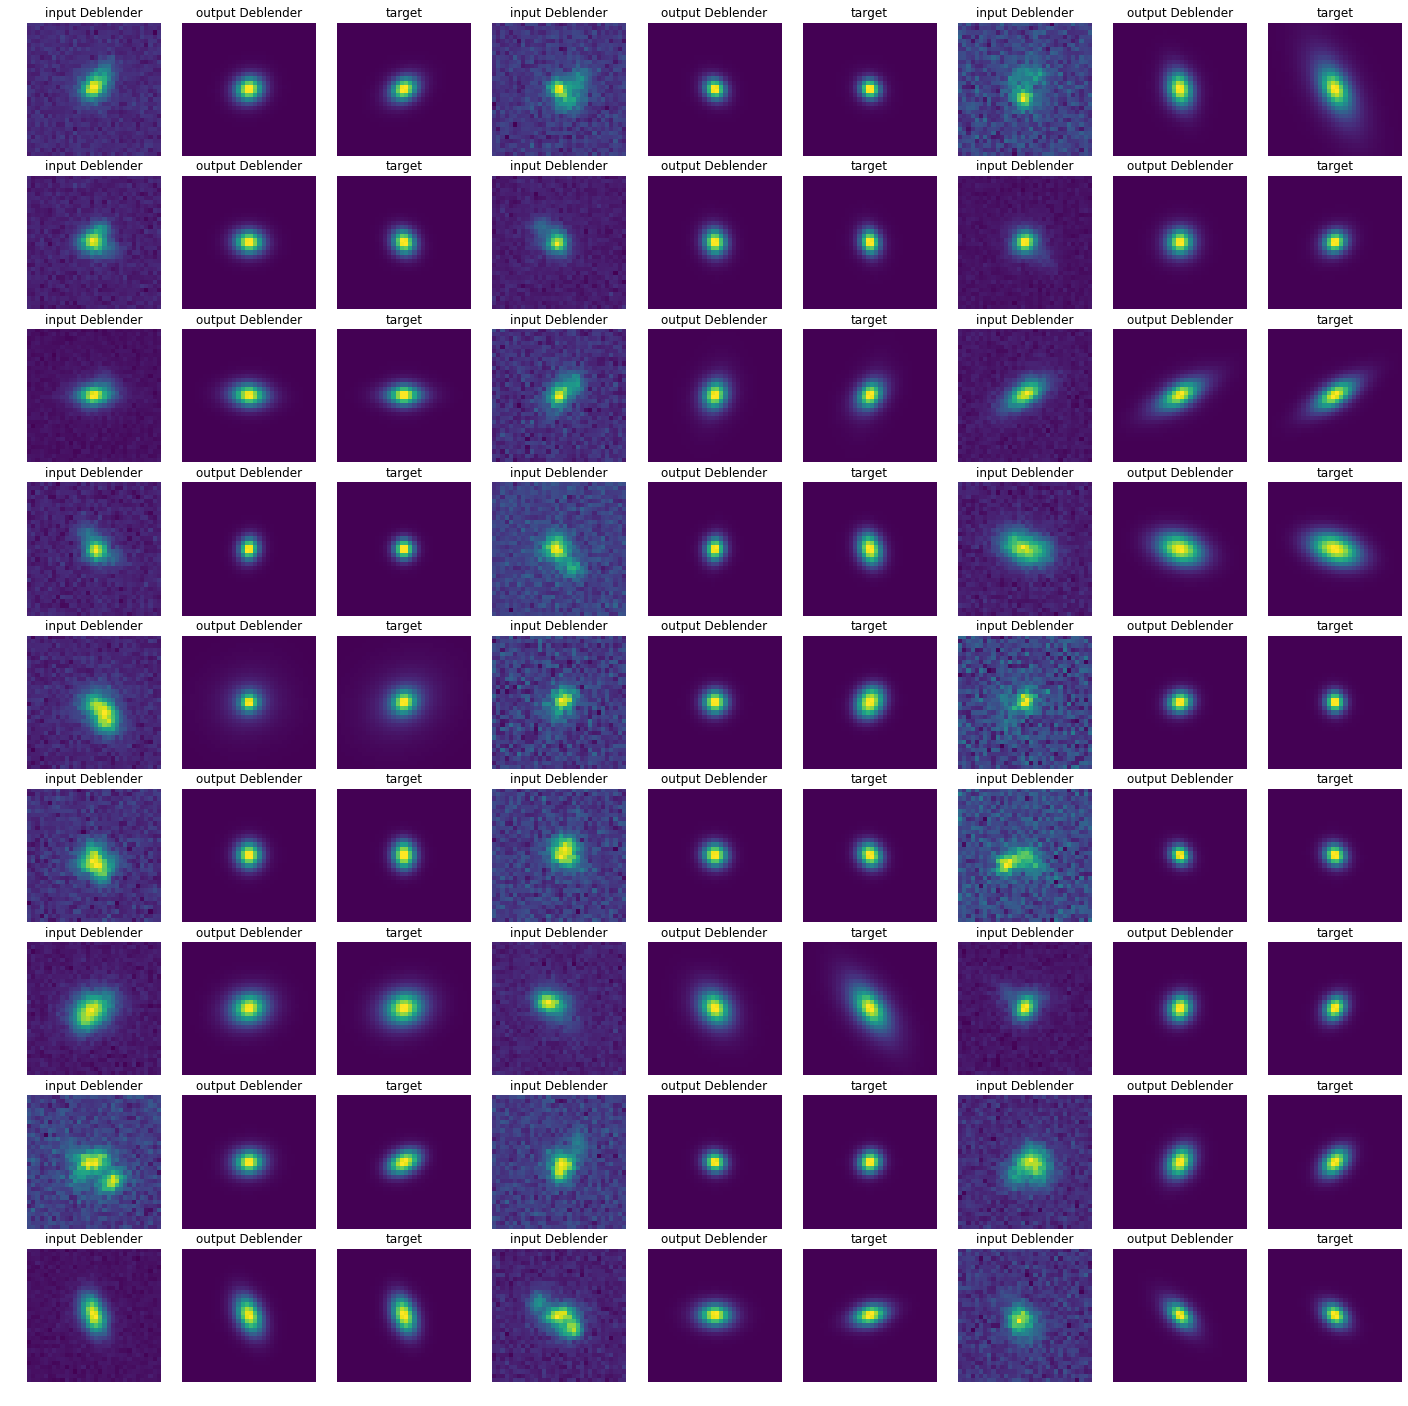

In [66]:
N_plot = 9
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        axes[i,j].imshow(input_noisy_plot[indices[i*N_plot+j]][16:48,16:48,2])
        axes[i,j+1].imshow(output_deblender_lsst_plot[indices[i*N_plot+j]][16:48,16:48,2])
        axes[i,j+2].imshow(input_noiseless[indices[i*N_plot+j]][16:48,16:48,2])

        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

In [219]:
input_noisy = np.transpose(blend_noisy,axes = (0,2,3,1))[:,:,:,4:]

input_noisy_norm = norm(input_noisy, bands, channel_last = True)

input_noiseless = np.transpose(galaxy_noiseless, axes = (0,2,3,1))[:,:,:,4:]

In [220]:
output_deblender_lsst = deblender.predict(input_noisy_norm, batch_size = 100)

#output_deblender_lsst_plot = denorm(output_deblender_lsst, bands, channel_last = True)

input_noisy_plot = denorm(input_noisy_norm, bands, channel_last = True)

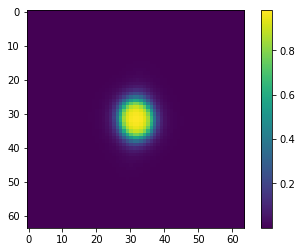

In [221]:
plt.imshow(output_deblender_lsst[20][:,:,2])
plt.colorbar()

In [222]:
input_noisy = np.transpose(blend_noisy,axes = (0,2,3,1))[:,:,:,4:]

input_noisy_norm = norm(input_noisy, bands, channel_last = True)

input_noiseless = np.transpose(galaxy_noiseless, axes = (0,2,3,1))[:,:,:,4:]

output_deblender_lsst_2 = deblender.predict(input_noisy_norm, batch_size = 100)

#output_deblender_lsst_plot_2 = denorm(output_deblender_lsst_2, bands, channel_last = True)

input_noisy_plot = denorm(input_noisy_norm, bands, channel_last = True)

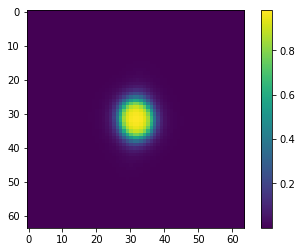

In [223]:
plt.imshow(output_deblender_lsst_2[20][:,:,2])
plt.colorbar()

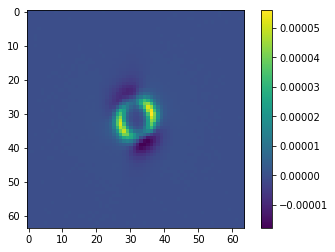

In [224]:
plt.imshow(output_deblender_lsst_2[20][:,:,2]-output_deblender_lsst[20][:,:,2])
plt.colorbar()

In [22]:
delta_r_arr, delta_mag_arr = delta_min(shift, mag)

In [18]:
im_size = 64


batch_size =100
# see LSST Science Book
pix_scale = 0.2 #arcseconds
PSF_fwhm = 0.1
PSF_beta = 2.5

psf = galsim.Moffat(fwhm=PSF_fwhm, beta=PSF_beta)
psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

band = 'i'

ellipticities = []
magnitudes = []
deltas_r = []
deltas_m = []

for j in range(1):
    for i in range (len(output_deblender_lsst)):
        print(i)
        gal_image = galsim.Image(input_noiseless[i][:,:,2])
        gal_image.scale = pix_scale

        res = galsim.hsm.EstimateShear(gal_image, psf_image)
        e_in = [res.corrected_e1, res.corrected_e2]
        print(e_in)
        
        gal_image = galsim.Image(output_deblender_lsst[i][:,:,2])
        gal_image.scale = pix_scale

        res = galsim.hsm.EstimateShear(gal_image, psf_image)
        e_out = [res.corrected_e1, res.corrected_e2]
        print(e_out)
        
        ellipticities.append([e_in, e_out])


ellipticities_r_band = np.array(ellipticities)

0
[-0.2990543842315674, -0.1636805534362793]
[-0.1689220517873764, 0.03780898451805115]
1
[-0.023033592849969864, -0.020766066387295723]
[0.008051924407482147, -0.036240316927433014]
2
[0.11943400651216507, 0.06352445483207703]
[0.08776255697011948, 0.018617311492562294]
3
[-0.38410308957099915, 0.26396000385284424]
[-0.3854237198829651, 0.1413390040397644]
4
[0.2577289938926697, 0.0938054546713829]
[0.18172626197338104, -0.2028932124376297]
5
[-0.14024502038955688, 0.046632762998342514]
[0.17593085765838623, 0.09227205067873001]
6
[-0.15640614926815033, 0.16319261491298676]
[-0.02724740095436573, 0.08946572989225388]
7
[-0.05844708904623985, -0.02353135496377945]
[0.04087796062231064, 0.02271610125899315]
8
[-0.15455113351345062, 0.0666322410106659]
[-0.0920679122209549, -0.07688834518194199]
9
[-0.447952538728714, -0.34895116090774536]
[-0.49716582894325256, -0.4260551631450653]
10
[0.22352226078510284, 0.11765798181295395]
[0.08512707054615021, 0.1542513519525528]
11
[-0.24829255044

[0.011235358193516731, -0.4588924050331116]
95
[0.1306622177362442, -0.16446200013160706]
[0.07241667062044144, -0.3162917196750641]
96
[0.1030617356300354, 0.03399546816945076]
[0.13547773659229279, 0.0429476723074913]
97
[-0.18182900547981262, 0.5371766686439514]
[-0.153838112950325, 0.5732761025428772]
98
[-0.03632254898548126, 0.14368851482868195]
[0.0337100587785244, 0.27313852310180664]
99
[0.04452354833483696, -0.11066613346338272]
[0.10120237618684769, -0.17704644799232483]
100
[0.06490140408277512, -0.06306832283735275]
[-0.05485398322343826, 0.05345826596021652]
101
[0.031781166791915894, -0.3506823778152466]
[-0.014488269574940205, -0.23125487565994263]
102
[-0.025136016309261322, 0.056400708854198456]
[0.00156383216381073, -0.0182917769998312]
103
[0.12858211994171143, 0.4732716381549835]
[0.10873895138502121, 0.377185583114624]
104
[0.23803231120109558, -0.15171653032302856]
[0.25506624579429626, -0.1816115528345108]
105
[-0.1227574422955513, -0.16385120153427124]
[-0.1224

[-0.07467644661664963, -0.42532145977020264]
195
[-0.40797269344329834, -0.14576350152492523]
[-0.4011209309101105, -0.14613166451454163]
196
[-0.007755759172141552, 0.11706007272005081]
[0.012625189498066902, 0.05436021089553833]
197
[0.033377621322870255, 0.15246295928955078]
[0.01471734419465065, 0.14651043713092804]
198
[-0.09948894381523132, 0.1609216183423996]
[-0.10067474097013474, -0.03788632154464722]
199
[0.024928690865635872, 0.053686805069446564]
[-0.128481924533844, 0.0454292967915535]
200
[-0.0993097573518753, -0.06068495661020279]
[-0.08873312175273895, -0.08900310844182968]
201
[0.09357122331857681, -0.057937439531087875]
[-0.012296979315578938, -0.03718772903084755]
202
[-0.40361833572387695, 0.45213550329208374]
[-0.3831515312194824, 0.473239004611969]
203
[0.22351327538490295, -0.015731045976281166]
[0.21825475990772247, -0.015206640586256981]
204
[0.2637759745121002, 0.032480139285326004]
[0.21787609159946442, -0.051829706877470016]
205
[-0.21441650390625, 0.2113344

[0.051890403032302856, -0.15296781063079834]
312
[-0.6729139089584351, -0.5183998346328735]
[-0.6666353344917297, -0.4669029116630554]
313
[0.4276053309440613, 0.007833481766283512]
[0.41055187582969666, -0.012590589933097363]
314
[0.12692303955554962, -0.3285420835018158]
[0.03645371273159981, -0.25547364354133606]
315
[0.24852821230888367, 0.15454290807247162]
[0.20245665311813354, 0.07952821999788284]
316
[0.1469491869211197, 0.13101784884929657]
[0.10993771255016327, -0.03142811357975006]
317
[-0.14166297018527985, 0.0833626389503479]
[0.0358707495033741, 0.15155215561389923]
318
[-0.20619580149650574, -0.0043736957013607025]
[-0.18407928943634033, -0.080936960875988]
319
[0.07837965339422226, 0.16356666386127472]
[0.03748708218336105, 0.15587274730205536]
320
[-0.054170820862054825, 0.17910346388816833]
[-0.05813661217689514, 0.16718986630439758]
321
[-0.1920134723186493, -0.02673320472240448]
[-0.0632442831993103, -0.022904980927705765]
322
[-0.1985221803188324, -0.46237725019454

[-0.019644800573587418, -0.006902911700308323]
[-0.005107873119413853, 0.03612171486020088]
427
[-0.08356451988220215, -0.053104765713214874]
[-0.06735178083181381, 0.028101151809096336]
428
[0.02598920278251171, -0.11615121364593506]
[-0.05297927185893059, -0.09348318725824356]
429
[0.12529520690441132, -0.12501144409179688]
[-0.10882846266031265, -0.13267098367214203]
430
[0.12194731086492538, -0.3977069854736328]
[0.2621701955795288, -0.07343027740716934]
431
[0.0278947614133358, 0.1357787847518921]
[0.05247265845537186, 0.12455692887306213]
432
[0.05029309168457985, -0.04134093225002289]
[0.08362750709056854, -0.061316221952438354]
433
[0.16541968286037445, 0.16522245109081268]
[0.017940400168299675, -0.06801961362361908]
434
[-0.17398810386657715, -0.1111082136631012]
[0.01811404526233673, -0.2602963447570801]
435
[0.024687787517905235, 0.13299700617790222]
[0.035574544221162796, 0.10075864940881729]
436
[0.28842130303382874, 0.10894826054573059]
[0.3734833896160126, 0.05705536529

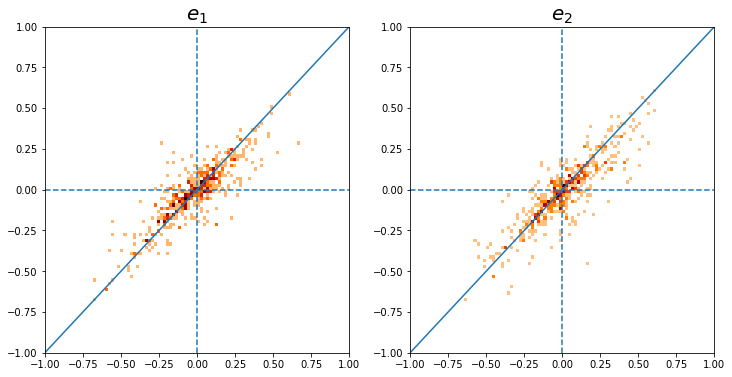

In [19]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(12,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_r_band[:,0,i], ellipticities_r_band[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=20)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'

In [20]:
delta_e1 = ellipticities_r_band[:,0,0]-ellipticities_r_band[:,1,0]
delta_e2 = ellipticities_r_band[:,0,1]-ellipticities_r_band[:,1,1]

In [23]:
delta_mag_arr.shape, delta_r_arr.shape

((500,), (500,))

In [24]:
r = delta_r_arr/scale_radius[:,0]

(0, 10)

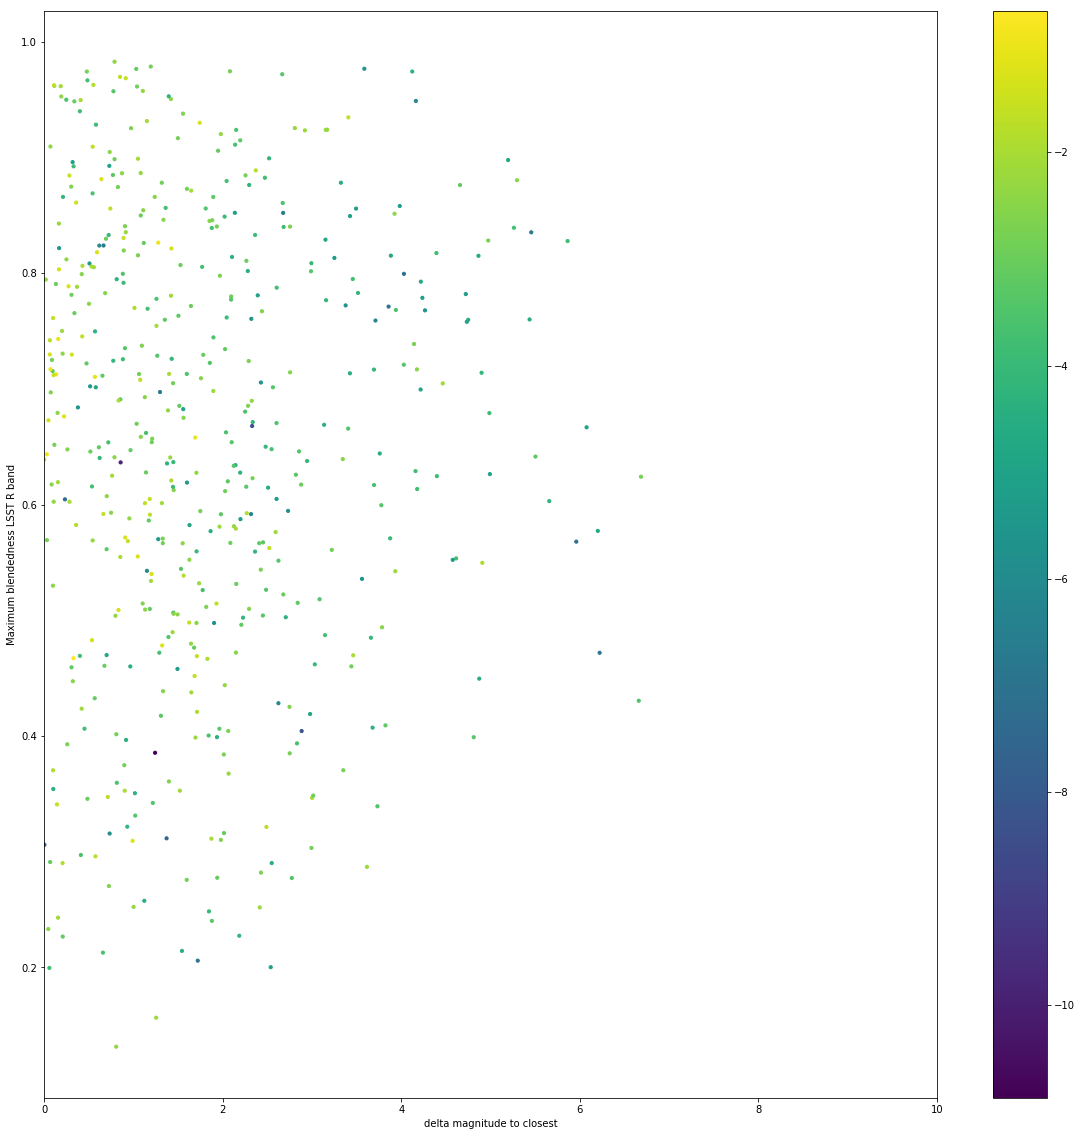

In [25]:
import matplotlib as mpl
fig, axes = plt.subplots(1, figsize=(20,20))

plt.scatter(delta_mag_arr, max_blendedness_lsst,  c = np.log(np.abs(delta_e1)), s=10)#np.log(r)     #, cmap=mpl.cm.gist_heat_r)#c = delta_e1,
plt.xlabel("delta magnitude to closest")
plt.ylabel("Maximum blendedness LSST R band")#delta r to closest (arcsecond)/scale radius of centered
plt.colorbar()
#plt.xscale('log')
plt.xlim(0,10)

In [30]:
#Reshape the list of shifts so that it is easily usable
shifts = np.zeros((len(shift),3,2))
mags = np.zeros((len(mag),4))
mags_new = np.zeros((len(mag),3))

# Create an array of minimum magnitude for each image
mag_min = np.zeros(len(mag))
for k in range (len(mag)):
    mag_min[k] = np.min(mag[k])

# set lists
deltas_r= np.zeros((len(shift),3))
delta_r= np.zeros((len(shift)))
delta_mag = np.zeros((len(shift)))
deltas_mag= np.zeros((len(shift),4))

for i in range (len(shift)):
    for j in range (len(shift[i])):
        deltas_r[i][j] = np.sqrt(np.square(shift[i][j][0])+np.square(shift[i][j][1]))
    for j in range (len(mag[i])):
        deltas_mag [i][j] = mag[i][j] - mag_min[i]
        #print(deltas_mag.shape)
        
# Create a deltas_mag liste without all zeros: place of the centered galaxy when generated
deltas_mag_3= np.zeros((len(deltas_mag),3))
scale_radius_3= np.zeros((len(deltas_mag),3))

counter = 0
for k in range (len(deltas_mag)):
    No_zero = True
    for l in range (len(deltas_mag[k])):
        if deltas_mag[k][l] == 0 and No_zero:
            counter +=1
            No_zero = False
        elif No_zero == False:
            deltas_mag_3[k][l-1] = deltas_mag[k][l]
        else:
            deltas_mag_3[k][l] = deltas_mag[k][l]
            scale_radius_3[k][l]= scale_radius[k][l]
                
print(counter, deltas_mag_3)
# Take the min of the non zero delta r
c = 0
for j in range (len(shifts)):
    print('image : '+str(j))
    # If all the deta_r are equals to 0 (there is only on galaxy on the image) then write 0
    if (deltas_r[j,:].any() == 0):
        delta_r[j] = 0
        delta_mag[j] = 0
        c+=1
    else:
        x = np.where(deltas_r[j] == 0)[0]
        deltas = np.delete(deltas_r[j],x)
        delta_r[j] = np.min(deltas)
        y = np.where(deltas == np.min(deltas))[0]
        print(np.min(deltas), deltas)
        delta_mag[j] = deltas_mag_3[j,y]
        print(y, deltas_mag_3[j,y], deltas_mag_3[j])

500 [[1.19743987 1.56844159 1.21300782]
 [1.45231924 0.88215886 0.05655317]
 [2.48681879 3.05505552 0.68352775]
 ...
 [0.99357972 2.77846936 1.84666555]
 [0.37780039 0.42101621 0.92606434]
 [0.69443792 0.56941109 0.59831298]]
image : 0
0.6369781235035432 [0.63697812 1.03337764 0.87008534]
[0] [1.19743987] [1.19743987 1.56844159 1.21300782]
image : 1
0.3196438999997596 [0.72112301 0.3196439  1.01058648]
[1] [0.88215886] [1.45231924 0.88215886 0.05655317]
image : 2
0.7740332150987388 [0.77403322 0.94541785 0.87274188]
[0] [2.48681879] [2.48681879 3.05505552 0.68352775]
image : 3
0.3653055468894357 [0.73292554 0.36530555 1.01710641]
[1] [2.67795253] [2.82893026 2.67795253 2.92343445]
image : 4
0.559374156288872 [0.55937416 1.10737971 0.79558963]
[0] [0.0846391] [0.0846391  0.59405842 1.29628619]
image : 5
0.7383856788467666 [0.82510243 1.15868558 0.73838568]
[2] [0.99123002] [0.17085337 0.82298894 0.99123002]
image : 6
0.37588908858367753 [0.37588909 0.9663959  0.99703498]
[0] [1.25885298

[0] [3.37767914] [3.37767914 3.53889041 3.37387652]
image : 174
0.13647629176786732 [0.13647629 0.38368615 1.15255762]
[0] [0.40966407] [0.40966407 1.45304771 1.96427844]
image : 175
0.30299606392833944 [0.78927565 0.97993545 0.30299606]
[2] [1.08219945] [1.55084448 0.48012672 1.08219945]
image : 176
0.5758108678639612 [0.65745712 0.837542   0.57581087]
[2] [0.32936258] [0.60673854 0.35576967 0.32936258]
image : 177
0.42108806056349524 [1.08005876 0.42108806 0.86040357]
[1] [1.07715599] [0.53263705 1.07715599 0.50067125]
image : 178
0.6082397949942392 [0.68637715 0.60823979 1.17333134]
[1] [2.14378191] [0.56145462 2.14378191 1.51945067]
image : 179
0.5457491009289738 [0.5457491  0.94236816 1.16660212]
[0] [1.37732669] [1.37732669 0.90881141 3.86788985]
image : 180
0.23734433783549397 [0.32701602 0.23734434 1.03070903]
[1] [0.35933977] [0.19687731 0.35933977 0.95740004]
image : 181
0.21737916798611046 [0.21737917 0.75596028 0.93357078]
[0] [1.05106769] [1.05106769 0.04634955 2.8579299 ]

[2] [0.75075339] [1.24629002 1.89506266 0.75075339]
image : 339
0.42325867494714237 [0.8882987  0.42325867 1.01497138]
[1] [1.52784094] [3.39817183 1.52784094 3.14303491]
image : 340
0.5004715788601298 [1.06702501 1.26580622 0.50047158]
[2] [2.33037489] [1.74141444 2.00018998 2.33037489]
image : 341
0.7419386415888467 [1.07634011 0.74193864 1.14560461]
[1] [1.44790521] [0.1884919  1.44790521 0.13862943]
image : 342
0.2536901831762061 [0.25369018 1.11433173 1.13669154]
[0] [2.99420278] [2.99420278 5.42761079 4.48944352]
image : 343
0.5433301913593789 [0.54333019 1.01897732 0.88193109]
[0] [1.96498466] [1.96498466 1.80791189 2.31358055]
image : 344
0.8867498639077652 [0.88674986 0.97338702 1.13771561]
[0] [2.9948073] [2.9948073  1.29230494 3.6226587 ]
image : 345
0.6154623858037456 [0.78326909 0.61546239 0.76640848]
[1] [5.96106813] [1.80886748 5.96106813 3.20440563]
image : 346
0.6248923416697224 [0.79595068 0.62489234 1.18402287]
[1] [2.22834333] [1.35327563 2.22834333 0.58884941]
imag

[0] [3.15854027] [3.15854027 1.77775718 1.02319439]
image : 463
0.8525027606077672 [0.98763325 0.946602   0.85250276]
[2] [2.01440817] [2.7642781  1.89448229 2.01440817]
image : 464
0.11399330838501259 [0.67512024 0.57502972 0.11399331]
[2] [1.74321598] [1.36187932 1.07122318 1.74321598]
image : 465
0.7536162368447352 [1.04128534 0.76401803 0.75361624]
[2] [2.29630057] [1.64049468 3.12540754 2.29630057]
image : 466
0.2698539170768824 [0.26985392 1.07838884 0.8598513 ]
[0] [0.16630709] [0.16630709 0.76009985 1.74012837]
image : 467
0.5126548294189008 [0.66428721 0.55949756 0.51265483]
[2] [0.22388493] [1.4204855  1.15086176 0.22388493]
image : 468
0.5298338675959067 [0.98086509 0.52983387 0.79880074]
[1] [2.10127303] [3.08324863 2.10127303 1.59104178]
image : 469
0.4325678500693434 [0.97840836 0.74133016 0.43256785]
[2] [2.28453812] [2.59050902 2.91112886 2.28453812]
image : 470
0.6916723532270387 [1.10127528 0.98594174 0.69167235]
[2] [1.39833403] [0.87942994 2.40257415 1.39833403]
ima

In [31]:
deltas_r.shape, deltas_mag_3.shape, blendedness_lsst.shape, scale_radius_3.shape

((500, 3), (500, 3), (500, 3), (500, 3))

In [ ]:
scale_radius_3 = np.delete(scale_radius, np.where())

(0, 10)

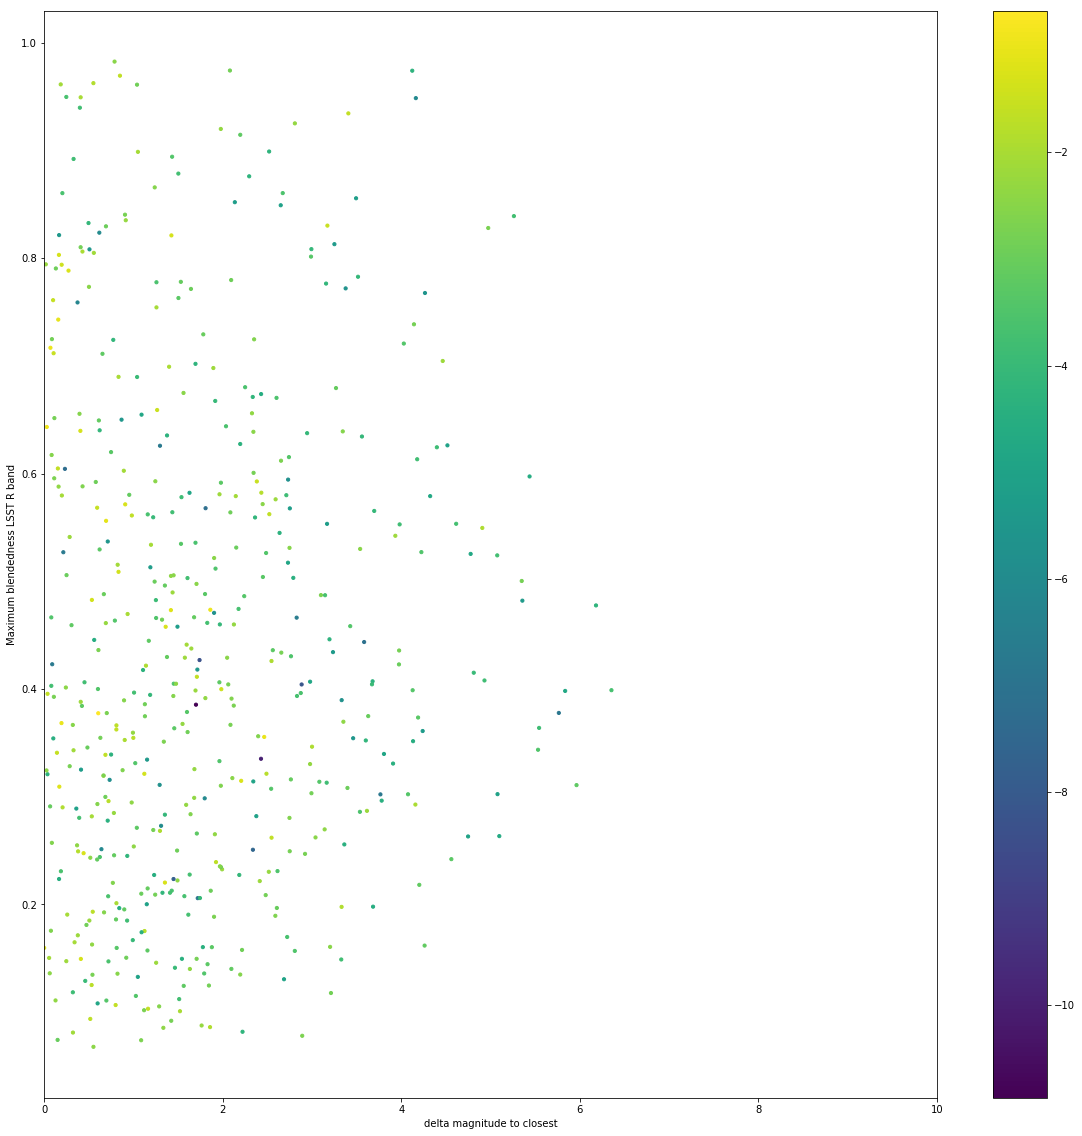

In [33]:
import matplotlib as mpl
fig, axes = plt.subplots(1, figsize=(20,20))

plt.scatter(deltas_mag_3[:,0], blendedness_lsst[:,0],  c = np.log(np.abs(delta_e1)), s=10)#np.log(r)     #, cmap=mpl.cm.gist_heat_r)#c = delta_e1,
plt.xlabel("delta magnitude first neighbour")
plt.ylabel("Blendedness LSST R band of first neighbour")#delta r to closest (arcsecond)/scale radius of centered
plt.colorbar()
#plt.xscale('log')
plt.xlim(0,10)

(0, 10)

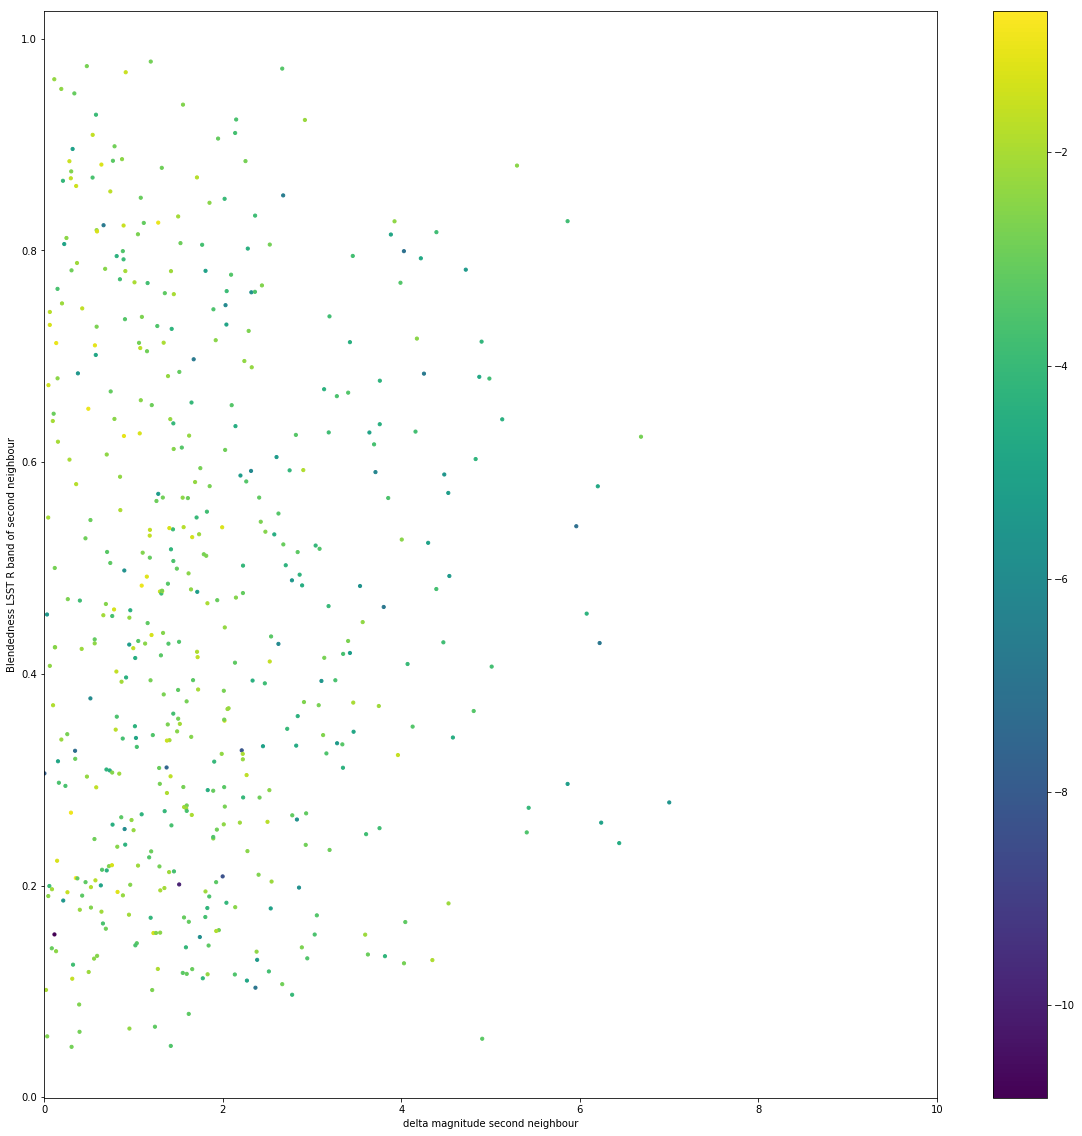

In [34]:
import matplotlib as mpl
fig, axes = plt.subplots(1, figsize=(20,20))

plt.scatter(deltas_mag_3[:,1], blendedness_lsst[:,1],  c = np.log(np.abs(delta_e1)), s=10)#np.log(r)     #, cmap=mpl.cm.gist_heat_r)#c = delta_e1,
plt.xlabel("delta magnitude second neighbour")
plt.ylabel("Blendedness LSST R band of second neighbour")#delta r to closest (arcsecond)/scale radius of centered
plt.colorbar()
#plt.xscale('log')
plt.xlim(0,10)

(0, 10)

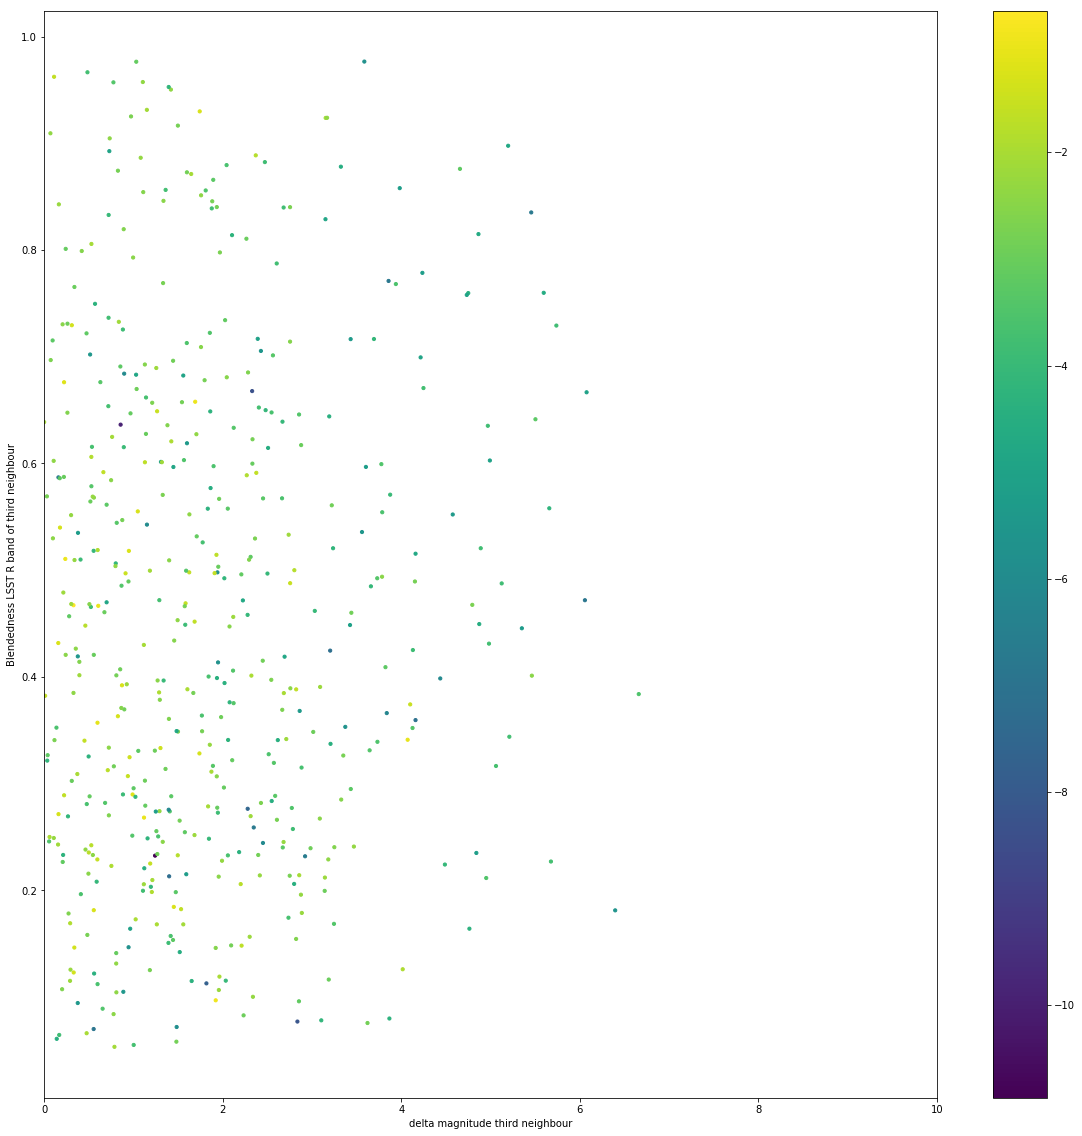

In [35]:
import matplotlib as mpl
fig, axes = plt.subplots(1, figsize=(20,20))

plt.scatter(deltas_mag_3[:,2], blendedness_lsst[:,2],  c = np.log(np.abs(delta_e1)), s=10)#np.log(r)     #, cmap=mpl.cm.gist_heat_r)#c = delta_e1,
plt.xlabel("delta magnitude third neighbour")
plt.ylabel("Blendedness LSST R band of third neighbour")#delta r to closest (arcsecond)/scale radius of centered
plt.colorbar()
#plt.xscale('log')
plt.xlim(0,10)

Use the galaxy of maximum LSST blendedness to plot

In [37]:
np.max(blendedness_lsst, axis = 1).shape

(500,)

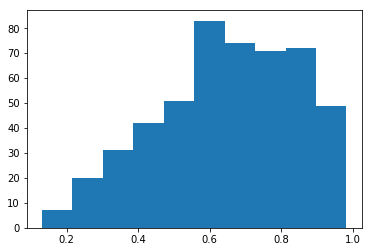

In [46]:
_ = plt.hist(np.max(blendedness_lsst, axis = 1))

In [49]:
x = np.where(blendedness_lsst == np.max(blendedness_lsst, axis = 1))
x[0].shape

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


(0,)

# Load the shifts to evaluate the distance between 2 galaxies

### Same analysis as function of delta r : all the images with only one galaxy are suppressed

In [14]:
im_size = 64

batch_size =100
# see LSST Science Book
pix_scale = 0.2 #arcseconds
PSF_fwhm = 0.1
PSF_beta = 2.5

psf = galsim.Moffat(fwhm=PSF_fwhm, beta=PSF_beta)
psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

band = 'i'

ellipticities = []
delta_r = []

for j in range(100):
    a = batch_gen.__getitem__(2)
    output_vae = deblender.predict(a[0].reshape((100,64,64,6)), batch_size = batch_size)#a[0] test[:,1,4:].reshape((10000,64,64,6))
    for i in range (len(a[0])):#a[0] test
        try: 
            if (a[2][i]!=0):
                gal_image = galsim.Image(a[1][i].reshape((6,64,64))[2])# 6, a[1][i] test[i,0,6]
                gal_image.scale = pix_scale

                res = galsim.hsm.EstimateShear(gal_image, psf_image)
                e_in = [res.corrected_e1, res.corrected_e2]

                gal_image = galsim.Image(output_vae[i].reshape((6,64,64))[2])
                gal_image.scale = pix_scale

                res = galsim.hsm.EstimateShear(gal_image, psf_image)
                e_out = [res.corrected_e1, res.corrected_e2]

                ellipticities.append([e_in, e_out])
                delta_r.append(a[2][i])
        except :
            print('error for galaxy '+str(j*100+i))
            pass
        continue

ellipticities_r_band = np.array(ellipticities)
delta_r_list = np.array(delta_r)

error for galaxy 851
error for galaxy 1145
error for galaxy 1919
error for galaxy 2022
error for galaxy 2785


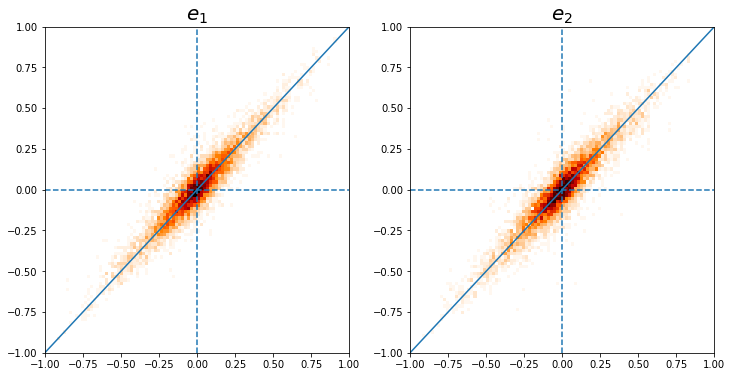

In [45]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(12,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_r_band[:,0,i], ellipticities_r_band[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=20)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'

In [46]:
delta_e1 = ellipticities_r_band[:,0,0]-ellipticities_r_band[:,1,0]
delta_e2 = ellipticities_r_band[:,0,1]-ellipticities_r_band[:,1,1]

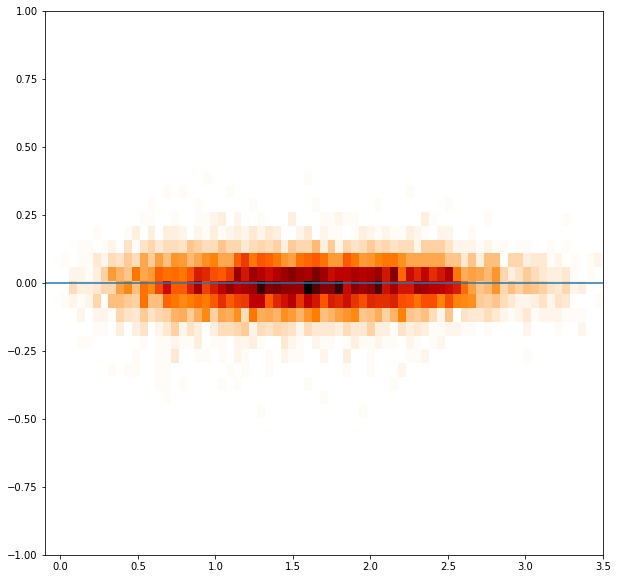

In [52]:
fig = plt.figure(figsize = (10,10))
_ = plt.hist2d(delta_r, delta_e1, bins=np.linspace(-1,4,100), cmap=mpl.cm.gist_heat_r)
plt.xlim(-0.1,3.5)
plt.ylim(-1,1)
plt.plot((-1, 4),(0,0))

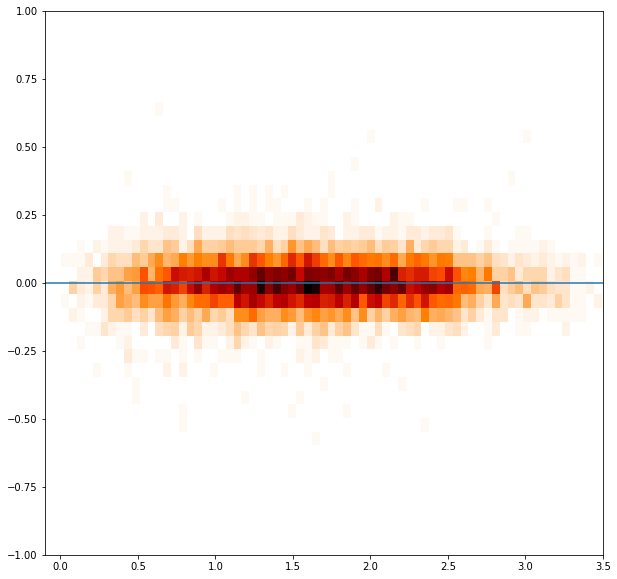

In [53]:
fig = plt.figure(figsize = (10,10))
_ = plt.hist2d(delta_r, delta_e2, bins=np.linspace(-1,4,100), cmap=mpl.cm.gist_heat_r)
plt.xlim(-0.1,3.5)
plt.ylim(-1,1)
plt.plot((-1, 4),(0,0))

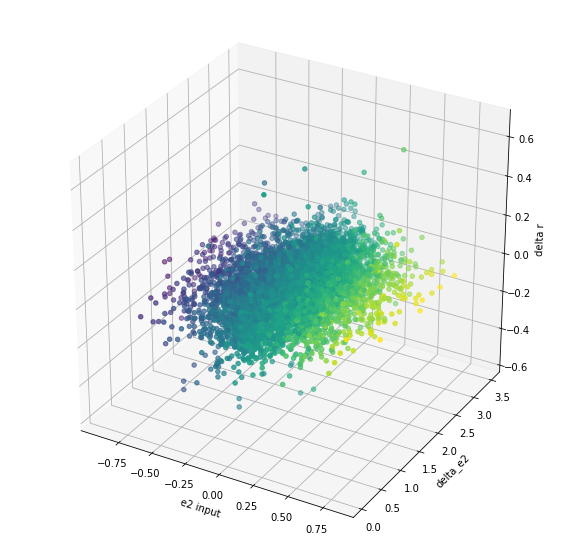

In [50]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

xs = ellipticities_r_band[:,0,1]
ys = delta_r
zs = delta_e2
ax.scatter(xs, ys, zs, c=xs, cmap='viridis')

ax.set_xlabel('e2 input')
ax.set_ylabel('delta_e2')
ax.set_zlabel('delta r')

plt.show()


### N sampling for the same galaxy on the 10 000 and take the mean

In [16]:
im_size = 64

batch_size =100
# see LSST Science Book
pix_scale = 0.2 #arcseconds
PSF_fwhm = 0.1
PSF_beta = 2.5

psf = galsim.Moffat(fwhm=PSF_fwhm, beta=PSF_beta)
psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

N_sampling = 100
N = 1

ellipticities_n = np.zeros((N_sampling, batch_size, 2,2 ))
ellipticities = []
delta_r = []
e = []


for j in range(N):
    a = batch_gen.__getitem__(2)
    for k in range (N_sampling):
        output_vae = deblender.predict(a[0].reshape((100,64,64,6)), batch_size = batch_size)

        for i in range (batch_size):
            if (a[2][i]!=0):
                try: 
                        gal_image = galsim.Image(a[1][i].reshape((6,64,64))[2])
                        gal_image.scale = pix_scale

                        res = galsim.hsm.EstimateShear(gal_image, psf_image)
                        e_in = [res.corrected_e1, res.corrected_e2]
                        e_beta_in = [res.observed_shape.e, res.observed_shape.beta.rad]

                        gal_image = galsim.Image(output_vae[i].reshape((6,64,64))[2])
                        gal_image.scale = pix_scale

                        res = galsim.hsm.EstimateShear(gal_image, psf_image)
                        e_out = [res.corrected_e1, res.corrected_e2]
                        e_beta_out = [res.observed_shape.e, res.observed_shape.beta.rad]

                        ellipticities_n[k,i] = [e_in, e_out]
                        e.append([e_beta_in, e_beta_out])
                except :
                    print('error for galaxy '+str(j*100+i)+' sample '+str(k))
                    pass
                continue
                delta_r.append(a[2][i])
    print(np.array(ellipticities_n).shape)
    
    ellipticities.append(np.mean(np.array(ellipticities_n), axis = 0))
    print(np.array(ellipticities).shape)
        
        
ellipticities_r_band = np.array(ellipticities).reshape((100,2,2))
delta_r_list = np.array(delta_r)
e_beta = np.array(e)

(100, 100, 2, 2)
(1, 100, 2, 2)


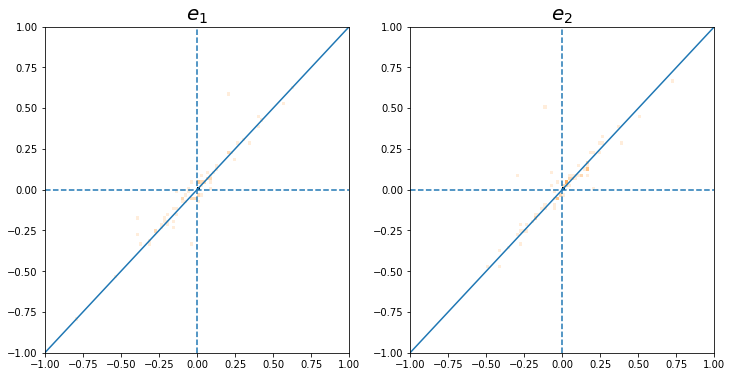

In [18]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(12,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_r_band[:,0,i], ellipticities_r_band[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=20)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'

In [24]:
delta_e1 = ellipticities_r_band[:,0,0]-ellipticities_r_band[:,1,0]
delta_e2 = ellipticities_r_band[:,0,1]-ellipticities_r_band[:,1,1]

ValueError: The dimension of bins must be equal to the dimension of the  sample x.

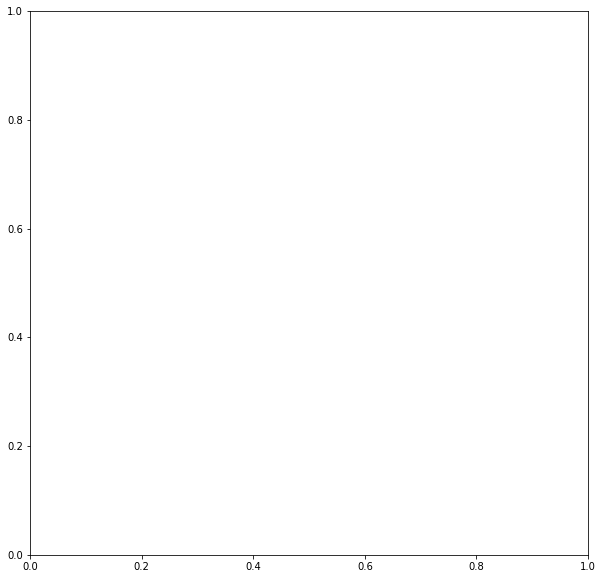

In [26]:
fig = plt.figure(figsize = (10,10))
_ = plt.hist2d(delta_r, delta_e1, bins=np.linspace(-1,4,10), cmap=mpl.cm.gist_heat_r)
plt.xlim(-0.1,3.5)
plt.ylim(-1,1)
plt.plot((-1, 4),(0,0))

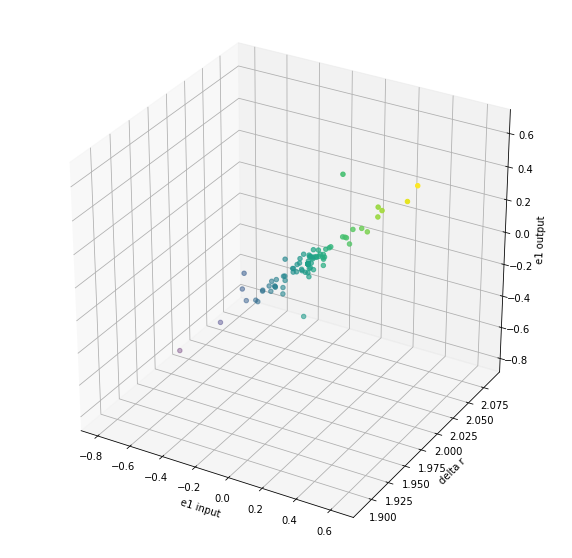

In [23]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

xs = ellipticities_r_band[:,0,0]
ys = delta_r
zs = ellipticities_r_band[:,1,0]
ax.scatter(xs, ys, zs, c=xs, cmap='viridis')

ax.set_xlabel('e1 input')
ax.set_ylabel('delta r')
ax.set_zlabel('e1 output')

plt.show()

In [ ]:
# define the number of samplings
N = 3
nb_of_samplings = 10

batch_size = 100

In [ ]:
# Define the PSF used for measurement
PSF = galsim.Moffat(fwhm=0.1, beta=2.5)
final_epsf_image = PSF.drawImage(scale=0.2)

In [ ]:
res_out_r_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_r_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')


gal = []
err_count = 0

for i in range (N):
    list_galsim_simple=batch_gen_lsst_euclid.__getitem__(2)
    gal.append(list_galsim_simple[0][0])
    
    plt.imshow(list_galsim_simple[0][0].reshape((10,64,64))[6])#
    for k in range (len(list_galsim_simple[0])):
        list_galsim_simple[0][k] = gal[i]
    try: 
        print(i)
        for j in range (nb_of_samplings):
            print(j)
            output_vae_list_r = vae_lsst_r_band_conv.predict(list_galsim_simple[0].reshape((batch_size,10,64,64))[:,6], batch_size = batch_size)
            output_vae_list_r = output_vae_list_r.reshape((batch_size,64,64))

            output_vae_list_lsst = vae_lsst_conv.predict(list_galsim_simple[0].reshape((batch_size,10,64,64))[:,4:].reshape((batch_size,64,64,6)), batch_size = batch_size)
            output_vae_list_lsst = output_vae_list_lsst.reshape((batch_size,6,64,64))

            output_vae_list_lsst_euclid = vae_lsst_euclid_conv.predict(list_galsim_simple[0], batch_size = batch_size)
            output_vae_list_lsst_euclid = output_vae_list_lsst_euclid.reshape((batch_size,10,64,64))

            for t in range (batch_size):
                img_out_simple = galsim.Image(output_vae_list_r[t])
                res_out_r_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
                res_out_r_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2

                img_out_simple = galsim.Image(output_vae_list_lsst[t,2])
                res_out_lsst_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
                res_out_lsst_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2

                img_out_simple = galsim.Image(output_vae_list_lsst_euclid[t,6])
                res_out_lsst_euclid_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
                res_out_lsst_euclid_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2
#print(res_out[i,j*batch_size+t])

            
            
    except :
        err_count +=1
        print('erreur')
        pass
    continue
            
print(err_count)

In [ ]:
res_in_e1 = np.empty([N], dtype='float32')
res_in_e2 = np.empty([N], dtype='float32')

for k in range (N):
#    try: 
    img_in_simple = galsim.Image(gal[k].reshape((10,64,64))[6])
    res_in_e1[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e1
    res_in_e2[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e2
    print(res_in_e1[k], res_in_e2[k])

In [ ]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(2,3, figsize=(25,14))

ax = axes[0,0]
_ = ax.hist(res_out_r_e1[0],  bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e1[0], bins = 50,label ='LSST filters' ,  alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e1[0], bins = 50,label = 'LSST+Euclid \n filters' ,  alpha = 0.5)
variance = np.var(res_out_r_e1[0])
sigma = np.sqrt(variance)
x = np.linspace(min(res_out_r_e1[0]), max(res_out_r_e1[0]), 100)
#ax.plot(x, mlab.normpdf(x, mean, sigma))


ax.axvline(res_in_e1[0],color='g')
ax.set_title('Galaxy ' + str(1))
ax.set_ylabel('counts')
ax.set_xlabel('e1')
ax.legend()

ax = axes[0,1]
_ = ax.hist(res_out_r_e1[1] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e1[1] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e1[1] , bins = 50, label = 'LSST+Euclid \n filters' , alpha = 0.5)

ax.axvline(res_in_e1[1],color='g')
ax.set_title('Galaxy ' + str(2))
ax.set_xlabel('e1')
ax.legend()

ax = axes[0,2]
_ = ax.hist(res_out_r_e1[2] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e1[2] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e1[2] , bins = 50,label = 'LSST+Euclid \n filters' ,  alpha = 0.5)

ax.axvline(res_in_e1[2],color='g')
ax.set_title('Galaxy ' + str(3))
ax.set_xlabel('e1')
ax.legend()

ax = axes[1,0]
_ = ax.hist(res_out_r_e2[0] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e2[0] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e2[0] , bins = 50, label = 'LSST+Euclid \n filters' , alpha = 0.5)

ax.axvline(res_in_e2[0],color='g')
ax.set_title('Galaxy ' + str(1))
ax.set_ylabel('counts')
ax.set_xlabel('e2')
ax.legend()

ax = axes[1,1]
_ = ax.hist(res_out_r_e2[1] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e2[1] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e2[1] , bins = 50, label = 'LSST+Euclid \n filters' , alpha = 0.5)

ax.axvline(res_in_e2[1],color='g')
ax.set_title('Galaxy ' + str(2))
ax.set_xlabel('e2')
ax.legend()

ax = axes[1,2]
_ = ax.hist(res_out_r_e2[2] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e2[2] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e2[2] , bins = 50, label = 'LSST+Euclid \n filters' , alpha = 0.5)

ax.axvline(res_in_e2[2],color='g')
ax.set_title('Galaxy ' + str(3))
ax.set_xlabel('e2')
ax.legend()

plt.tight_layout()

# Compare deblender LSST vs LSST+Euclid

In [41]:
def compare_deblender(deb1, deb2,nb_1, nb_2, input_deb_1, input_deb_2, expected):
    ######
    # deb1, deb2 : the 2 deblenders which are being compared
    # nb_1, nb_2 : number of bands in the images processed respectively by deb1 and deb2
    # input_deb_1, input_deb_2 : the noisy blended images to process respectively for deb1 and deb2
    # expected: the noiseless centered galaxy images which are the targerts for the deblender 1
    ######
    # List of noisy blended images
    list_blended_1 = input_deb_1.reshape(len(input_deb_1),64,64,nb_1)
    list_blended_2 = input_deb_2.reshape(len(input_deb_2),64,64,nb_2)
    print(list_blended_1.shape)
    # List of noiseless centered galaxy
    list_simple = expected
    
    # Use deblenders on list of blended images
    list_output_1 = deb1.predict(list_blended_1, batch_size= 100)
    list_output_2 = deb2.predict(list_blended_2, batch_size= 100)
    
    # Reshape the lists so that it can be used for measurement
    list_output_1 = list_output_1.reshape(len(input_deb_1),nb_1,64,64)
    list_output_2 = list_output_2.reshape(len(input_deb_2),nb_2,64,64)
    print(list_output_1.shape)
    list_simple = list_simple.reshape(len(expected),nb_1,64,64)

    # Create empty lists for the futur measurements
    g_in = np.empty([100,],dtype='float32')#len(expected),], dtype='float32')
    g1_in= np.empty([100,],dtype='float32')#len(expected),], dtype='float32')
    g2_in= np.empty([100,],dtype='float32')#len(expected),], dtype='float32')
    
    g_out_1 = np.empty([100,],dtype='float32')#len(input_deb_1),], dtype='float32')
    g1_out_1= np.empty([100,],dtype='float32')#len(input_deb_1),], dtype='float32')
    g2_out_1= np.empty([100,],dtype='float32')#len(input_deb_1),], dtype='float32')

    g_out_2 = np.empty([100,],dtype='float32')#len(input_deb_2),], dtype='float32')
    g1_out_2= np.empty([100,],dtype='float32')#len(input_deb_2),], dtype='float32')
    g2_out_2= np.empty([100,],dtype='float32')#len(input_deb_2),], dtype='float32')

    err_count = 0
    for i in range (100):#len(input_deb_1)):
#        try :
        #print('image : '+str(i))
        # Add a PSF to be able to do an estimation of the shear
        PSF = galsim.Moffat(fwhm=0.1, beta=2.5)
        final_epsf_image = PSF.drawImage(scale=0.2)

        # Define the images
        img_in = galsim.Image(list_simple[i,nb_1-4,16:48,16:48])
        #print(list_blended_1.shape)
        img_out_1 = galsim.Image(list_output_1[i,nb_1-4,16:48,16:48])
        img_out_2 = galsim.Image(list_output_2[i,nb_2-4,16:48,16:48])
        #print(list_output_1[i,nb_1-4,16:48,16:48].shape, str(nb_1-4))
        #print(list_output_2[i,nb_2-4,16:48,16:48].shape, str(nb_2-4))
        #plt.imshow(list_output_1[i,nb_1-4])
        # Measurements 
        ## for the input image
        g_in[i] = galsim.hsm.EstimateShear(img_in,final_epsf_image).observed_shape.g
        #print(g_in[i])
        g1_in[i] = galsim.hsm.EstimateShear(img_in,final_epsf_image).observed_shape.g1
        #print(g1_in[i])
        g2_in[i] = galsim.hsm.EstimateShear(img_in,final_epsf_image).observed_shape.g2
        #print(g2_in[i])
        
        ## for the output image for the deblender deb1
        g_out_1[i] = galsim.hsm.EstimateShear(img_out_1,final_epsf_image).observed_shape.g
        #print(g_out_1[i])
        g1_out_1[i] = galsim.hsm.EstimateShear(img_out_1,final_epsf_image).observed_shape.g1
        #print(g1_out_1[i])
        g2_out_1[i] = galsim.hsm.EstimateShear(img_out_1,final_epsf_image).observed_shape.g2
        #print(g2_out_1[i])
        ## for the output image for the deblender deb2
        g_out_2[i] = galsim.hsm.EstimateShear(img_out_2,final_epsf_image).observed_shape.g
        #print(g_out_2[i])
        g1_out_2[i] = galsim.hsm.EstimateShear(img_out_2,final_epsf_image).observed_shape.g1
        #print(g1_out_2[i])
        g2_out_2[i] = galsim.hsm.EstimateShear(img_out_2,final_epsf_image).observed_shape.g2
        #print(g2_out_2[i])
#        except :
#            err_count +=1
#            print('erreur')
#            pass
#        continue
#    print(err_count)
    
    return g_in, g1_in, g2_in, g_out_1, g1_out_1, g2_out_1, g_out_2, g1_out_2, g2_out_2

In [42]:
g_in, g1_in, g2_in, g_out_1, g1_out_1, g2_out_1, g_out_2, g1_out_2, g2_out_2 = compare_deblender(deblender_lsst, deblender_lsst_euclid,6,10,input_deblender_lsst, input_deblender_lsst_euclid, input_deblender_no_noise_lsst)

(10000, 64, 64, 6)
(10000, 6, 64, 64)
image : 0
0.2082479
0.19913106
-0.060942654
0.036790792
0.034009717
-0.014032165
0.16499282
0.15605693
-0.0535618
image : 1
0.16798127
-0.026451362
0.1658856
0.15658477
-0.03602771
0.15238371
0.17420697
-0.019408643
0.17312242
image : 2
0.015851352
-0.0019065625
-0.015736276
0.08868295
-0.021780383
-0.085966736
0.02348353
-0.021882499
-0.008522464
image : 3
0.021669954
0.014525538
0.016080908
0.020390408
0.020253738
-0.002356865
0.03144208
0.021906106
0.022554975
image : 4
0.20160483
-0.0011992565
0.20160127
0.20832688
0.00688239
0.20821317
0.18581249
0.011259531
0.18547103
image : 5
0.23158796
-0.104689494
0.20657468
0.23533344
-0.12658247
0.19839028
0.2287074
-0.10791111
0.20164888
image : 6
0.11998794
-0.117808565
-0.022765057
0.07408505
-0.010791827
-0.07329482
0.10861742
-0.10680394
-0.01976517
image : 7
0.049526952
-0.0055145873
-0.049218982
0.04815506
0.0016616306
-0.04812638
0.06094573
-0.003158866
-0.06086381
image : 8
0.04619206
-0.017668

-0.12442082
0.10392915
0.04133713
-0.095354654
image : 74
0.11875908
0.112435594
0.03823554
0.12378496
0.122179255
0.01987324
0.08360412
0.076007724
0.034820616
image : 75
0.20552595
-0.003458937
-0.20549685
0.20924947
-0.036455277
-0.20604938
0.18458277
0.0022645297
-0.18456888
image : 76
0.13287856
-0.12798539
0.03572745
0.13762611
-0.13466565
0.02839205
0.14154579
-0.13268964
0.049281526
image : 77
0.12189686
0.05458897
0.10899032
0.04391239
0.040948823
0.015858488
0.12846608
0.053195484
0.11693492
image : 78
0.07118125
0.06414389
0.03085987
0.05739784
0.054537885
0.017892204
0.057015285
0.044195596
0.036020715
image : 79
0.3680707
0.28004238
0.23885626
0.36813596
0.26644644
0.25402832
0.36800182
0.25942957
0.2610012
image : 80
0.1587331
-0.07762931
-0.13845536
0.19166158
-0.09155821
-0.16837832
0.16123722
-0.09631994
-0.1293055
image : 81
0.05116644
-0.035789974
-0.036566135
0.052614756
0.0011119178
-0.052603006
0.037910182
0.0035725504
-0.03774147
image : 82
0.12260909
-0.06430983

In [43]:
# Calculate the differences from output measurement compared to input
## LSST
delta_g_lsst = g_in - g_out_1
delta_g1_lsst = g1_in- g1_out_1
delta_g2_lsst = g2_in-g2_out_1

## LSST + Euclid
delta_g_lsst_euclid = g_in - g_out_2
delta_g1_lsst_euclid = g1_in- g1_out_2
delta_g2_lsst_euclid = g2_in-g2_out_2


The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.


ValueError: weights should have the same shape as a.

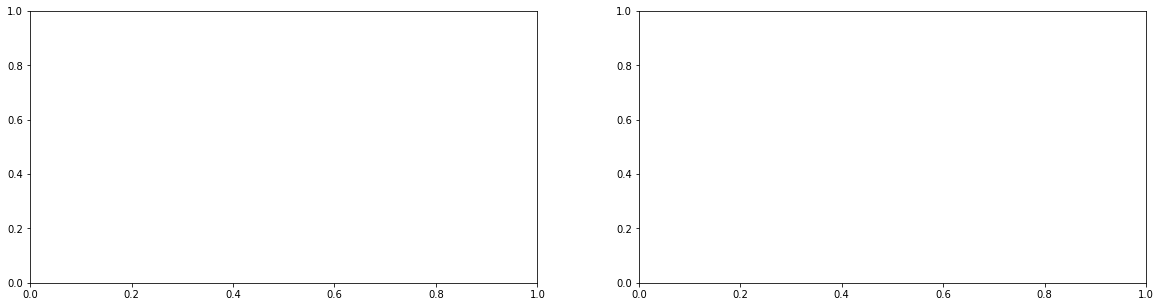

In [63]:
# Plot of the LSST and LSST+Euclid results comparison

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

bins = np.linspace(0, 50,100)
mid = (bins[1:]+bins[:-1])*0.5

mean_delta_g, var_delta_g = mean_var(delta_r,delta_g_lsst_euclid,bins)
mean_delta_g1, var_delta_g1 = mean_var(delta_r,delta_g1_lsst_euclid,bins)
mean_delta_g2, var_delta_g2 = mean_var(delta_r,delta_g2_lsst_euclid,bins)

mean_delta_g_lsst, var_delta_g_lsst = mean_var(delta_r,delta_g_lsst,bins)
mean_delta_g1_lsst, var_delta_g1_lsst = mean_var(delta_r,delta_g1_lsst,bins)
mean_delta_g2_lsst, var_delta_g2_lsst = mean_var(delta_r,delta_g2_lsst,bins)



ax = axes[0]
ax.plot(mid, mean_delta_g1, label = 'LSST-EUCLID')
ax.fill_between(mid, mean_delta_g1 - 10*var_delta_g1**0.5, mean_delta_g1 + 10*var_delta_g1**0.5, alpha=0.5)
ax.plot(mid, mean_delta_g1_lsst, label = 'LSST')
ax.fill_between(mid, mean_delta_g1_lsst - 10*var_delta_g1_lsst**0.5, mean_delta_g1_lsst + 10*var_delta_g1_lsst**0.5, alpha=0.5)
ax.set_ylabel('delta g1', fontsize = 10)
ax.set_xlabel('delta r', fontsize = 10)
ax.plot(mid,mid*0)
ax.legend(fontsize = 10)
ax.set_xlim(0,40)
ax.set_ylim(-0.5,0.5)

ax = axes[1]
ax.plot(mid, mean_delta_g2, label = 'LSST-EUCLID')
ax.fill_between(mid, mean_delta_g2 - 10*var_delta_g2**0.5, mean_delta_g2 + 10*var_delta_g2**0.5, alpha=0.5)
ax.plot(mid, mean_delta_g2_lsst, label = 'LSST')
ax.fill_between(mid, mean_delta_g2_lsst - 10*var_delta_g2_lsst**0.5, mean_delta_g2_lsst + 10*var_delta_g2_lsst**0.5, alpha=0.5)
ax.set_ylabel('delta g2', fontsize = 10)
ax.set_xlabel('delta r', fontsize = 10)
ax.plot(mid,mid*0)
ax.legend(fontsize = 10)
ax.set_xlim(0,40)
#ax.set_ylim(-0.5,0.5)

### Only the LSST results

In [ ]:
# Plot of the LSST results only

ig, axes = plt.subplots(1, 2, figsize=(20, 5))

bins = np.linspace(0, 50,100)
mid = (bins[1:]+bins[:-1])*0.5

mean_delta_g_lsst, var_delta_g_lsst = mean_var(delta_r_2,delta_g_lsst,bins)
mean_delta_g1_lsst, var_delta_g1_lsst = mean_var(delta_r_2,delta_g1_lsst,bins)
mean_delta_g2_lsst, var_delta_g2_lsst = mean_var(delta_r_2,delta_g2_lsst,bins)


#ax = axes[0]
#ax.plot(mid,mean_delta_g_lsst, label = 'LSST')
#ax.fill_between(mid, mean_delta_g_lsst - 10*var_delta_g_lsst**0.5, mean_delta_g_lsst + 10*var_delta_g_lsst**0.5, alpha=0.5)
#ax.set_ylabel('delta g', fontsize = 10)
#ax.set_xlabel('delta r', fontsize = 10)
#ax.legend(fontsize = 10)
#ax.set_xlim(0,40)
#ax.set_ylim(-0.5,0.5)

ax = axes[0]
ax.plot(mid, mean_delta_g1_lsst, label = 'LSST')
ax.plot(mid,mid*0)
ax.fill_between(mid, mean_delta_g1_lsst - 10*var_delta_g1_lsst**0.5, mean_delta_g1_lsst + 10*var_delta_g1_lsst**0.5, alpha=0.5)
ax.set_ylabel('delta g1', fontsize = 10)
ax.set_xlabel('delta r', fontsize = 10)
ax.legend(fontsize = 10)
ax.set_xlim(0,40)
ax.set_ylim(-0.5,0.5)

ax = axes[1]
ax.plot(mid, mean_delta_g2_lsst, label = 'LSST')
ax.plot(mid,mid*0)
ax.fill_between(mid, mean_delta_g2_lsst - 10*var_delta_g2_lsst**0.5, mean_delta_g2_lsst + 10*var_delta_g2_lsst**0.5, alpha=0.5)
ax.set_ylabel('delta g2', fontsize = 10)
ax.set_xlabel('delta r', fontsize = 10)
ax.legend(fontsize = 10)
ax.set_xlim(0,40)
ax.set_ylim(-0.5,0.5)